In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime
from geopy.geocoders import Nominatim
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly_express as px
import plotly.io as pio
pio.renderers.default = 'browser'
import reverse_geocoder as rg
from math import sqrt

In [3]:
or_df = pd.read_csv("database.csv")
or_df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [4]:
def convert_date(Date):
    return pd.to_datetime(Date).strftime('%m/%d/%Y')

or_df['date'] = or_df['Date'].apply(convert_date)

In [4]:
or_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

In [5]:
or_df['month'] = pd.to_datetime(or_df['date']).dt.month

In [6]:
or_df['year'] = pd.to_datetime(or_df['date']).dt.year

In [7]:
or_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

In [8]:
or_df.groupby('Type')[['Magnitude','month']].sum()

,Magnitude,month
Type,,
Earthquake,136668.34,151682
Explosion,23.40,26
Nuclear Explosion,1023.87,1355
Rock Burst,6.20,2


In [67]:
df = or_df[['month', 'year', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]

In [68]:
df.dropna()
df.describe()

,month,year,Latitude,Longitude,Depth,Magnitude
count,23412.000000,23412.000000,23412.000000,23412.000000,23412.000000,23412.000000
mean,6.537887,1992.632411,1.679033,39.639961,70.767911,5.882531
std,3.454541,14.426100,30.113183,125.511959,122.651898,0.423066
min,1.000000,1965.000000,-77.080000,-179.997000,-1.100000,5.500000
25%,4.000000,1981.000000,-18.653000,-76.349750,14.522500,5.600000
50%,7.000000,1993.000000,-3.568500,103.982000,33.000000,5.700000
75%,10.000000,2005.000000,26.190750,145.026250,54.000000,6.000000
max,12.000000,2016.000000,86.005000,179.998000,700.000000,9.100000


In [103]:
for i in range(len(df)):
    coordinates = (df.Latitude[i],df.Longitude[i]) #Both located in the ocean
    a= rg.search(coordinates) 
    df.Impacted_Country = a[0]['cc']
    print(i, a[0]['cc'])

0 MP
1 ID
2 TO
3 GS
4 PH
5 VU
6 IN
7 VU
8 GS
9 FJ
10 ID
11 ID
12 RU
13 TO
14 TJ
15 AU
16 RU
17 RU
18 RU
19 RU
20 RU
21 RU
22 RU
23 RU
24 RU
25 RU
26 RU
27 RU
28 RU
29 RU
30 RU
31 RU
32 GF
33 RU
34 RU
35 RU
36 RU
37 RU
38 RU
39 US
40 RU
41 RU
42 RU
43 RU
44 US
45 RU
46 RU
47 RU
48 RU
49 RU
50 VU
51 RU
52 RU
53 RU
54 ID
55 JP
56 RU
57 MP
58 IN
59 TL
60 RU
61 TO
62 CL
63 PG
64 RU
65 CO
66 MX
67 PG
68 PH
69 PG
70 PH
71 RU
72 MX
73 TR
74 TO
75 PG
76 RU
77 PG
78 RU
79 RU
80 AR
81 RU
82 PF
83 PH
84 TO
85 GR
86 US
87 AF
88 TW
89 JP
90 RU
91 TO
92 GS
93 ID
94 ID
95 TO
96 CL
97 TO
98 PH
99 RU
100 CL
101 JP
102 TO
103 RU
104 GR
105 PH
106 MX
107 RU
108 TO
109 GR
110 JP
111 JP
112 ID
113 RU
114 NZ
115 GR
116 TO
117 WF
118 VU
119 NZ
120 FJ
121 JP
122 JP
123 US
124 US
125 GS
126 GS
127 JP
128 FM
129 MP
130 ID
131 US
132 TW
133 TL
134 GR
135 EC
136 US
137 ID
138 US
139 JP
140 CL
141 SV
142 CL
143 CN
144 ID
145 ID
146 ID
147 PH
148 TW
149 SB
150 ID
151 PG
152 VU
153 ID
154 TO
155 RU
156 PH
157 RU
158 

1163 ID
1164 ID
1165 PE
1166 FJ
1167 FJ
1168 CN
1169 TL
1170 VU
1171 ID
1172 ID
1173 ID
1174 ID
1175 ID
1176 ID
1177 ID
1178 PT
1179 PT
1180 TR
1181 RU
1182 ID
1183 AF
1184 JP
1185 ID
1186 ID
1187 PG
1188 NI
1189 ID
1190 US
1191 JP
1192 JP
1193 JP
1194 MX
1195 PH
1196 PH
1197 JP
1198 MX
1199 TO
1200 TR
1201 TR
1202 ID
1203 ID
1204 TR
1205 ET
1206 ET
1207 YE
1208 EG
1209 JP
1210 RU
1211 MX
1212 RU
1213 ET
1214 EC
1215 TR
1216 RU
1217 ZA
1218 JP
1219 RU
1220 IN
1221 ID
1222 JP
1223 ID
1224 PG
1225 VU
1226 VU
1227 JP
1228 ID
1229 GT
1230 JP
1231 CL
1232 JP
1233 YE
1234 PA
1235 CL
1236 CL
1237 ID
1238 GS
1239 TO
1240 SB
1241 TO
1242 VU
1243 NI
1244 JP
1245 ID
1246 US
1247 AF
1248 GP
1249 SB
1250 PH
1251 US
1252 TO
1253 GS
1254 PH
1255 EC
1256 TO
1257 TO
1258 TO
1259 JP
1260 GR
1261 RU
1262 SB
1263 MP
1264 NZ
1265 US
1266 JP
1267 US
1268 ID
1269 RU
1270 US
1271 MX
1272 PG
1273 PH
1274 TO
1275 AQ
1276 AU
1277 ID
1278 MP
1279 ID
1280 RU
1281 JP
1282 RU
1283 CN
1284 BO
1285 PE
1286 ID
1287 SB


2188 MX
2189 RU
2190 TW
2191 ID
2192 PG
2193 ID
2194 TO
2195 TW
2196 TW
2197 GS
2198 BR
2199 CN
2200 RU
2201 TO
2202 CN
2203 RU
2204 PG
2205 PG
2206 AF
2207 BR
2208 GT
2209 VU
2210 VU
2211 VU
2212 TO
2213 TW
2214 TW
2215 ID
2216 TO
2217 VU
2218 TW
2219 SB
2220 PG
2221 CL
2222 GU
2223 CR
2224 PH
2225 CL
2226 TO
2227 GS
2228 BR
2229 SB
2230 PE
2231 SB
2232 PG
2233 SB
2234 JP
2235 MX
2236 US
2237 TO
2238 US
2239 GS
2240 RU
2241 JP
2242 JP
2243 TO
2244 US
2245 CL
2246 JP
2247 TO
2248 JP
2249 TO
2250 ID
2251 JP
2252 TR
2253 RU
2254 TO
2255 JP
2256 JP
2257 PE
2258 US
2259 US
2260 RU
2261 TO
2262 TO
2263 US
2264 PH
2265 RU
2266 TO
2267 PG
2268 JP
2269 WF
2270 TO
2271 FJ
2272 CL
2273 GS
2274 NZ
2275 TO
2276 TO
2277 VU
2278 GL
2279 ID
2280 GS
2281 BR
2282 US
2283 CN
2284 IR
2285 BR
2286 TO
2287 JP
2288 US
2289 TO
2290 ID
2291 CL
2292 TO
2293 TW
2294 TW
2295 PH
2296 VU
2297 PH
2298 JP
2299 PG
2300 PG
2301 PH
2302 PH
2303 MX
2304 JP
2305 ID
2306 VU
2307 GR
2308 TW
2309 PG
2310 PG
2311 PN
2312 ID


3213 CO
3214 US
3215 JP
3216 KG
3217 AR
3218 RU
3219 ID
3220 JP
3221 ID
3222 PH
3223 PH
3224 LY
3225 TL
3226 AF
3227 PG
3228 MQ
3229 ID
3230 VU
3231 PG
3232 GS
3233 TO
3234 ID
3235 GS
3236 RU
3237 AR
3238 RU
3239 ID
3240 JP
3241 PG
3242 ID
3243 NZ
3244 TO
3245 RU
3246 GA
3247 JP
3248 CO
3249 CN
3250 RU
3251 FM
3252 PE
3253 PE
3254 PK
3255 GS
3256 AG
3257 JP
3258 JP
3259 JP
3260 ID
3261 CL
3262 AU
3263 JP
3264 ID
3265 JP
3266 JP
3267 TO
3268 GL
3269 KZ
3270 JP
3271 PG
3272 PN
3273 ID
3274 PG
3275 PG
3276 WF
3277 RU
3278 IS
3279 PG
3280 AU
3281 MX
3282 PG
3283 VU
3284 TL
3285 JP
3286 RU
3287 TO
3288 JP
3289 GS
3290 PE
3291 ID
3292 WF
3293 US
3294 TO
3295 CL
3296 ID
3297 AU
3298 US
3299 JP
3300 ID
3301 PH
3302 PH
3303 PG
3304 PG
3305 VU
3306 GS
3307 MX
3308 TL
3309 PG
3310 VU
3311 VU
3312 JP
3313 AR
3314 US
3315 PH
3316 PG
3317 ID
3318 ID
3319 PE
3320 US
3321 AF
3322 ID
3323 ID
3324 CL
3325 AU
3326 PA
3327 WF
3328 WF
3329 ID
3330 RU
3331 KZ
3332 PK
3333 CL
3334 US
3335 GT
3336 US
3337 US


4238 TO
4239 GS
4240 PH
4241 ID
4242 ES
4243 ID
4244 SH
4245 JP
4246 JP
4247 TF
4248 RU
4249 SH
4250 AG
4251 PG
4252 PG
4253 PG
4254 PH
4255 PH
4256 FJ
4257 PH
4258 RO
4259 ID
4260 ID
4261 SB
4262 PE
4263 PE
4264 ID
4265 KP
4266 ID
4267 GP
4268 ID
4269 PG
4270 PH
4271 PG
4272 JP
4273 PH
4274 PH
4275 PF
4276 GU
4277 IR
4278 IR
4279 NZ
4280 IR
4281 CO
4282 WF
4283 IR
4284 WF
4285 IR
4286 ID
4287 US
4288 TO
4289 VU
4290 AU
4291 IR
4292 ID
4293 TO
4294 BR
4295 GU
4296 IR
4297 ZA
4298 ID
4299 PE
4300 AU
4301 MP
4302 ID
4303 PH
4304 ID
4305 PG
4306 JP
4307 SB
4308 SB
4309 SB
4310 SB
4311 SB
4312 SB
4313 SB
4314 SB
4315 SB
4316 SB
4317 JP
4318 SB
4319 SB
4320 SB
4321 SB
4322 SB
4323 ID
4324 WF
4325 SB
4326 PG
4327 PH
4328 ID
4329 ID
4330 CN
4331 IN
4332 JP
4333 EC
4334 EC
4335 TO
4336 ID
4337 TO
4338 ID
4339 SB
4340 PH
4341 ID
4342 JP
4343 MP
4344 ID
4345 ID
4346 AQ
4347 KZ
4348 NZ
4349 US
4350 SB
4351 TR
4352 AF
4353 CL
4354 IR
4355 JP
4356 ID
4357 ID
4358 TO
4359 PH
4360 SH
4361 TO
4362 MP


5263 PG
5264 PH
5265 ID
5266 ID
5267 ID
5268 ID
5269 ID
5270 RU
5271 JP
5272 PE
5273 TO
5274 GS
5275 ID
5276 ID
5277 ID
5278 IT
5279 US
5280 US
5281 RU
5282 FK
5283 FK
5284 RU
5285 PG
5286 FK
5287 PG
5288 KZ
5289 VU
5290 ID
5291 TO
5292 ID
5293 TO
5294 MM
5295 TL
5296 PH
5297 PE
5298 ID
5299 ID
5300 NZ
5301 NZ
5302 MX
5303 US
5304 US
5305 ID
5306 DJ
5307 MP
5308 AU
5309 ID
5310 RU
5311 TO
5312 RU
5313 ID
5314 ID
5315 TL
5316 ID
5317 NZ
5318 SB
5319 SB
5320 SB
5321 SB
5322 SB
5323 SB
5324 SB
5325 KZ
5326 EC
5327 GS
5328 GT
5329 GT
5330 KZ
5331 JP
5332 MP
5333 ID
5334 PG
5335 VU
5336 ID
5337 ID
5338 TO
5339 DO
5340 TO
5341 SB
5342 NZ
5343 RU
5344 WF
5345 VU
5346 NZ
5347 ID
5348 TO
5349 ID
5350 TO
5351 IR
5352 BR
5353 WF
5354 ID
5355 GS
5356 PH
5357 SJ
5358 ID
5359 AR
5360 CO
5361 TO
5362 PG
5363 IR
5364 AR
5365 PN
5366 KZ
5367 TW
5368 ID
5369 IR
5370 ID
5371 VU
5372 MP
5373 JP
5374 EC
5375 CO
5376 CO
5377 PA
5378 CO
5379 NC
5380 JP
5381 ID
5382 TO
5383 TO
5384 ID
5385 NI
5386 VU
5387 IN


6288 JP
6289 US
6290 NC
6291 US
6292 US
6293 PG
6294 PE
6295 NC
6296 TO
6297 TO
6298 TO
6299 TO
6300 TO
6301 AU
6302 TO
6303 AU
6304 PG
6305 PG
6306 ID
6307 PH
6308 SB
6309 TL
6310 RU
6311 JP
6312 ID
6313 TO
6314 HN
6315 TO
6316 VU
6317 US
6318 TO
6319 VU
6320 TO
6321 NC
6322 SH
6323 ID
6324 PN
6325 RU
6326 AQ
6327 RU
6328 TO
6329 SB
6330 TW
6331 MV
6332 CL
6333 ID
6334 PH
6335 ID
6336 ID
6337 JP
6338 TO
6339 ID
6340 GS
6341 ID
6342 RU
6343 ID
6344 VU
6345 AL
6346 PG
6347 FK
6348 EC
6349 AR
6350 PE
6351 FK
6352 AF
6353 RU
6354 ID
6355 TO
6356 GT
6357 PN
6358 RU
6359 ID
6360 US
6361 ID
6362 VU
6363 KZ
6364 SB
6365 TO
6366 YE
6367 CL
6368 CL
6369 TV
6370 NC
6371 AR
6372 AR
6373 YE
6374 TO
6375 TO
6376 AF
6377 JP
6378 TO
6379 ID
6380 NZ
6381 NZ
6382 TO
6383 TO
6384 TO
6385 TO
6386 IR
6387 TO
6388 TO
6389 TO
6390 GS
6391 TO
6392 TO
6393 TO
6394 TO
6395 TO
6396 TO
6397 TO
6398 TO
6399 TO
6400 PT
6401 TO
6402 TO
6403 ID
6404 KZ
6405 JP
6406 JP
6407 PH
6408 TO
6409 JP
6410 CL
6411 KG
6412 PE


7313 PF
7314 ID
7315 SH
7316 BR
7317 PG
7318 PE
7319 CL
7320 ID
7321 MX
7322 KZ
7323 PG
7324 JP
7325 JP
7326 VU
7327 NI
7328 PG
7329 PG
7330 PG
7331 PE
7332 GS
7333 KZ
7334 RU
7335 NZ
7336 FJ
7337 NZ
7338 TW
7339 NZ
7340 NZ
7341 NZ
7342 NZ
7343 IN
7344 TO
7345 AR
7346 AU
7347 US
7348 WF
7349 TO
7350 TO
7351 MV
7352 PA
7353 JP
7354 NZ
7355 IN
7356 TO
7357 NZ
7358 TO
7359 CA
7360 GF
7361 AU
7362 MV
7363 ID
7364 PH
7365 NZ
7366 JP
7367 NC
7368 SB
7369 PG
7370 PG
7371 CL
7372 ID
7373 WF
7374 PG
7375 ID
7376 CL
7377 TO
7378 AR
7379 JP
7380 ID
7381 ID
7382 NZ
7383 AQ
7384 TO
7385 RU
7386 IR
7387 TO
7388 KZ
7389 MX
7390 BR
7391 US
7392 CL
7393 PG
7394 TO
7395 ID
7396 JP
7397 TO
7398 CL
7399 CL
7400 GS
7401 SB
7402 TZ
7403 CL
7404 ID
7405 ID
7406 SH
7407 VU
7408 JP
7409 JP
7410 ID
7411 ID
7412 ID
7413 ID
7414 CL
7415 CL
7416 CL
7417 CL
7418 CL
7419 CL
7420 CL
7421 CL
7422 CL
7423 CL
7424 CL
7425 CL
7426 CL
7427 CL
7428 CL
7429 PN
7430 ID
7431 RU
7432 VU
7433 RU
7434 CL
7435 PH
7436 PE
7437 ID


8338 CL
8339 ID
8340 AU
8341 ID
8342 PG
8343 GS
8344 SH
8345 PG
8346 CL
8347 US
8348 TO
8349 NZ
8350 JP
8351 JP
8352 NZ
8353 PG
8354 ID
8355 PG
8356 PG
8357 PG
8358 PG
8359 PG
8360 PG
8361 PG
8362 TO
8363 PG
8364 PG
8365 PH
8366 VU
8367 RU
8368 ID
8369 VU
8370 WF
8371 CL
8372 RU
8373 WF
8374 WF
8375 TO
8376 ID
8377 VU
8378 NZ
8379 GS
8380 US
8381 GS
8382 PG
8383 GS
8384 VU
8385 AU
8386 PG
8387 PG
8388 PH
8389 CN
8390 US
8391 GR
8392 JP
8393 NZ
8394 NZ
8395 AU
8396 NZ
8397 JP
8398 PG
8399 CL
8400 CL
8401 CL
8402 CL
8403 PG
8404 EC
8405 EC
8406 EC
8407 CL
8408 EC
8409 CL
8410 MX
8411 RU
8412 VU
8413 TO
8414 PE
8415 PE
8416 JP
8417 JP
8418 JP
8419 KZ
8420 MX
8421 SH
8422 TO
8423 TO
8424 NI
8425 TO
8426 TO
8427 TO
8428 CL
8429 JP
8430 MX
8431 CL
8432 CC
8433 PG
8434 PG
8435 PG
8436 PG
8437 SB
8438 ID
8439 JP
8440 TO
8441 VU
8442 JP
8443 TO
8444 US
8445 CR
8446 US
8447 CL
8448 JP
8449 TO
8450 VU
8451 TO
8452 JP
8453 PG
8454 VU
8455 AR
8456 AF
8457 KZ
8458 PG
8459 SH
8460 JP
8461 AR
8462 PG


9363 VU
9364 VU
9365 CL
9366 ID
9367 JP
9368 ID
9369 ID
9370 JP
9371 VU
9372 CL
9373 US
9374 VU
9375 WF
9376 PH
9377 TO
9378 ID
9379 ID
9380 AR
9381 TL
9382 JP
9383 MM
9384 DO
9385 JP
9386 ID
9387 VU
9388 ID
9389 ID
9390 MW
9391 PG
9392 MW
9393 PG
9394 TO
9395 TO
9396 TO
9397 PH
9398 JP
9399 GR
9400 PG
9401 NZ
9402 FJ
9403 TO
9404 AU
9405 PH
9406 GR
9407 TO
9408 PG
9409 IN
9410 CL
9411 VU
9412 AU
9413 CL
9414 TO
9415 TO
9416 RU
9417 CL
9418 AU
9419 IN
9420 ET
9421 WF
9422 CN
9423 VU
9424 JP
9425 ID
9426 BR
9427 TO
9428 FJ
9429 TO
9430 MX
9431 ID
9432 PE
9433 CL
9434 RU
9435 CL
9436 US
9437 VU
9438 CN
9439 VU
9440 PG
9441 MX
9442 JP
9443 JP
9444 TR
9445 MX
9446 TR
9447 ID
9448 ID
9449 GS
9450 ID
9451 VE
9452 WF
9453 ID
9454 PT
9455 MX
9456 PT
9457 CN
9458 CN
9459 VE
9460 TO
9461 BR
9462 CN
9463 TO
9464 TO
9465 NZ
9466 PF
9467 MN
9468 TO
9469 ID
9470 MU
9471 GL
9472 TO
9473 SB
9474 US
9475 PN
9476 RU
9477 AQ
9478 MP
9479 US
9480 VU
9481 TO
9482 ID
9483 WF
9484 NZ
9485 NZ
9486 NZ
9487 NZ


10345 PH
10346 NZ
10347 NZ
10348 JP
10349 AU
10350 ID
10351 AF
10352 PN
10353 CL
10354 RU
10355 WF
10356 SB
10357 SB
10358 BR
10359 GU
10360 NZ
10361 CL
10362 TO
10363 SB
10364 NZ
10365 PG
10366 CL
10367 ID
10368 RU
10369 VU
10370 PH
10371 VU
10372 ID
10373 CL
10374 PH
10375 RU
10376 PH
10377 AF
10378 TO
10379 TL
10380 CN
10381 VU
10382 TO
10383 CR
10384 TO
10385 TO
10386 TO
10387 EC
10388 ID
10389 TO
10390 RU
10391 RU
10392 RU
10393 RU
10394 CL
10395 RU
10396 PN
10397 PG
10398 ZA
10399 PA
10400 GS
10401 US
10402 CR
10403 GR
10404 PE
10405 PE
10406 SB
10407 RU
10408 FJ
10409 PH
10410 PH
10411 DO
10412 VU
10413 PE
10414 TO
10415 TO
10416 MM
10417 MX
10418 PG
10419 MX
10420 PG
10421 CO
10422 PE
10423 PE
10424 PE
10425 PE
10426 PN
10427 FJ
10428 WF
10429 ID
10430 RU
10431 PE
10432 PG
10433 SB
10434 SV
10435 VU
10436 JP
10437 ID
10438 TJ
10439 TO
10440 GP
10441 TO
10442 TL
10443 PG
10444 MG
10445 CR
10446 ID
10447 GT
10448 PH
10449 CO
10450 PH
10451 CR
10452 PH
10453 GE
10454 PE
10455 GE
1

11256 ID
11257 BO
11258 ID
11259 ID
11260 TO
11261 PG
11262 EC
11263 TO
11264 SH
11265 JP
11266 ID
11267 ID
11268 ID
11269 SB
11270 JP
11271 TO
11272 AU
11273 TF
11274 ID
11275 ID
11276 ID
11277 TO
11278 SH
11279 TO
11280 TO
11281 TO
11282 YE
11283 TO
11284 GS
11285 PA
11286 PA
11287 GS
11288 JM
11289 AU
11290 JP
11291 JP
11292 GS
11293 MP
11294 CN
11295 ZA
11296 JP
11297 ID
11298 ID
11299 ID
11300 TO
11301 ID
11302 TL
11303 RU
11304 TW
11305 US
11306 TF
11307 TO
11308 CN
11309 CN
11310 TO
11311 MP
11312 PH
11313 GU
11314 BR
11315 GU
11316 GU
11317 GS
11318 JP
11319 ID
11320 BR
11321 JP
11322 ID
11323 WF
11324 VU
11325 PG
11326 SH
11327 TO
11328 TL
11329 RU
11330 RU
11331 RU
11332 AR
11333 TO
11334 JP
11335 RU
11336 ID
11337 ID
11338 PG
11339 FJ
11340 FJ
11341 MX
11342 SB
11343 SB
11344 TO
11345 SB
11346 SB
11347 SB
11348 ID
11349 AU
11350 GS
11351 GS
11352 TO
11353 AU
11354 WF
11355 WF
11356 WF
11357 SD
11358 CL
11359 DJ
11360 CL
11361 GR
11362 CL
11363 JP
11364 GS
11365 CN
11366 WF
1

12167 FJ
12168 PG
12169 MX
12170 TW
12171 ZA
12172 ID
12173 ID
12174 CR
12175 TO
12176 MV
12177 MY
12178 SB
12179 BR
12180 TO
12181 NZ
12182 FM
12183 BR
12184 PH
12185 RU
12186 PG
12187 PE
12188 PH
12189 PH
12190 ID
12191 RU
12192 PN
12193 RU
12194 SB
12195 VU
12196 ID
12197 ID
12198 MM
12199 RU
12200 NZ
12201 VU
12202 PH
12203 ID
12204 SB
12205 PE
12206 AR
12207 ID
12208 ID
12209 CL
12210 MX
12211 TO
12212 PE
12213 ID
12214 MX
12215 ID
12216 SB
12217 ID
12218 PE
12219 NZ
12220 ID
12221 TO
12222 WF
12223 AU
12224 WF
12225 ID
12226 TO
12227 US
12228 NZ
12229 MP
12230 JP
12231 JP
12232 JP
12233 JP
12234 JP
12235 JP
12236 JP
12237 JP
12238 NZ
12239 JP
12240 JP
12241 JP
12242 CN
12243 MP
12244 PG
12245 JP
12246 JP
12247 TO
12248 AR
12249 PN
12250 NC
12251 GS
12252 PH
12253 JP
12254 JP
12255 EC
12256 JP
12257 CN
12258 JP
12259 TO
12260 EC
12261 RU
12262 RU
12263 TO
12264 JP
12265 PG
12266 RU
12267 RU
12268 JP
12269 TO
12270 VU
12271 RU
12272 TL
12273 CO
12274 SB
12275 RU
12276 GT
12277 ID
1

13078 RU
13079 RU
13080 ZA
13081 RU
13082 RU
13083 RU
13084 RU
13085 JP
13086 JP
13087 TO
13088 TO
13089 ID
13090 ID
13091 RU
13092 PN
13093 PH
13094 CN
13095 CL
13096 FM
13097 SB
13098 ID
13099 MP
13100 MP
13101 RU
13102 US
13103 MP
13104 MX
13105 RU
13106 ID
13107 RU
13108 GR
13109 TO
13110 PH
13111 SV
13112 ID
13113 ID
13114 TO
13115 TO
13116 TO
13117 US
13118 CL
13119 TO
13120 ID
13121 TW
13122 PH
13123 PG
13124 CN
13125 MU
13126 ID
13127 SB
13128 TO
13129 TO
13130 EC
13131 TO
13132 TO
13133 US
13134 PH
13135 ID
13136 RU
13137 PG
13138 JP
13139 PG
13140 JP
13141 JP
13142 ID
13143 JP
13144 VU
13145 ID
13146 ID
13147 VU
13148 ID
13149 SH
13150 TR
13151 TR
13152 VU
13153 GS
13154 WF
13155 BR
13156 US
13157 TF
13158 PA
13159 SB
13160 ID
13161 SB
13162 EC
13163 EC
13164 EC
13165 GT
13166 TO
13167 TF
13168 SH
13169 SB
13170 AU
13171 CR
13172 BR
13173 RU
13174 VU
13175 US
13176 SB
13177 GU
13178 PG
13179 DZ
13180 JP
13181 CR
13182 CL
13183 CL
13184 CL
13185 ID
13186 HR
13187 TW
13188 PG
1

13989 ID
13990 ZA
13991 BO
13992 BO
13993 JP
13994 PH
13995 ID
13996 AU
13997 PG
13998 RU
13999 RU
14000 EG
14001 CN
14002 ID
14003 ID
14004 AF
14005 JP
14006 RU
14007 JP
14008 PT
14009 CL
14010 TO
14011 AR
14012 MX
14013 TO
14014 FJ
14015 PG
14016 JP
14017 NZ
14018 ID
14019 SH
14020 TO
14021 JP
14022 GU
14023 CO
14024 GP
14025 SH
14026 SH
14027 AG
14028 TR
14029 AU
14030 NZ
14031 JP
14032 MX
14033 PT
14034 AZ
14035 TO
14036 US
14037 MX
14038 VU
14039 MX
14040 MX
14041 GU
14042 SB
14043 VU
14044 TW
14045 PG
14046 PG
14047 PG
14048 ID
14049 CL
14050 VU
14051 CL
14052 TO
14053 CN
14054 PH
14055 VU
14056 CL
14057 ID
14058 NC
14059 NC
14060 ID
14061 CN
14062 PF
14063 AU
14064 ZA
14065 EC
14066 PN
14067 IR
14068 NC
14069 NZ
14070 ID
14071 GS
14072 SB
14073 AU
14074 JP
14075 JP
14076 AU
14077 PG
14078 JP
14079 RU
14080 PG
14081 MP
14082 PH
14083 NI
14084 CN
14085 CN
14086 ID
14087 GS
14088 MP
14089 AR
14090 CA
14091 RU
14092 TO
14093 GS
14094 TO
14095 ID
14096 TO
14097 JP
14098 CL
14099 NP
1

14900 GU
14901 NZ
14902 JP
14903 JP
14904 PH
14905 RU
14906 RU
14907 ID
14908 JP
14909 WF
14910 RU
14911 ID
14912 US
14913 US
14914 AU
14915 TO
14916 JP
14917 SH
14918 ZA
14919 TL
14920 AU
14921 PH
14922 PG
14923 ID
14924 VU
14925 AF
14926 PH
14927 JP
14928 CR
14929 ID
14930 JP
14931 CR
14932 MX
14933 PT
14934 ID
14935 JP
14936 ID
14937 SH
14938 BR
14939 JP
14940 JP
14941 SB
14942 TW
14943 JP
14944 SB
14945 JP
14946 JP
14947 FJ
14948 TO
14949 FJ
14950 TF
14951 TO
14952 SB
14953 JP
14954 ID
14955 PE
14956 ID
14957 RU
14958 ID
14959 ID
14960 JP
14961 JP
14962 ID
14963 SB
14964 VU
14965 MX
14966 FJ
14967 ID
14968 MX
14969 NI
14970 SB
14971 NZ
14972 RU
14973 TO
14974 TO
14975 ID
14976 JP
14977 JP
14978 RU
14979 PH
14980 ID
14981 GS
14982 PG
14983 TM
14984 MX
14985 CL
14986 SH
14987 ID
14988 WF
14989 MP
14990 ID
14991 ID
14992 ID
14993 ID
14994 ID
14995 PH
14996 ID
14997 ID
14998 WF
14999 TO
15000 TO
15001 RU
15002 ZA
15003 PH
15004 ID
15005 TO
15006 CL
15007 PH
15008 TW
15009 ID
15010 ID
1

15811 TO
15812 NO
15813 WF
15814 PH
15815 VU
15816 RU
15817 TO
15818 RU
15819 ID
15820 PE
15821 ID
15822 PH
15823 PH
15824 ID
15825 TF
15826 TO
15827 TW
15828 PT
15829 TZ
15830 WF
15831 KY
15832 RU
15833 GR
15834 CL
15835 CL
15836 ID
15837 CL
15838 US
15839 ID
15840 AR
15841 TW
15842 VU
15843 RU
15844 JP
15845 CN
15846 PT
15847 PG
15848 PA
15849 MX
15850 VU
15851 NI
15852 NI
15853 FM
15854 NC
15855 FM
15856 SH
15857 AU
15858 PH
15859 AU
15860 GP
15861 ID
15862 CR
15863 WF
15864 ID
15865 EC
15866 EC
15867 VU
15868 CL
15869 PG
15870 VU
15871 PG
15872 WF
15873 PN
15874 IR
15875 SH
15876 MX
15877 ID
15878 VU
15879 CN
15880 VU
15881 CN
15882 FJ
15883 CL
15884 AR
15885 PG
15886 TO
15887 PG
15888 US
15889 TW
15890 PK
15891 SB
15892 JP
15893 RU
15894 ID
15895 PN
15896 JP
15897 ID
15898 RU
15899 MV
15900 WF
15901 PH
15902 GS
15903 GS
15904 ID
15905 PA
15906 JP
15907 PA
15908 SH
15909 NI
15910 CL
15911 SH
15912 PG
15913 TO
15914 PA
15915 CO
15916 AU
15917 TO
15918 ET
15919 PE
15920 VU
15921 ID
1

16722 TO
16723 JP
16724 TO
16725 TO
16726 AF
16727 CR
16728 CL
16729 GS
16730 ID
16731 VU
16732 TO
16733 FM
16734 TO
16735 ID
16736 JP
16737 NC
16738 TO
16739 RU
16740 AU
16741 SJ
16742 VU
16743 VU
16744 IN
16745 SB
16746 TO
16747 ID
16748 ID
16749 SB
16750 TO
16751 TL
16752 ID
16753 BR
16754 VU
16755 VU
16756 PG
16757 ID
16758 TO
16759 CL
16760 CL
16761 NC
16762 TO
16763 VU
16764 NI
16765 TO
16766 CR
16767 TO
16768 CL
16769 GT
16770 TO
16771 CN
16772 SH
16773 IT
16774 GS
16775 PG
16776 JP
16777 TO
16778 NC
16779 GS
16780 TW
16781 CN
16782 ID
16783 GF
16784 PG
16785 GU
16786 SB
16787 MX
16788 TW
16789 TO
16790 SB
16791 SB
16792 SB
16793 PH
16794 TW
16795 RU
16796 TO
16797 NZ
16798 PH
16799 SH
16800 IR
16801 JP
16802 JP
16803 PE
16804 TO
16805 MV
16806 NZ
16807 FJ
16808 TO
16809 US
16810 TO
16811 ID
16812 HN
16813 VU
16814 AU
16815 NI
16816 RU
16817 JP
16818 TO
16819 WF
16820 TO
16821 MX
16822 CL
16823 CL
16824 PA
16825 SB
16826 TO
16827 ID
16828 US
16829 TF
16830 NI
16831 ID
16832 ID
1

17633 PG
17634 VU
17635 EC
17636 SB
17637 RU
17638 GS
17639 ID
17640 JP
17641 JP
17642 MP
17643 CL
17644 JP
17645 ID
17646 US
17647 TL
17648 JP
17649 MU
17650 GS
17651 US
17652 PG
17653 RU
17654 TO
17655 PH
17656 TO
17657 IR
17658 IR
17659 ID
17660 AQ
17661 CL
17662 MP
17663 PE
17664 PH
17665 TO
17666 JP
17667 VU
17668 JP
17669 FM
17670 PG
17671 CD
17672 TO
17673 PG
17674 CD
17675 FJ
17676 GF
17677 TL
17678 GF
17679 PG
17680 RU
17681 PH
17682 AF
17683 WF
17684 VU
17685 SV
17686 JP
17687 ID
17688 FM
17689 FJ
17690 ID
17691 PA
17692 PN
17693 PN
17694 EC
17695 JP
17696 PA
17697 JP
17698 ID
17699 GU
17700 GS
17701 PG
17702 TO
17703 GU
17704 MX
17705 AR
17706 GS
17707 PA
17708 RU
17709 GR
17710 PT
17711 US
17712 ID
17713 JP
17714 CL
17715 PT
17716 VU
17717 IN
17718 VU
17719 FJ
17720 CO
17721 CO
17722 PN
17723 TO
17724 AQ
17725 ID
17726 ID
17727 ID
17728 VU
17729 WF
17730 JP
17731 TO
17732 IN
17733 EC
17734 US
17735 PG
17736 RU
17737 VU
17738 AU
17739 TL
17740 ID
17741 PN
17742 MP
17743 TO
1

18544 CL
18545 MM
18546 GS
18547 JP
18548 SH
18549 JP
18550 VU
18551 RU
18552 US
18553 RU
18554 US
18555 ZA
18556 RU
18557 YE
18558 TO
18559 ID
18560 AU
18561 EC
18562 VU
18563 JP
18564 ID
18565 ID
18566 GP
18567 TO
18568 SB
18569 AU
18570 SH
18571 RU
18572 US
18573 PE
18574 PE
18575 PE
18576 PE
18577 US
18578 PE
18579 PE
18580 SB
18581 PE
18582 SH
18583 PE
18584 ID
18585 ID
18586 PE
18587 PE
18588 PE
18589 FJ
18590 GS
18591 PE
18592 NZ
18593 VU
18594 PE
18595 SH
18596 PH
18597 ID
18598 BR
18599 JP
18600 TO
18601 TO
18602 TO
18603 RU
18604 BO
18605 ID
18606 ID
18607 MX
18608 SB
18609 SB
18610 JP
18611 TW
18612 PN
18613 CO
18614 CL
18615 ID
18616 ID
18617 ID
18618 ID
18619 ID
18620 ID
18621 ID
18622 ID
18623 ID
18624 ID
18625 ID
18626 ID
18627 ID
18628 ID
18629 NZ
18630 WF
18631 ID
18632 ID
18633 FJ
18634 VU
18635 ID
18636 FJ
18637 ID
18638 ID
18639 ID
18640 ID
18641 CL
18642 ID
18643 ID
18644 SB
18645 NZ
18646 EC
18647 PG
18648 PG
18649 ID
18650 SH
18651 NC
18652 NC
18653 NC
18654 NC
1

19455 TO
19456 JP
19457 IT
19458 SH
19459 ID
19460 RU
19461 WF
19462 YE
19463 ID
19464 ID
19465 PG
19466 GS
19467 ID
19468 CL
19469 JP
19470 TO
19471 TO
19472 JP
19473 ID
19474 ID
19475 TO
19476 VU
19477 RU
19478 ID
19479 SB
19480 ID
19481 TO
19482 MX
19483 GL
19484 SB
19485 US
19486 GT
19487 ID
19488 VE
19489 PN
19490 EC
19491 PG
19492 GU
19493 MU
19494 ID
19495 TO
19496 TO
19497 US
19498 TO
19499 SJ
19500 PE
19501 SA
19502 PH
19503 GT
19504 MX
19505 FJ
19506 TO
19507 TF
19508 EC
19509 AQ
19510 TO
19511 HN
19512 MX
19513 VU
19514 PH
19515 GS
19516 VU
19517 VU
19518 VU
19519 NZ
19520 AU
19521 MX
19522 VU
19523 ZA
19524 JP
19525 CL
19526 VU
19527 JP
19528 GP
19529 TO
19530 TO
19531 NC
19532 PN
19533 CL
19534 TO
19535 VU
19536 ID
19537 ID
19538 ZA
19539 US
19540 GR
19541 GU
19542 US
19543 US
19544 JP
19545 PG
19546 SH
19547 ID
19548 GR
19549 ID
19550 MX
19551 PA
19552 NI
19553 RU
19554 JP
19555 MU
19556 CA
19557 CL
19558 CN
19559 MP
19560 PE
19561 ID
19562 TW
19563 AR
19564 NZ
19565 NZ
1

20366 TL
20367 ID
20368 PH
20369 WS
20370 MX
20371 SV
20372 IR
20373 ID
20374 ID
20375 JP
20376 JP
20377 JP
20378 JP
20379 JP
20380 JP
20381 RU
20382 VU
20383 ID
20384 NZ
20385 VU
20386 VU
20387 US
20388 VU
20389 VU
20390 AU
20391 VU
20392 TO
20393 VU
20394 VU
20395 RU
20396 SB
20397 BR
20398 AR
20399 ID
20400 CL
20401 AU
20402 JP
20403 VU
20404 BB
20405 ID
20406 ID
20407 VU
20408 VU
20409 VU
20410 VU
20411 VU
20412 TO
20413 CL
20414 MP
20415 VU
20416 JP
20417 NZ
20418 NC
20419 NC
20420 VU
20421 ID
20422 ID
20423 ID
20424 ID
20425 PK
20426 ID
20427 TO
20428 TO
20429 TJ
20430 ID
20431 SB
20432 TO
20433 SB
20434 IR
20435 NZ
20436 SJ
20437 NZ
20438 MP
20439 TO
20440 IN
20441 US
20442 TO
20443 IN
20444 VU
20445 CL
20446 ID
20447 PG
20448 PH
20449 PH
20450 CL
20451 CL
20452 CL
20453 SH
20454 TO
20455 ID
20456 TO
20457 CL
20458 CL
20459 CL
20460 CL
20461 ID
20462 JP
20463 VU
20464 PG
20465 RU
20466 AR
20467 FJ
20468 SB
20469 NZ
20470 NZ
20471 NZ
20472 MP
20473 NI
20474 TO
20475 MX
20476 SB
2

21277 PE
21278 AZ
21279 PH
21280 SH
21281 CL
21282 TJ
21283 PE
21284 PG
21285 CL
21286 CL
21287 JP
21288 IT
21289 JP
21290 JP
21291 BG
21292 JP
21293 AU
21294 AU
21295 NO
21296 JP
21297 AR
21298 TO
21299 RU
21300 TO
21301 IT
21302 IT
21303 ID
21304 NZ
21305 ID
21306 BO
21307 MU
21308 PA
21309 PA
21310 ID
21311 WF
21312 JP
21313 TW
21314 CL
21315 TO
21316 PE
21317 TW
21318 TR
21319 AF
21320 ID
21321 GS
21322 ID
21323 PH
21324 PH
21325 SB
21326 JP
21327 RU
21328 RU
21329 WF
21330 NZ
21331 NZ
21332 ID
21333 ID
21334 RU
21335 CN
21336 SV
21337 TO
21338 SH
21339 CN
21340 VU
21341 IN
21342 PE
21343 SB
21344 NZ
21345 VU
21346 PG
21347 JP
21348 TR
21349 JP
21350 JP
21351 TO
21352 JP
21353 AF
21354 ID
21355 RU
21356 ID
21357 PN
21358 TO
21359 TJ
21360 RU
21361 RU
21362 TO
21363 NZ
21364 FJ
21365 PG
21366 ID
21367 SB
21368 MU
21369 TO
21370 VU
21371 PG
21372 MM
21373 RU
21374 GT
21375 ID
21376 PE
21377 PG
21378 WF
21379 TO
21380 FJ
21381 MX
21382 US
21383 IR
21384 IR
21385 CN
21386 NZ
21387 RU
2

22188 VU
22189 ID
22190 TO
22191 ID
22192 JP
22193 US
22194 MP
22195 FJ
22196 FJ
22197 JP
22198 TH
22199 CL
22200 PG
22201 MX
22202 TO
22203 MX
22204 US
22205 PG
22206 AU
22207 VU
22208 CL
22209 PA
22210 AR
22211 FM
22212 FM
22213 PH
22214 VU
22215 GP
22216 CL
22217 CL
22218 NZ
22219 GS
22220 WF
22221 ID
22222 VU
22223 WF
22224 ID
22225 EC
22226 EC
22227 GS
22228 TW
22229 MX
22230 IN
22231 GS
22232 CN
22233 MP
22234 PT
22235 MX
22236 GR
22237 BR
22238 DO
22239 CN
22240 PN
22241 PH
22242 CL
22243 MX
22244 ID
22245 PN
22246 US
22247 CL
22248 TO
22249 US
22250 AZ
22251 RU
22252 SH
22253 AF
22254 CC
22255 JP
22256 JP
22257 JP
22258 CO
22259 US
22260 CL
22261 VU
22262 CL
22263 CL
22264 CL
22265 TO
22266 TO
22267 TO
22268 RU
22269 RU
22270 TO
22271 RU
22272 RU
22273 TO
22274 TO
22275 RU
22276 RU
22277 RU
22278 RU
22279 MP
22280 GS
22281 GS
22282 GS
22283 WF
22284 WF
22285 TO
22286 SH
22287 JP
22288 PN
22289 AQ
22290 RU
22291 RU
22292 RU
22293 TO
22294 PG
22295 PG
22296 JP
22297 ID
22298 FJ
2

23099 MX
23100 AQ
23101 TW
23102 TW
23103 PK
23104 FJ
23105 MX
23106 VU
23107 MX
23108 EC
23109 EC
23110 AU
23111 JP
23112 JP
23113 JP
23114 TO
23115 TO
23116 GS
23117 TO
23118 TW
23119 RU
23120 US
23121 TO
23122 ID
23123 MX
23124 CL
23125 ID
23126 TO
23127 TO
23128 CL
23129 NZ
23130 MX
23131 MX
23132 ID
23133 EC
23134 ID
23135 NI
23136 SB
23137 SH
23138 WF
23139 EC
23140 JP
23141 VU
23142 JP
23143 AQ
23144 VU
23145 SB
23146 AR
23147 VU
23148 PH
23149 VU
23150 GP
23151 PG
23152 GS
23153 JP
23154 CL
23155 GL
23156 KG
23157 JP
23158 MX
23159 KG
23160 VU
23161 VU
23162 SB
23163 PN
23164 EC
23165 CL
23166 TO
23167 TO
23168 VU
23169 EC
23170 EC
23171 PG
23172 TO
23173 TO
23174 TO
23175 TO
23176 TO
23177 PT
23178 CL
23179 VU
23180 JP
23181 ID
23182 MX
23183 US
23184 TO
23185 BR
23186 AU
23187 AU
23188 CL
23189 PG
23190 SH
23191 VU
23192 CL
23193 MP
23194 MP
23195 PG
23196 GS
23197 ID
23198 CC
23199 GS
23200 AR
23201 JP
23202 CC
23203 VU
23204 TO
23205 TO
23206 RU
23207 RU
23208 PE
23209 JP
2

In [58]:
countries = ['MP', 'ID', 'TO', 'GS', 'PH', 'VU', 'IN', 'VU', 'GS', 'FJ', 'ID', 'ID', 'RU', 'TO', 'TJ', 'AU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'GF', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'US', 'RU', 'RU', 'RU', 'RU', 'US', 'RU', 'RU', 'RU', 'RU', 'RU', 'VU', 'RU', 'RU', 'RU', 'ID', 'JP', 'RU', 'MP', 'IN', 'TL', 'RU', 'TO', 'CL', 'PG', 'RU', 'CO', 'MX', 'PG', 'PH', 'PG', 'PH', 'RU', 'MX', 'TR', 'TO', 'PG', 'RU', 'PG', 'RU', 'RU', 'AR', 'RU', 'PF', 'PH', 'TO', 'GR', 'US', 'AF', 'TW', 'JP', 'RU', 'TO', 'GS', 'ID', 'ID', 'TO', 'CL', 'TO', 'PH', 'RU', 'CL', 'JP', 'TO', 'RU', 'GR', 'PH', 'MX', 'RU', 'TO', 'GR', 'JP', 'JP', 'ID', 'RU', 'NZ', 'GR', 'TO', 'WF', 'VU', 'NZ', 'FJ', 'JP', 'JP', 'US', 'US', 'GS', 'GS', 'JP', 'FM', 'MP', 'ID', 'US', 'TW', 'TL', 'GR', 'EC', 'US', 'ID', 'US', 'JP', 'CL', 'SV', 'CL', 'CN', 'ID', 'ID', 'ID', 'PH', 'TW', 'SB', 'ID', 'PG', 'VU', 'ID', 'TO', 'RU', 'PH', 'RU', 'GS', 'TL', 'TO', 'GF', 'ID', 'RU', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'CL', 'JP', 'TR', 'MG', 'NZ', 'VU', 'CN', 'JP', 'US', 'IR', 'PH', 'US', 'PH', 'ZA', 'US', 'TW', 'PG', 'ID', 'RU', 'NZ', 'US', 'CN', 'VU', 'GR', 'JP', 'PG', 'ID', 'AR', 'PH', 'SB', 'PH', 'RU', 'ID', 'JP', 'RU', 'ID', 'US', 'US', 'US', 'CO', 'NZ', 'NZ', 'PE', 'PG', 'VU', 'VU', 'VU', 'VU', 'VU', 'VU', 'PG', 'VU', 'VU', 'VU', 'VU', 'VU', 'VU', 'PG', 'VU', 'SB', 'SH', 'ID', 'VU', 'VU', 'ID', 'BO', 'TO', 'ID', 'TR', 'MX', 'MX', 'JP', 'VU', 'ID', 'NZ', 'RU', 'RU', 'US', 'US', 'PA', 'PG', 'PG', 'MV', 'RU', 'CL', 'PH', 'PH', 'EC', 'JP', 'JP', 'JP', 'PH', 'JP', 'TH', 'PG', 'JP', 'GU', 'JP', 'GS', 'RU', 'TO', 'US', 'RU', 'FJ', 'GS', 'RU', 'CL', 'PH', 'GS', 'US', 'ID', 'SB', 'ID', 'RU', 'US', 'ID', 'RU', 'JP', 'ID', 'BR', 'CL', 'PG', 'CL', 'JP', 'CN', 'AR', 'JP', 'SH', 'PH', 'PT', 'JP', 'TL', 'TO', 'RU', 'TL', 'ID', 'US', 'US', 'ID', 'US', 'ID', 'JP', 'SB', 'CL', 'GR', 'ID', 'US', 'RU', 'MX', 'PG', 'NZ', 'MX', 'WF', 'SB', 'JP', 'JP', 'PN', 'PA', 'RU', 'US', 'CA', 'WF', 'PG', 'JP', 'US', 'PE', 'MM', 'ID', 'JP', 'RU', 'RU', 'JP', 'US', 'PK', 'GS', 'VU', 'RU', 'AR', 'ID', 'PH', 'TW', 'VU', 'GR', 'CN', 'RU', 'PK', 'PK', 'GS', 'ID', 'JP', 'MP', 'ID', 'CN', 'VU', 'TF', 'TF', 'PH', 'GS', 'JP', 'PG', 'TO', 'RU', 'JP', 'JP', 'CL', 'RU', 'NZ', 'CN', 'CN', 'CN', 'VU', 'ID', 'ID', 'BO', 'JP', 'TO', 'ZA', 'UG', 'TO', 'CN', 'CN', 'JP', 'VU', 'CN', 'CN', 'CR', 'MP', 'CN', 'JP', 'IN', 'AU', 'US', 'JP', 'RU', 'CR', 'VU', 'CL', 'MX', 'CL', 'CL', 'US', 'MP', 'RU', 'JP', 'JP', 'CL', 'US', 'ID', 'ID', 'PE', 'PG', 'ID', 'JP', 'GR', 'RU', 'RU', 'RU', 'JP', 'US', 'TL', 'CL', 'MX', 'US', 'MP', 'PH', 'JP', 'MP', 'ID', 'NC', 'NZ', 'JP', 'TO', 'RU', 'ID', 'JP', 'VU', 'AF', 'PH', 'PE', 'JP', 'FM', 'JP', 'US', 'FJ', 'VU', 'SB', 'SB', 'SB', 'SB', 'SB', 'RU', 'ID', 'JP', 'NP', 'NP', 'NP', 'NZ', 'VU', 'JP', 'RU', 'RU', 'US', 'JP', 'TO', 'RU', 'RU', 'US', 'WF', 'US', 'CL', 'PK', 'PK', 'PK', 'SB', 'US', 'SB', 'MX', 'MX', 'TO', 'TO', 'US', 'IN', 'PH', 'MV', 'AF', 'US', 'VU', 'ID', 'RU', 'GT', 'ID', 'ID', 'TR', 'PE', 'JP', 'TR', 'TO', 'PH', 'ID', 'NC', 'JP', 'TO', 'NC', 'NZ', 'US', 'ID', 'JP', 'CO', 'NC', 'US', 'GS', 'GS', 'TW', 'IR', 'MX', 'IN', 'CN', 'VU', 'US', 'WF', 'GS', 'ID', 'TO', 'JP', 'GS', 'PE', 'SH', 'VU', 'MP', 'GR', 'DO', 'TO', 'AR', 'US', 'CL', 'JP', 'VU', 'AG', 'JP', 'GS', 'VU', 'CL', 'PA', 'VU', 'ID', 'JP', 'GT', 'PG', 'PG', 'MM', 'NP', 'AR', 'US', 'VU', 'PG', 'JP', 'CL', 'CL', 'SB', 'SB', 'TO', 'SB', 'ZM', 'SB', 'SB', 'SB', 'SB', 'PH', 'VE', 'MN', 'MN', 'MN', 'JP', 'ID', 'AU', 'GU', 'ID', 'IR', 'SB', 'SB', 'AR', 'JP', 'RU', 'US', 'SB', 'MN', 'CL', 'MX', 'JP', 'SH', 'TJ', 'US', 'US', 'US', 'IN', 'EC', 'GS', 'ID', 'US', 'CO', 'GL', 'MM', 'VU', 'BR', 'TO', 'PG', 'ID', 'ID', 'IN', 'VU', 'JP', 'ID', 'ID', 'JP', 'EC', 'PH', 'TO', 'GR', 'SB', 'SB', 'SB', 'MX', 'CL', 'SD', 'IN', 'PG', 'PG', 'ID', 'JP', 'JP', 'JP', 'ID', 'JP', 'PG', 'CN', 'VU', 'ID', 'JP', 'JP', 'JP', 'PG', 'MP', 'MP', 'MP', 'ID', 'PG', 'PG', 'NZ', 'ID', 'ID', 'MX', 'ID', 'ID', 'GU', 'US', 'ID', 'GR', 'GS', 'SB', 'ID', 'KG', 'CL', 'AR', 'ID', 'GS', 'RU', 'IN', 'GU', 'US', 'PG', 'US', 'CL', 'ZA', 'RU', 'PE', 'TO', 'RU', 'GS', 'US', 'US', 'EC', 'US', 'CL', 'ID', 'VU', 'FM', 'FM', 'SB', 'NZ', 'TL', 'US', 'IN', 'JP', 'US', 'PH', 'ID', 'PA', 'ID', 'PW', 'NZ', 'TR', 'TR', 'CO', 'VE', 'TR', 'PE', 'ID', 'JP', 'TO', 'VU', 'JP', 'FR', 'PG', 'CN', 'ID', 'JP', 'PH', 'VU', 'CL', 'ID', 'GS', 'GS', 'RU', 'VU', 'FM', 'FM', 'CN', 'CN', 'JP', 'PG', 'PE', 'TO', 'MM', 'ID', 'FM', 'AR', 'PN', 'RU', 'JP', 'IN', 'US', 'PG', 'JP', 'GS', 'NZ', 'NZ', 'VU', 'JP', 'CL', 'CL', 'PG', 'US', 'JP', 'CR', 'PG', 'RU', 'PG', 'PG', 'TO', 'JP', 'TO', 'RU', 'TL', 'NI', 'ID', 'PH', 'SJ', 'NZ', 'TW', 'TW', 'ID', 'WF', 'JP', 'JP', 'JP', 'EC', 'WS', 'HN', 'ID', 'RU', 'ID', 'MV', 'TO', 'PG', 'CL', 'PT', 'JP', 'NC', 'NO', 'NC', 'YE', 'SJ', 'JP', 'ID', 'CL', 'JP', 'AL', 'RU', 'VU', 'SB', 'US', 'IN', 'RU', 'VU', 'RU', 'GU', 'CL', 'PG', 'AG', 'AG', 'PG', 'CL', 'CL', 'TO', 'PG', 'PG', 'US', 'PG', 'CL', 'PG', 'JP', 'TW', 'AR', 'TL', 'US', 'US', 'IT', 'SB', 'CL', 'FJ', 'TO', 'SH', 'ID', 'AF', 'RU', 'RU', 'RU', 'ID', 'RU', 'JP', 'MX', 'RU', 'ID', 'CL', 'JP', 'PG', 'ID', 'PG', 'GR', 'GF', 'JP', 'ID', 'NZ', 'JP', 'TW', 'FM', 'FM', 'JP', 'MV', 'ID', 'PH', 'PH', 'PG', 'PG', 'US', 'NZ', 'TO', 'ID', 'CL', 'GU', 'ID', 'PH', 'RU', 'ID', 'JP', 'JP', 'RU', 'US', 'JP', 'SH', 'TO', 'JP', 'US', 'TO', 'US', 'MX', 'RU', 'DO', 'ID', 'JP', 'CO', 'NZ', 'US', 'PE', 'PG', 'JP', 'ZM', 'TO', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'FM', 'JP', 'JP', 'JP', 'JP', 'JP', 'GS', 'JP', 'JP', 'JP', 'TO', 'RU', 'TO', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'NZ', 'JP', 'ID', 'NZ', 'JP', 'TO', 'ID', 'RU', 'JP', 'TO', 'JP', 'SB', 'JP', 'ID', 'ID', 'SB', 'RU', 'ZA', 'US', 'JP', 'ID', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'PA', 'RU', 'ZA', 'JP', 'SB', 'JP', 'PE', 'CL', 'PE', 'PE', 'JP', 'JP', 'JP', 'VU', 'JP', 'MX', 'TO', 'ID', 'JP', 'ID', 'TF', 'JP', 'JP', 'JP', 'TL', 'IN', 'PG', 'SH', 'VU', 'JP', 'TO', 'JP', 'FJ', 'RU', 'TO', 'ID', 'PE', 'TO', 'PH', 'IR', 'MX', 'JP', 'PH', 'PH', 'JP', 'JP', 'JP', 'ID', 'ID', 'ID', 'ID', 'PE', 'US', 'ID', 'ID', 'VU', 'PH', 'MX', 'ID', 'VU', 'JP', 'MX', 'ID', 'SB', 'ID', 'FM', 'TO', 'RU', 'BO', 'JP', 'JP', 'TO', 'FJ', 'GU', 'FJ', 'PH', 'IR', 'IR', 'TR', 'AI', 'JP', 'GS', 'PG', 'PE', 'CL', 'TO', 'IR', 'JP', 'PG', 'PG', 'TO', 'VU', 'VE', 'JP', 'AR', 'NZ', 'MX', 'WF', 'TO', 'TO', 'TL', 'PG', 'PE', 'ID', 'GS', 'TO', 'JP', 'JP', 'TF', 'AR', 'PG', 'TO', 'AU', 'ID', 'JP', 'TW', 'JP', 'PG', 'PG', 'PH', 'RU', 'JP', 'SB', 'JP', 'US', 'ID', 'PE', 'VU', 'ID', 'JP', 'JP', 'JP', 'FJ', 'VE', 'ID', 'SH', 'PH', 'ID', 'PH', 'TO', 'JP', 'ID', 'SH', 'PG', 'MX', 'PG', 'ZM', 'GR', 'IS', 'PG', 'RU', 'CL', 'VU', 'ID', 'PH', 'WF', 'RU', 'RU', 'RU', 'US', 'TO', 'AF', 'RU', 'US', 'CN', 'US', 'US', 'US', 'GS', 'IR', 'US', 'ID', 'SB', 'SB', 'GU', 'JP', 'SB', 'TR', 'GS', 'JP', 'VU', 'SB', 'RU', 'RU', 'TO', 'ID', 'RU', 'FM', 'TO', 'ID', 'ID', 'ID', 'TO', 'PH', 'ID', 'ID', 'ID', 'ID', 'ID', 'PE', 'FJ', 'FJ', 'CN', 'TL', 'VU', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'PT', 'PT', 'TR', 'RU', 'ID', 'AF', 'JP', 'ID', 'ID', 'PG', 'NI', 'ID', 'US', 'JP', 'JP', 'JP', 'MX', 'PH', 'PH', 'JP', 'MX', 'TO', 'TR', 'TR', 'ID', 'ID', 'TR', 'ET', 'ET', 'YE', 'EG', 'JP', 'RU', 'MX', 'RU', 'ET', 'EC', 'TR', 'RU', 'ZA', 'JP', 'RU', 'IN', 'ID', 'JP', 'ID', 'PG', 'VU', 'VU', 'JP', 'ID', 'GT', 'JP', 'CL', 'JP', 'YE', 'PA', 'CL', 'CL', 'ID', 'GS', 'TO', 'SB', 'TO', 'VU', 'NI', 'JP', 'ID', 'US', 'AF', 'GP', 'SB', 'PH', 'US', 'TO', 'GS', 'PH', 'EC', 'TO', 'TO', 'TO', 'JP', 'GR', 'RU', 'SB', 'MP', 'NZ', 'US', 'JP', 'US', 'ID', 'RU', 'US', 'MX', 'PG', 'PH', 'TO', 'AQ', 'AU', 'ID', 'MP', 'ID', 'RU', 'JP', 'RU', 'CN', 'BO', 'PE', 'ID', 'SB', 'JP', 'PE', 'ZA', 'ID', 'CN', 'SB', 'US', 'JP', 'VU', 'US', 'JP', 'JP', 'PG', 'JP', 'JP', 'ID', 'ID', 'PG', 'PG', 'AF', 'SH', 'ID', 'RU', 'RU', 'RU', 'JP', 'RU', 'RU', 'ID', 'RU', 'RU', 'RU', 'JP', 'RU', 'RU', 'RU', 'JP', 'ID', 'RU', 'RU', 'RU', 'RU', 'RU', 'JP', 'PG', 'RU', 'RU', 'MP', 'RU', 'RU', 'RU', 'JP', 'MX', 'MX', 'PN', 'MX', 'MX', 'JP', 'RU', 'RU', 'RU', 'RU', 'RU', 'PG', 'TO', 'RU', 'JP', 'TO', 'RU', 'RU', 'RU', 'RU', 'AR', 'JP', 'RU', 'RU', 'TW', 'RU', 'PT', 'SB', 'SB', 'SB', 'JP', 'JP', 'US', 'US', 'RU', 'CN', 'CN', 'RU', 'JP', 'JP', 'US', 'JP', 'JP', 'PH', 'GL', 'PG', 'EC', 'ID', 'BR', 'MX', 'GF', 'RU', 'FK', 'TL', 'RU', 'ZA', 'TO', 'PE', 'PE', 'PE', 'EC', 'GS', 'NZ', 'PH', 'GR', 'VU', 'MM', 'RU', 'MX', 'US', 'PG', 'PE', 'US', 'US', 'RU', 'TO', 'BA', 'ZA', 'BA', 'JP', 'US', 'MX', 'US', 'US', 'IR', 'VU', 'PG', 'US', 'CL', 'US', 'ID', 'RU', 'TJ', 'US', 'VU', 'GS', 'GP', 'PH', 'JP', 'ID', 'VU', 'BR', 'ID', 'ID', 'YE', 'RU', 'JP', 'RU', 'GP', 'GP', 'GP', 'US', 'GP', 'RU', 'GP', 'JP', 'TO', 'CN', 'CN', 'PG', 'GP', 'NZ', 'ID', 'PH', 'PH', 'PH', 'PH', 'ID', 'US', 'MP', 'TO', 'PG', 'JP', 'MX', 'RU', 'RU', 'VU', 'SB', 'VE', 'TO', 'VU', 'RU', 'RU', 'RU', 'RU', 'MX', 'CN', 'RU', 'RU', 'PH', 'RU', 'PH', 'CN', 'RU', 'RU', 'ID', 'ID', 'PE', 'ID', 'PH', 'NC', 'TO', 'ID', 'IR', 'CN', 'US', 'TW', 'PH', 'RU', 'RU', 'US', 'ID', 'US', 'IR', 'GU', 'TO', 'PH', 'ID', 'JP', 'VU', 'JP', 'PH', 'AU', 'US', 'AR', 'VU', 'RU', 'PH', 'MP', 'JP', 'JP', 'AU', 'US', 'ID', 'PG', 'TR', 'VU', 'PH', 'PE', 'MV', 'JP', 'TO', 'TO', 'PH', 'PH', 'PH', 'GR', 'VU', 'PH', 'JP', 'GT', 'TO', 'US', 'TO', 'PH', 'PH', 'PH', 'TO', 'ZA', 'PH', 'JP', 'US', 'US', 'RU', 'US', 'TR', 'TR', 'VU', 'ID', 'ID', 'TR', 'RU', 'SB', 'SB', 'RU', 'MX', 'MX', 'PN', 'MX', 'MX', 'MX', 'MX', 'PH', 'MX', 'MX', 'ID', 'TF', 'PG', 'MP', 'PG', 'RU', 'RU', 'MX', 'MN', 'PG', 'GS', 'US', 'GS', 'JP', 'JP', 'JP', 'JP', 'RU', 'TO', 'SB', 'PH', 'PE', 'PE', 'PE', 'PE', 'PE', 'PE', 'PA', 'PE', 'PE', 'KG', 'RU', 'RU', 'TO', 'JP', 'CL', 'NZ', 'US', 'ID', 'CL', 'AR', 'PA', 'PE', 'NZ', 'CL', 'GF', 'US', 'RU', 'CA', 'CA', 'SB', 'PE', 'ID', 'ID', 'RU', 'TO', 'PE', 'ID', 'PE', 'AU', 'PH', 'VI', 'JP', 'JP', 'PH', 'PH', 'TO', 'TO', 'US', 'PG', 'TO', 'JP', 'JP', 'NZ', 'CN', 'IN', 'IR', 'YE', 'PE', 'TO', 'SB', 'ID', 'PE', 'WF', 'ID', 'VU', 'SH', 'VU', 'GS', 'VU', 'VU', 'NI', 'NI', 'ID', 'PH', 'US', 'SB', 'PN', 'PH', 'TO', 'MX', 'PG', 'NZ', 'RU', 'RU', 'RU', 'MP', 'VU', 'RU', 'CL', 'JP', 'CL', 'PH', 'GU', 'CL', 'PG', 'PG', 'RU', 'CO', 'CO', 'CO', 'GS', 'RU', 'VU', 'PH', 'PG', 'TO', 'ID', 'RU', 'RU', 'LK', 'TO', 'TO', 'TO', 'PG', 'RU', 'RU', 'RU', 'JP', 'SJ', 'CL', 'CL', 'MU', 'IN', 'SJ', 'TF', 'PG', 'GS', 'US', 'PH', 'PA', 'PH', 'PH', 'ID', 'IR', 'TO', 'PG', 'CL', 'PH', 'GU', 'TW', 'PG', 'ID', 'PT', 'FJ', 'CL', 'JP', 'RU', 'ID', 'PH', 'MP', 'RU', 'ID', 'US', 'JP', 'ID', 'CL', 'CL', 'PG', 'SH', 'PG', 'SB', 'US', 'TO', 'US', 'SB', 'CO', 'ID', 'CL', 'ID', 'ID', 'JP', 'JP', 'CL', 'MX', 'PE', 'US', 'PE', 'ID', 'PE', 'TO', 'EC', 'VU', 'CO', 'GS', 'PH', 'ID', 'ID', 'GU', 'ID', 'MX', 'SH', 'PG', 'SB', 'PE', 'ID', 'ID', 'SH', 'CL', 'JP', 'JP', 'US', 'RU', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'FM', 'ID', 'ID', 'ID', 'GS', 'ID', 'JP', 'ID', 'MX', 'PA', 'PG', 'PE', 'ID', 'PG', 'US', 'US', 'ID', 'RU', 'US', 'TO', 'MP', 'ID', 'CA', 'CL', 'ID', 'RU', 'US', 'US', 'US', 'AR', 'US', 'US', 'US', 'PG', 'ID', 'PG', 'IR', 'FJ', 'TW', 'CL', 'AR', 'TR', 'PH', 'JP', 'ID', 'SB', 'RU', 'JP', 'FJ', 'PG', 'CA', 'JP', 'VU', 'SB', 'PH', 'ID', 'MX', 'ID', 'SH', 'JP', 'TO', 'SJ', 'CN', 'CN', 'PG', 'CN', 'JP', 'CA', 'US', 'IN', 'ID', 'US', 'PH', 'PH', 'PH', 'CN', 'CL', 'JP', 'ID', 'US', 'JP', 'TO', 'FJ', 'ID', 'AR', 'ID', 'JP', 'TO', 'IR', 'TO', 'WF', 'MX', 'PG', 'EC', 'CL', 'ID', 'TO', 'CN', 'PH', 'PH', 'VU', 'US', 'CN', 'SB', 'ID', 'ID', 'AR', 'CL', 'CL', 'CL', 'AF', 'PH', 'TW', 'TR', 'TR', 'TR', 'JP', 'EC', 'NZ', 'AR', 'RU', 'ID', 'US', 'US', 'TR', 'CN', 'TR', 'JP', 'TO', 'IR', 'JP', 'GT', 'JP', 'MM', 'SJ', 'MM', 'IN', 'PH', 'CR', 'PE', 'US', 'JP', 'PE', 'DO', 'RU', 'JP', 'RU', 'CN', 'CN', 'CL', 'JP', 'ID', 'FJ', 'CL', 'ID', 'PH', 'ID', 'TO', 'CL', 'PH', 'TL', 'CL', 'PG', 'PG', 'CL', 'RU', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'ID', 'FJ', 'ID', 'IN', 'CL', 'PG', 'PG', 'PG', 'PG', 'JP', 'PH', 'FJ', 'PG', 'PG', 'JP', 'PH', 'ID', 'RU', 'PG', 'CN', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'EC', 'PG', 'MM', 'PG', 'PG', 'PG', 'PG', 'PG', 'RU', 'ID', 'PG', 'PG', 'CL', 'PG', 'JP', 'ID', 'JP', 'AF', 'SH', 'VU', 'IR', 'PG', 'PG', 'PG', 'PG', 'ID', 'AQ', 'IN', 'MX', 'PG', 'VU', 'WF', 'WF', 'AR', 'CN', 'CN', 'CN', 'TO', 'TW', 'RU', 'GT', 'CL', 'PG', 'JP', 'RU', 'GS', 'TO', 'JP', 'PH', 'SB', 'TO', 'US', 'RU', 'RU', 'RU', 'RU', 'RU', 'JP', 'RU', 'RU', 'ID', 'JP', 'TO', 'TO', 'DO', 'SB', 'CN', 'PG', 'JP', 'ID', 'JP', 'MX', 'US', 'JP', 'PE', 'PG', 'CL', 'GS', 'ID', 'ID', 'PG', 'RU', 'PG', 'SB', 'AR', 'MX', 'CI', 'RU', 'PG', 'PG', 'VU', 'PG', 'PG', 'WF', 'JP', 'TW', 'GT', 'US', 'CL', 'SH', 'PE', 'PG', 'ID', 'NC', 'US', 'TW', 'JP', 'AU', 'GU', 'GS', 'GU', 'GU', 'VU', 'GU', 'PH', 'VU', 'VU', 'PG', 'VU', 'RU', 'JP', 'TW', 'IN', 'ID', 'EC', 'IR', 'PH', 'ID', 'UZ', 'TO', 'CA', 'SB', 'SB', 'RU', 'ID', 'JP', 'RU', 'JP', 'AR', 'PE', 'JP', 'PG', 'PH', 'CA', 'ZA', 'ID', 'CA', 'CA', 'CL', 'IR', 'VU', 'ID', 'PG', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'US', 'PG', 'TO', 'IN', 'PG', 'PH', 'FJ', 'MX', 'RU', 'TW', 'ID', 'PG', 'ID', 'TO', 'TW', 'TW', 'GS', 'BR', 'CN', 'RU', 'TO', 'CN', 'RU', 'PG', 'PG', 'AF', 'BR', 'GT', 'VU', 'VU', 'VU', 'TO', 'TW', 'TW', 'ID', 'TO', 'VU', 'TW', 'SB', 'PG', 'CL', 'GU', 'CR', 'PH', 'CL', 'TO', 'GS', 'BR', 'SB', 'PE', 'SB', 'PG', 'SB', 'JP', 'MX', 'US', 'TO', 'US', 'GS', 'RU', 'JP', 'JP', 'TO', 'US', 'CL', 'JP', 'TO', 'JP', 'TO', 'ID', 'JP', 'TR', 'RU', 'TO', 'JP', 'JP', 'PE', 'US', 'US', 'RU', 'TO', 'TO', 'US', 'PH', 'RU', 'TO', 'PG', 'JP', 'WF', 'TO', 'FJ', 'CL', 'GS', 'NZ', 'TO', 'TO', 'VU', 'GL', 'ID', 'GS', 'BR', 'US', 'CN', 'IR', 'BR', 'TO', 'JP', 'US', 'TO', 'ID', 'CL', 'TO', 'TW', 'TW', 'PH', 'VU', 'PH', 'JP', 'PG', 'PG', 'PH', 'PH', 'MX', 'JP', 'ID', 'VU', 'GR', 'TW', 'PG', 'PG', 'PN', 'ID', 'TO', 'WF', 'PG', 'ID', 'JP', 'TO', 'TW', 'TO', 'CL', 'ID', 'TO', 'AR', 'PH', 'PE', 'PH', 'TO', 'VU', 'PH', 'RU', 'ID', 'ID', 'US', 'PT', 'ID', 'TL', 'TW', 'AR', 'CL', 'TO', 'ID', 'PG', 'VU', 'CO', 'IR', 'US', 'TO', 'JP', 'JP', 'AF', 'ID', 'RU', 'EG', 'WF', 'IR', 'MP', 'PH', 'JP', 'PH', 'CA', 'PH', 'AF', 'MX', 'PG', 'TO', 'NZ', 'ID', 'TO', 'CN', 'CA', 'TO', 'ID', 'RU', 'PG', 'PG', 'US', 'ID', 'JP', 'JP', 'ID', 'ID', 'TO', 'RU', 'US', 'US', 'US', 'US', 'RU', 'SB', 'SB', 'SB', 'PK', 'SB', 'SB', 'TO', 'VU', 'TO', 'US', 'PA', 'CL', 'ID', 'PG', 'US', 'PG', 'PG', 'ID', 'JP', 'RU', 'PG', 'US', 'ID', 'AU', 'US', 'TO', 'TO', 'PG', 'CN', 'JP', 'RU', 'VU', 'JP', 'PG', 'PK', 'PK', 'PK', 'SB', 'PE', 'TL', 'ID', 'VU', 'MV', 'PG', 'ID', 'SJ', 'TO', 'VU', 'PG', 'PG', 'ID', 'GR', 'VU', 'VU', 'VU', 'VU', 'MX', 'ID', 'SB', 'GR', 'PK', 'ID', 'DO', 'PG', 'TO', 'ID', 'TO', 'ID', 'TW', 'TW', 'ID', 'ID', 'AR', 'TO', 'TO', 'PH', 'CL', 'RU', 'PG', 'PG', 'BO', 'PK', 'ID', 'ID', 'US', 'JP', 'NZ', 'NZ', 'VU', 'ID', 'ID', 'CV', 'MX', 'US', 'MP', 'SJ', 'JP', 'VU', 'VU', 'ID', 'PG', 'VU', 'JP', 'PG', 'JP', 'ID', 'VU', 'VU', 'BO', 'VU', 'PG', 'ID', 'ID', 'PG', 'AR', 'TW', 'TO', 'VU', 'TW', 'RU', 'GU', 'TJ', 'MX', 'JP', 'AU', 'AF', 'SV', 'SJ', 'MP', 'TW', 'RU', 'VU', 'TO', 'SJ', 'TO', 'TO', 'PH', 'ID', 'ID', 'ID', 'PH', 'PH', 'PH', 'ID', 'PH', 'PH', 'JP', 'JP', 'ID', 'ID', 'ID', 'ID', 'MV', 'ID', 'ID', 'ID', 'PH', 'ID', 'ID', 'PH', 'GF', 'JP', 'GU', 'JP', 'PH', 'ID', 'PG', 'JP', 'PG', 'ZM', 'TO', 'ID', 'PG', 'TO', 'GS', 'TO', 'NI', 'VU', 'RU', 'US', 'NC', 'PH', 'AF', 'GS', 'CL', 'SH', 'ID', 'AR', 'TJ', 'NZ', 'VU', 'SB', 'SB', 'ZA', 'ZA', 'JP', 'ID', 'TO', 'PG', 'PK', 'TO', 'MX', 'SB', 'ID', 'ID', 'VU', 'MX', 'JP', 'AR', 'GS', 'JP', 'CN', 'GS', 'CN', 'AU', 'MX', 'RU', 'PH', 'WF', 'TW', 'SB', 'ID', 'TO', 'TO', 'KZ', 'PG', 'AG', 'TL', 'SH', 'TO', 'ZA', 'AQ', 'US', 'EC', 'VU', 'GS', 'ID', 'RU', 'RU', 'ID', 'RU', 'RU', 'GS', 'RU', 'NZ', 'TO', 'PH', 'AU', 'TO', 'JP', 'RU', 'ID', 'RU', 'PG', 'AQ', 'PG', 'ID', 'ID', 'ID', 'VU', 'PH', 'ID', 'ID', 'NZ', 'RU', 'AR', 'ID', 'NC', 'RU', 'JP', 'ID', 'JP', 'NZ', 'MX', 'JP', 'AR', 'RU', 'PG', 'JP', 'GS', 'DJ', 'CO', 'RU', 'RU', 'ID', 'SH', 'CL', 'VU', 'TO', 'JP', 'ID', 'ID', 'RU', 'CR', 'TO', 'US', 'ID', 'RU', 'NZ', 'CO', 'PA', 'CO', 'AQ', 'JP', 'GS', 'US', 'EC', 'ID', 'PG', 'PG', 'TF', 'ID', 'ID', 'WF', 'ID', 'PG', 'PG', 'JP', 'FJ', 'ID', 'CN', 'JP', 'PG', 'PG', 'US', 'MU', 'RU', 'US', 'EC', 'IN', 'AU', 'CN', 'VU', 'US', 'NZ', 'GT', 'GT', 'VU', 'SB', 'RU', 'JP', 'VU', 'NZ', 'VU', 'ID', 'ID', 'RU', 'US', 'RU', 'TO', 'US', 'JP', 'RU', 'JP', 'JP', 'JP', 'RU', 'RU', 'JP', 'JP', 'JP', 'JP', 'JP', 'FM', 'TO', 'JP', 'TO', 'RU', 'US', 'RU', 'RU', 'RU', 'RU', 'MP', 'PH', 'ID', 'RU', 'RU', 'RU', 'VU', 'MP', 'JP', 'US', 'MX', 'PH', 'PH', 'CA', 'ZA', 'RU', 'PH', 'CL', 'VU', 'CO', 'IN', 'CL', 'PG', 'CL', 'CN', 'CN', 'ID', 'MX', 'CL', 'WF', 'VU', 'ID', 'JP', 'TO', 'KZ', 'CL', 'SB', 'AU', 'ID', 'TO', 'TW', 'JP', 'PE', 'PE', 'CL', 'CL', 'SB', 'VU', 'CL', 'ID', 'CL', 'TO', 'CL', 'PN', 'CL', 'CL', 'GS', 'ID', 'RU', 'AU', 'CN', 'PG', 'CL', 'CN', 'CN', 'US', 'US', 'PH', 'RO', 'ID', 'NZ', 'US', 'PG', 'JP', 'PG', 'FM', 'JP', 'VU', 'MX', 'SH', 'NZ', 'NZ', 'CO', 'LK', 'JP', 'JP', 'US', 'PG', 'PG', 'CN', 'PE', 'CN', 'JP', 'RU', 'MV', 'JP', 'RU', 'PH', 'CO', 'TO', 'PE', 'PN', 'PH', 'EC', 'EC', 'FJ', 'AG', 'GP', 'PH', 'PH', 'NZ', 'AU', 'AU', 'RU', 'SJ', 'SO', 'KP', 'ID', 'JP', 'JP', 'ID', 'MX', 'VU', 'CL', 'CL', 'CL', 'GS', 'VU', 'BR', 'AF', 'MX', 'NZ', 'PH', 'BO', 'RU', 'NZ', 'ID', 'TO', 'AR', 'ID', 'GR', 'FJ', 'PG', 'FJ', 'US', 'US', 'RU', 'NO', 'RU', 'PE', 'RU', 'IR', 'PG', 'JP', 'WF', 'SH', 'AU', 'MV', 'AR', 'JP', 'CL', 'JP', 'JP', 'JP', 'GS', 'RU', 'ZA', 'ID', 'PG', 'GR', 'GS', 'VU', 'GS', 'VU', 'ID', 'PG', 'CL', 'RU', 'RU', 'GS', 'US', 'GS', 'ID', 'SB', 'VU', 'VU', 'GS', 'GU', 'KZ', 'US', 'VU', 'RU', 'ID', 'TO', 'TL', 'PN', 'TO', 'JP', 'FJ', 'VU', 'VU', 'VU', 'VU', 'VU', 'VU', 'VU', 'VU', 'VU', 'CL', 'RU', 'TO', 'VU', 'TO', 'CL', 'JP', 'VU', 'CN', 'PE', 'VU', 'EC', 'AR', 'MG', 'VU', 'VU', 'VU', 'PG', 'TL', 'RU', 'SB', 'TO', 'CN', 'ID', 'AU', 'SH', 'VU', 'RU', 'JP', 'MP', 'MX', 'GU', 'TL', 'ID', 'ID', 'JP', 'US', 'SB', 'PG', 'SH', 'SB', 'PG', 'PG', 'VU', 'ID', 'PG', 'ID', 'PH', 'PG', 'ID', 'US', 'ID', 'VU', 'ID', 'PH', 'ID', 'ID', 'IN', 'IN', 'MP', 'PH', 'AR', 'JP', 'RU', 'RU', 'GU', 'ID', 'VU', 'NZ', 'NZ', 'CR', 'JP', 'VU', 'TO', 'NI', 'TL', 'JP', 'SB', 'SB', 'EC', 'FK', 'RU', 'FM', 'PG', 'VU', 'ID', 'WS', 'MN', 'VU', 'ZA', 'FJ', 'FJ', 'VU', 'GU', 'NP', 'TO', 'US', 'US', 'ID', 'PG', 'AR', 'US', 'US', 'NZ', 'JP', 'FM', 'RO', 'ID', 'CL', 'FJ', 'US', 'NC', 'NC', 'JP', 'CN', 'ID', 'CL', 'ID', 'PE', 'TO', 'MP', 'FJ', 'TW', 'VU', 'JP', 'TO', 'WF', 'GF', 'JP', 'NC', 'ZA', 'EC', 'CN', 'ID', 'MP', 'SH', 'ID', 'BO', 'PG', 'AF', 'ID', 'ZA', 'PG', 'RU', 'NI', 'PE', 'JP', 'ID', 'PG', 'VU', 'TO', 'VU', 'VU', 'RU', 'US', 'KZ', 'MX', 'ID', 'TO', 'NZ', 'PG', 'MV', 'TO', 'PA', 'PE', 'VE', 'IS', 'GS', 'RU', 'CN', 'RE', 'CL', 'PG', 'GS', 'US', 'PG', 'MP', 'PN', 'MX', 'CC', 'AU', 'CL', 'JP', 'PG', 'VU', 'VU', 'AR', 'SH', 'TO', 'TO', 'MN', 'GS', 'JP', 'PA', 'CO', 'PA', 'PA', 'ID', 'TO', 'MX', 'PG', 'TO', 'VU', 'GS', 'TO', 'PG', 'ID', 'RU', 'ID', 'JP', 'JP', 'RU', 'AF', 'ID', 'NC', 'US', 'US', 'US', 'TF', 'JP', 'TO', 'GS', 'JP', 'PE', 'TO', 'KG', 'KG', 'KG', 'KG', 'WF', 'US', 'AU', 'PG', 'US', 'RU', 'AR', 'SB', 'CL', 'US', 'CL', 'RU', 'TL', 'CO', 'US', 'JP', 'KG', 'AR', 'RU', 'ID', 'JP', 'ID', 'PH', 'PH', 'LY', 'TL', 'AF', 'PG', 'MQ', 'ID', 'VU', 'PG', 'GS', 'TO', 'ID', 'GS', 'RU', 'AR', 'RU', 'ID', 'JP', 'PG', 'ID', 'NZ', 'TO', 'RU', 'GA', 'JP', 'CO', 'CN', 'RU', 'FM', 'PE', 'PE', 'PK', 'GS', 'AG', 'JP', 'JP', 'JP', 'ID', 'CL', 'AU', 'JP', 'ID', 'JP', 'JP', 'TO', 'GL', 'KZ', 'JP', 'PG', 'PN', 'ID', 'PG', 'PG', 'WF', 'RU', 'IS', 'PG', 'AU', 'MX', 'PG', 'VU', 'TL', 'JP', 'RU', 'TO', 'JP', 'GS', 'PE', 'ID', 'WF', 'US', 'TO', 'CL', 'ID', 'AU', 'US', 'JP', 'ID', 'PH', 'PH', 'PG', 'PG', 'VU', 'GS', 'MX', 'TL', 'PG', 'VU', 'VU', 'JP', 'AR', 'US', 'PH', 'PG', 'ID', 'ID', 'PE', 'US', 'AF', 'ID', 'ID', 'CL', 'AU', 'PA', 'WF', 'WF', 'ID', 'RU', 'KZ', 'PK', 'CL', 'US', 'GT', 'US', 'US', 'ID', 'JP', 'MP', 'RU', 'GS', 'GS', 'JP', 'ID', 'NZ', 'US', 'ID', 'ID', 'ID', 'CN', 'ID', 'TO', 'ID', 'TO', 'CN', 'CN', 'JP', 'MM', 'AR', 'JP', 'CO', 'ID', 'RU', 'RU', 'RU', 'ID', 'CN', 'GS', 'PG', 'ID', 'PG', 'TH', 'KZ', 'MX', 'US', 'TO', 'PH', 'CL', 'SB', 'PG', 'RU', 'GR', 'PG', 'CL', 'PG', 'WF', 'ID', 'PE', 'ID', 'ID', 'VU', 'VE', 'GS', 'IR', 'CL', 'VU', 'MX', 'ID', 'TR', 'TR', 'ID', 'ID', 'PE', 'PE', 'CN', 'TW', 'JP', 'PK', 'AR', 'NZ', 'TR', 'GS', 'US', 'SO', 'ZA', 'JP', 'JP', 'TO', 'ID', 'TO', 'MG', 'VE', 'RU', 'RU', 'CO', 'RU', 'RU', 'JP', 'PG', 'TJ', 'AU', 'AU', 'US', 'WF', 'PE', 'PH', 'SJ', 'RU', 'ID', 'PN', 'CL', 'JP', 'MX', 'KZ', 'SB', 'CN', 'CN', 'NZ', 'TR', 'AU', 'JP', 'CN', 'TO', 'JP', 'ID', 'NZ', 'CL', 'RU', 'ID', 'AF', 'RU', 'TO', 'CN', 'ID', 'CA', 'TW', 'TO', 'WF', 'VU', 'US', 'PG', 'PT', 'PT', 'ID', 'CL', 'FJ', 'MM', 'AU', 'PH', 'PH', 'CN', 'PE', 'PE', 'TO', 'PG', 'JP', 'KZ', 'NZ', 'RU', 'RU', 'RU', 'RU', 'RU', 'PH', 'RU', 'TO', 'CL', 'RU', 'GS', 'JP', 'RU', 'RU', 'RU', 'FM', 'PG', 'GS', 'VU', 'JP', 'RU', 'PG', 'RU', 'CL', 'JP', 'MX', 'US', 'KR', 'US', 'TO', 'ID', 'MP', 'JP', 'MX', 'MM', 'JP', 'PH', 'EC', 'SB', 'PE', 'VU', 'TO', 'ID', 'TF', 'TO', 'TO', 'JP', 'JP', 'AU', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'ID', 'PG', 'PG', 'YE', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'TO', 'AU', 'US', 'ID', 'PG', 'CN', 'ID', 'ID', 'ID', 'MG', 'ID', 'PG', 'PG', 'US', 'US', 'US', 'PE', 'PT', 'JP', 'PG', 'ID', 'VU', 'AR', 'PH', 'PE', 'JP', 'PG', 'JP', 'RU', 'PE', 'TO', 'TO', 'MX', 'TO', 'PG', 'ID', 'RU', 'RU', 'PH', 'PG', 'PG', 'BO', 'GF', 'VU', 'ID', 'JP', 'JP', 'ID', 'NZ', 'TR', 'CN', 'VU', 'MX', 'RU', 'SB', 'NZ', 'PG', 'JP', 'TF', 'JP', 'PG', 'VU', 'PG', 'TZ', 'JP', 'TO', 'SH', 'MX', 'TL', 'PG', 'ID', 'PG', 'PE', 'SB', 'ID', 'ID', 'ID', 'ID', 'JP', 'AF', 'AU', 'ID', 'ID', 'SB', 'AF', 'ID', 'PA', 'PH', 'VU', 'ID', 'VU', 'BR', 'BR', 'AR', 'VU', 'VU', 'TO', 'TO', 'PG', 'TO', 'TL', 'ID', 'TL', 'US', 'RU', 'WF', 'RU', 'PH', 'PH', 'GS', 'PH', 'ID', 'PH', 'ID', 'PH', 'CL', 'US', 'KZ', 'MX', 'PE', 'JP', 'VU', 'PH', 'PH', 'PH', 'US', 'GU', 'PH', 'TO', 'TO', 'RU', 'PH', 'SB', 'PH', 'PH', 'JP', 'JP', 'ID', 'MX', 'PH', 'ID', 'PH', 'ID', 'SB', 'PG', 'FJ', 'RU', 'ID', 'PA', 'PH', 'RU', 'ID', 'SB', 'GS', 'TO', 'AU', 'GS', 'US', 'US', 'PG', 'US', 'PH', 'SH', 'ID', 'RU', 'PH', 'PG', 'PH', 'WS', 'JP', 'PE', 'PH', 'BR', 'ID', 'PG', 'PG', 'ID', 'SB', 'RU', 'SB', 'IR', 'SB', 'KZ', 'ID', 'PG', 'TO', 'RU', 'WS', 'WS', 'ID', 'AR', 'GR', 'TO', 'TO', 'TO', 'VU', 'JP', 'US', 'ID', 'PE', 'RU', 'RU', 'CL', 'ID', 'RU', 'RU', 'ID', 'VU', 'MG', 'CL', 'IS', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'NZ', 'SJ', 'NC', 'TO', 'GR', 'TO', 'JP', 'JP', 'JP', 'JP', 'JP', 'NZ', 'RU', 'JP', 'JP', 'ID', 'AU', 'TO', 'JP', 'JP', 'TO', 'TO', 'TO', 'PG', 'TO', 'JP', 'TO', 'TO', 'TL', 'MX', 'ID', 'RU', 'TO', 'FJ', 'TO', 'RU', 'GT', 'JP', 'CL', 'JP', 'PG', 'GT', 'HN', 'MX', 'JP', 'PG', 'WS', 'PG', 'US', 'SB', 'PH', 'PH', 'AR', 'JP', 'TO', 'ID', 'PH', 'VE', 'TO', 'TO', 'PG', 'CU', 'GT', 'NC', 'PG', 'ID', 'PG', 'TW', 'CA', 'BO', 'CL', 'SB', 'PG', 'ID', 'VU', 'ID', 'PG', 'SB', 'SB', 'GP', 'PG', 'US', 'US', 'AF', 'TW', 'NZ', 'TO', 'GS', 'SB', 'EC', 'GS', 'TF', 'TF', 'TO', 'GU', 'ID', 'PT', 'PA', 'JP', 'VU', 'JP', 'GS', 'AQ', 'TO', 'CN', 'MM', 'PG', 'MP', 'CL', 'UZ', 'UZ', 'EC', 'ID', 'PG', 'WF', 'NZ', 'TW', 'AU', 'CL', 'JP', 'ID', 'US', 'PG', 'IN', 'BA', 'IR', 'JP', 'CL', 'AU', 'PG', 'TO', 'AQ', 'TR', 'PG', 'BR', 'TO', 'NZ', 'TO', 'TO', 'CL', 'IT', 'IT', 'CL', 'PG', 'PG', 'PG', 'PG', 'AU', 'AU', 'GR', 'ID', 'GF', 'PG', 'CD', 'PE', 'PN', 'UZ', 'AU', 'CO', 'TO', 'TO', 'ID', 'PG', 'JP', 'PG', 'TO', 'PG', 'PG', 'PE', 'TO', 'PG', 'NI', 'JP', 'RU', 'VU', 'PG', 'CN', 'CN', 'ID', 'CL', 'CN', 'CN', 'NZ', 'FJ', 'PG', 'JP', 'MP', 'SB', 'PG', 'SB', 'PH', 'MX', 'VU', 'CN', 'ID', 'PG', 'GR', 'ID', 'PE', 'ID', 'SH', 'IT', 'TO', 'PE', 'PE', 'MU', 'JP', 'ID', 'ID', 'ID', 'GS', 'ID', 'JP', 'ID', 'ID', 'ID', 'ID', 'PG', 'NZ', 'ID', 'ZA', 'KZ', 'ID', 'CL', 'SB', 'RU', 'PA', 'PA', 'PA', 'CO', 'PA', 'ID', 'ID', 'PA', 'ID', 'PG', 'CL', 'ID', 'CN', 'PG', 'CL', 'GS', 'ID', 'CL', 'MY', 'CN', 'CN', 'VU', 'VU', 'KG', 'RU', 'GS', 'KZ', 'TO', 'VU', 'SH', 'ID', 'NZ', 'TO', 'CO', 'SB', 'ID', 'MM', 'CN', 'PH', 'PH', 'PH', 'PH', 'PH', 'PH', 'PH', 'PH', 'TO', 'PH', 'TO', 'PH', 'TO', 'PH', 'JP', 'CL', 'TL', 'CN', 'US', 'VU', 'CN', 'PH', 'CL', 'PH', 'KZ', 'ID', 'CL', 'TO', 'PG', 'GS', 'TO', 'VU', 'SB', 'ID', 'ID', 'BO', 'ID', 'VU', 'ID', 'VU', 'PH', 'IT', 'AR', 'TO', 'CN', 'CL', 'ID', 'ID', 'IT', 'IT', 'SJ', 'PG', 'ID', 'ZM', 'MX', 'JP', 'SH', 'CN', 'PG', 'PH', 'CL', 'ES', 'RU', 'PH', 'TO', 'ID', 'GS', 'NZ', 'PG', 'ID', 'TO', 'TO', 'PG', 'EC', 'JP', 'PH', 'ID', 'SB', 'NZ', 'TO', 'PG', 'PH', 'US', 'PG', 'BE', 'PH', 'ID', 'ID', 'PG', 'PG', 'MU', 'MU', 'JP', 'ID', 'CN', 'IR', 'IR', 'PH', 'PH', 'ID', 'JP', 'TO', 'PH', 'PH', 'CO', 'GS', 'CN', 'TF', 'RU', 'SB', 'ID', 'ID', 'PH', 'TF', 'KZ', 'IT', 'RU', 'TR', 'IR', 'RU', 'TO', 'CL', 'US', 'WF', 'PA', 'AF', 'CL', 'CL', 'JP', 'BO', 'GS', 'GS', 'CL', 'KZ', 'TO', 'US', 'US', 'PG', 'ID', 'PH', 'ID', 'JP', 'CN', 'JP', 'JP', 'TO', 'GU', 'CL', 'PW', 'ID', 'CR', 'CA', 'ID', 'MP', 'US', 'CL', 'TO', 'SH', 'CL', 'ID', 'ID', 'CN', 'ID', 'IR', 'MP', 'PG', 'AU', 'SH', 'TW', 'SB', 'TO', 'ID', 'PH', 'PH', 'JP', 'WF', 'AR', 'NZ', 'CN', 'ID', 'WF', 'VU', 'VU', 'SB', 'PG', 'VU', 'PG', 'KG', 'JP', 'AR', 'CL', 'TO', 'GS', 'PH', 'ID', 'ES', 'ID', 'SH', 'JP', 'JP', 'TF', 'RU', 'SH', 'AG', 'PG', 'PG', 'PG', 'PH', 'PH', 'FJ', 'PH', 'RO', 'ID', 'ID', 'SB', 'PE', 'PE', 'ID', 'KP', 'ID', 'GP', 'ID', 'PG', 'PH', 'PG', 'JP', 'PH', 'PH', 'PF', 'GU', 'IR', 'IR', 'NZ', 'IR', 'CO', 'WF', 'IR', 'WF', 'IR', 'ID', 'US', 'TO', 'VU', 'AU', 'IR', 'ID', 'TO', 'BR', 'GU', 'IR', 'ZA', 'ID', 'PE', 'AU', 'MP', 'ID', 'PH', 'ID', 'PG', 'JP', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'JP', 'SB', 'SB', 'SB', 'SB', 'SB', 'ID', 'WF', 'SB', 'PG', 'PH', 'ID', 'ID', 'CN', 'IN', 'JP', 'EC', 'EC', 'TO', 'ID', 'TO', 'ID', 'SB', 'PH', 'ID', 'JP', 'MP', 'ID', 'ID', 'AQ', 'KZ', 'NZ', 'US', 'SB', 'TR', 'AF', 'CL', 'IR', 'JP', 'ID', 'ID', 'TO', 'PH', 'SH', 'TO', 'MP', 'SH', 'SB', 'PH', 'JP', 'TO', 'TO', 'ID', 'ID', 'GP', 'GP', 'GP', 'ID', 'TL', 'SB', 'ID', 'PA', 'TO', 'PG', 'TL', 'ID', 'TO', 'GS', 'VU', 'ID', 'ID', 'PK', 'UZ', 'TW', 'CL', 'TO', 'AQ', 'NZ', 'NZ', 'PH', 'PG', 'NZ', 'TO', 'SB', 'PH', 'VU', 'GS', 'SB', 'PA', 'SB', 'ID', 'TO', 'PG', 'PG', 'SH', 'SH', 'ID', 'VU', 'RU', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'HN', 'HN', 'ID', 'ID', 'ID', 'ID', 'JP', 'ID', 'TO', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'GS', 'ID', 'ID', 'ID', 'ID', 'TO', 'PG', 'PH', 'JP', 'ID', 'CO', 'RU', 'ID', 'JP', 'ID', 'VU', 'RU', 'JP', 'RU', 'RU', 'RU', 'RU', 'KZ', 'ID', 'ID', 'SB', 'ID', 'PG', 'ID', 'ID', 'ID', 'GT', 'ID', 'TO', 'TO', 'GR', 'TO', 'GS', 'ID', 'GU', 'IR', 'GS', 'VU', 'ID', 'FJ', 'TO', 'MX', 'RU', 'ID', 'ID', 'ID', 'AU', 'TO', 'ID', 'TO', 'ID', 'PH', 'ID', 'TR', 'TO', 'TO', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'PE', 'PH', 'ID', 'ID', 'TO', 'ID', 'AU', 'TO', 'VU', 'SH', 'RU', 'TO', 'ID', 'ID', 'ID', 'NF', 'TO', 'IR', 'TW', 'ID', 'ID', 'AR', 'VU', 'ID', 'WF', 'WF', 'RU', 'KZ', 'KZ', 'PG', 'PG', 'ID', 'TO', 'VU', 'ID', 'PE', 'US', 'SB', 'US', 'ID', 'PG', 'RU', 'GS', 'ID', 'JP', 'CN', 'ID', 'GS', 'MX', 'PH', 'SB', 'ID', 'AR', 'AR', 'AR', 'AR', 'AR', 'AR', 'US', 'AR', 'AR', 'AR', 'AR', 'PF', 'AR', 'AR', 'AR', 'WF', 'PH', 'RU', 'ID', 'TO', 'GR', 'AR', 'AR', 'AR', 'KZ', 'TO', 'PG', 'RU', 'ID', 'TO', 'TO', 'AR', 'AR', 'AR', 'ID', 'TO', 'TL', 'AR', 'VE', 'BB', 'ID', 'RE', 'TO', 'TZ', 'JP', 'US', 'CN', 'IR', 'RU', 'ID', 'JP', 'AR', 'RU', 'ID', 'JP', 'MG', 'JP', 'JP', 'ID', 'ER', 'PG', 'IT', 'PE', 'AR', 'CL', 'PN', 'PH', 'JP', 'JP', 'JP', 'ID', 'TO', 'JP', 'TO', 'TO', 'AR', 'SB', 'CL', 'ID', 'JP', 'AR', 'PG', 'PG', 'PG', 'TO', 'TL', 'JP', 'PG', 'TO', 'TO', 'GS', 'JP', 'PG', 'GS', 'PH', 'ID', 'IN', 'IN', 'JP', 'JP', 'TO', 'TO', 'TO', 'TO', 'PK', 'TO', 'BR', 'TO', 'ID', 'ID', 'CO', 'ID', 'PN', 'CL', 'ID', 'ID', 'CL', 'JP', 'TL', 'ID', 'ID', 'ID', 'GT', 'JP', 'TO', 'SH', 'ID', 'CL', 'AU', 'RU', 'TO', 'RU', 'TO', 'PG', 'CL', 'PG', 'JP', 'JP', 'GS', 'GS', 'GS', 'GS', 'GS', 'GS', 'ID', 'ID', 'ID', 'IT', 'TO', 'PH', 'JP', 'JP', 'AF', 'US', 'TO', 'CL', 'MX', 'JP', 'BR', 'BR', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'US', 'JP', 'JP', 'TO', 'BM', 'JP', 'JP', 'JP', 'KG', 'JP', 'JP', 'TO', 'JP', 'ID', 'KZ', 'RU', 'TO', 'TL', 'RU', 'JP', 'VU', 'JP', 'TO', 'ID', 'CN', 'PH', 'AR', 'PA', 'JP', 'JP', 'TW', 'ID', 'PG', 'US', 'TO', 'US', 'ID', 'XK', 'PE', 'IT', 'FJ', 'JP', 'ID', 'ID', 'JP', 'AF', 'TO', 'PH', 'ID', 'ID', 'SB', 'JP', 'TO', 'ID', 'GS', 'ID', 'ID', 'PK', 'JP', 'US', 'ES', 'GT', 'VU', 'GS', 'VU', 'JP', 'JP', 'MG', 'PE', 'TO', 'TO', 'JP', 'SH', 'ID', 'JP', 'CL', 'JP', 'CL', 'GR', 'US', 'ID', 'NC', 'RU', 'MP', 'MP', 'ID', 'CL', 'PG', 'YE', 'PG', 'PG', 'PN', 'CC', 'UZ', 'ID', 'KZ', 'ID', 'TO', 'CA', 'ID', 'JP', 'JP', 'CL', 'JP', 'PH', 'PH', 'PA', 'JP', 'TL', 'JP', 'PH', 'TO', 'TO', 'GR', 'JP', 'JP', 'US', 'PH', 'VU', 'ID', 'ID', 'ID', 'TO', 'AU', 'JP', 'NC', 'GS', 'TO', 'AQ', 'AQ', 'JP', 'KZ', 'MX', 'ID', 'BR', 'US', 'PG', 'WF', 'PG', 'US', 'PG', 'PG', 'TW', 'PG', 'TW', 'VU', 'TO', 'KZ', 'TO', 'LK', 'RU', 'VU', 'CL', 'ID', 'PG', 'FK', 'PG', 'ID', 'SB', 'VU', 'RU', 'TW', 'VU', 'RU', 'SH', 'FJ', 'ID', 'WF', 'US', 'GS', 'RU', 'PG', 'TO', 'JP', 'ID', 'TO', 'TO', 'GT', 'AR', 'PH', 'ZA', 'CR', 'ID', 'NZ', 'KZ', 'PH', 'VU', 'TO', 'SB', 'SB', 'TW', 'SB', 'RU', 'RU', 'VU', 'TO', 'VU', 'TO', 'TO', 'GT', 'JP', 'ID', 'EC', 'GU', 'TO', 'PH', 'KZ', 'RU', 'IR', 'TO', 'NZ', 'PG', 'ID', 'VU', 'VU', 'ID', 'GU', 'RU', 'RU', 'VU', 'MX', 'TO', 'MM', 'PH', 'JP', 'CN', 'PG', 'JP', 'ID', 'PG', 'KZ', 'RU', 'JP', 'PG', 'AF', 'PG', 'AR', 'RU', 'PG', 'ID', 'PH', 'TO', 'UZ', 'GS', 'KZ', 'IR', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'UZ', 'MU', 'SB', 'SB', 'SH', 'JP', 'PG', 'PG', 'PH', 'TO', 'GS', 'SB', 'KZ', 'VU', 'MX', 'MX', 'PF', 'RU', 'SB', 'PH', 'PG', 'GS', 'SV', 'BB', 'RU', 'GT', 'JP', 'ID', 'TO', 'ID', 'PH', 'PH', 'IR', 'ID', 'RU', 'KZ', 'SH', 'ID', 'NI', 'ID', 'TO', 'CL', 'SB', 'ID', 'JP', 'TW', 'MX', 'PN', 'IT', 'PE', 'TO', 'TO', 'ID', 'IR', 'MX', 'IR', 'ID', 'SH', 'US', 'IR', 'AU', 'IT', 'KZ', 'SB', 'GU', 'JP', 'PG', 'TO', 'US', 'MX', 'MX', 'TO', 'VU', 'US', 'GF', 'FJ', 'RU', 'ID', 'ID', 'GS', 'WF', 'FJ', 'PH', 'CL', 'PH', 'US', 'IR', 'VU', 'VU', 'PE', 'PE', 'ID', 'ZA', 'PH', 'JP', 'JP', 'SH', 'ID', 'PH', 'SB', 'VU', 'US', 'EC', 'FJ', 'PG', 'ID', 'PG', 'CL', 'CL', 'MG', 'MX', 'MX', 'CN', 'US', 'ID', 'TO', 'TF', 'TF', 'CL', 'PG', 'MX', 'DO', 'CN', 'CN', 'GS', 'ID', 'JP', 'ID', 'PH', 'PH', 'ID', 'US', 'ID', 'CL', 'ME', 'ME', 'PH', 'TL', 'ID', 'PT', 'ID', 'AU', 'NZ', 'TO', 'PG', 'CL', 'TO', 'ID', 'CL', 'ID', 'WF', 'PH', 'VU', 'TO', 'CL', 'SB', 'VE', 'TO', 'ID', 'CL', 'PH', 'MP', 'ID', 'JP', 'CL', 'GR', 'SH', 'MP', 'ID', 'PE', 'GS', 'US', 'CL', 'IN', 'ID', 'PE', 'TF', 'CL', 'GS', 'RU', 'SB', 'ID', 'ME', 'US', 'MP', 'TO', 'SB', 'TR', 'CL', 'ID', 'TO', 'AU', 'MX', 'VU', 'CL', 'CL', 'BR', 'PN', 'PG', 'GS', 'PG', 'TR', 'GR', 'VU', 'TO', 'MX', 'KZ', 'ID', 'PG', 'TO', 'ID', 'AF', 'PA', 'AR', 'BR', 'PA', 'RU', 'TF', 'CL', 'KZ', 'ID', 'CL', 'TO', 'CN', 'PG', 'JP', 'CL', 'JP', 'KZ', 'ID', 'TL', 'MX', 'GS', 'PH', 'TO', 'CX', 'US', 'PF', 'RU', 'ID', 'AU', 'NZ', 'KZ', 'TO', 'US', 'ID', 'GS', 'ZA', 'NZ', 'JP', 'PG', 'JP', 'KP', 'VU', 'VU', 'ID', 'KZ', 'AF', 'RU', 'CR', 'CN', 'GF', 'VU', 'VU', 'PH', 'TO', 'US', 'RU', 'NC', 'ID', 'AR', 'PG', 'PH', 'ID', 'ID', 'ID', 'ID', 'ID', 'RU', 'JP', 'PE', 'TO', 'GS', 'ID', 'ID', 'ID', 'IT', 'US', 'US', 'RU', 'FK', 'FK', 'RU', 'PG', 'FK', 'PG', 'KZ', 'VU', 'ID', 'TO', 'ID', 'TO', 'MM', 'TL', 'PH', 'PE', 'ID', 'ID', 'NZ', 'NZ', 'MX', 'US', 'US', 'ID', 'DJ', 'MP', 'AU', 'ID', 'RU', 'TO', 'RU', 'ID', 'ID', 'TL', 'ID', 'NZ', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'KZ', 'EC', 'GS', 'GT', 'GT', 'KZ', 'JP', 'MP', 'ID', 'PG', 'VU', 'ID', 'ID', 'TO', 'DO', 'TO', 'SB', 'NZ', 'RU', 'WF', 'VU', 'NZ', 'ID', 'TO', 'ID', 'TO', 'IR', 'BR', 'WF', 'ID', 'GS', 'PH', 'SJ', 'ID', 'AR', 'CO', 'TO', 'PG', 'IR', 'AR', 'PN', 'KZ', 'TW', 'ID', 'IR', 'ID', 'VU', 'MP', 'JP', 'EC', 'CO', 'CO', 'PA', 'CO', 'NC', 'JP', 'ID', 'TO', 'TO', 'ID', 'NI', 'VU', 'IN', 'KZ', 'ID', 'TL', 'ID', 'MV', 'CL', 'ID', 'JP', 'CO', 'PT', 'PH', 'PH', 'MV', 'PH', 'PH', 'RU', 'PH', 'VU', 'IR', 'JP', 'GS', 'ER', 'TO', 'AR', 'TO', 'VU', 'PE', 'NZ', 'JP', 'US', 'ID', 'TL', 'RU', 'RU', 'RU', 'RU', 'US', 'RU', 'CL', 'ID', 'NU', 'PA', 'SH', 'SB', 'NZ', 'NZ', 'RU', 'PG', 'PG', 'PK', 'JP', 'JP', 'RU', 'VU', 'ID', 'TO', 'TO', 'JP', 'CN', 'SB', 'RU', 'RU', 'RU', 'WF', 'NZ', 'JP', 'RU', 'PG', 'PG', 'PG', 'RU', 'PH', 'JP', 'GU', 'RU', 'CL', 'PE', 'TO', 'TO', 'NC', 'NC', 'JP', 'JP', 'ID', 'RU', 'PF', 'CL', 'US', 'US', 'GP', 'TO', 'TO', 'RU', 'PG', 'CL', 'JP', 'PH', 'TO', 'TO', 'TO', 'ID', 'ID', 'PH', 'JP', 'PG', 'AR', 'CL', 'NC', 'PH', 'TO', 'SB', 'MU', 'ID', 'ID', 'YE', 'ID', 'JP', 'WF', 'KZ', 'PG', 'TO', 'TO', 'TO', 'RU', 'IR', 'PG', 'JP', 'AU', 'PG', 'PG', 'TO', 'VU', 'PG', 'ID', 'PG', 'US', 'XK', 'PG', 'KZ', 'TL', 'PG', 'US', 'US', 'US', 'US', 'US', 'BO', 'US', 'TO', 'US', 'US', 'IT', 'PG', 'PG', 'PG', 'PG', 'NZ', 'MX', 'PH', 'PH', 'MP', 'TO', 'MP', 'JP', 'ID', 'JP', 'CL', 'KZ', 'TO', 'PH', 'CL', 'PF', 'TL', 'TO', 'PG', 'TW', 'TO', 'PH', 'PH', 'PH', 'PH', 'TO', 'PH', 'PH', 'ID', 'SH', 'TO', 'TO', 'ID', 'CO', 'PG', 'PG', 'KZ', 'JP', 'TO', 'TO', 'AU', 'PH', 'SB', 'SB', 'GR', 'GR', 'VU', 'SB', 'VU', 'SB', 'CL', 'TO', 'PG', 'SB', 'SB', 'SB', 'TO', 'CL', 'PF', 'MX', 'WF', 'PG', 'VU', 'SB', 'VU', 'ID', 'NC', 'BR', 'VU', 'NP', 'NP', 'PA', 'SB', 'US', 'GT', 'CL', 'ID', 'EC', 'ID', 'TF', 'MV', 'TO', 'VU', 'MM', 'VU', 'IN', 'CO', 'US', 'SB', 'FJ', 'ID', 'KZ', 'FK', 'TO', 'PH', 'ID', 'PG', 'VU', 'JP', 'JP', 'PG', 'VU', 'GS', 'PG', 'PH', 'WF', 'NZ', 'ID', 'CN', 'ID', 'TO', 'ID', 'EC', 'EC', 'TO', 'DZ', 'DZ', 'DZ', 'RU', 'KZ', 'TW', 'PG', 'IR', 'JP', 'PG', 'CL', 'ID', 'NC', 'NC', 'NC', 'MX', 'NC', 'NC', 'NC', 'NC', 'PH', 'NC', 'NC', 'NC', 'BR', 'VU', 'NC', 'TO', 'NC', 'ID', 'NC', 'MP', 'MX', 'RU', 'ID', 'CN', 'US', 'AR', 'ZA', 'DO', 'ID', 'TO', 'IN', 'ID', 'PG', 'US', 'ID', 'IT', 'JP', 'IR', 'NZ', 'TO', 'TO', 'PF', 'TO', 'RU', 'DZ', 'VU', 'NZ', 'CL', 'JP', 'AU', 'PH', 'KZ', 'RU', 'PG', 'TO', 'CN', 'TO', 'VU', 'CA', 'IQ', 'IR', 'TO', 'JP', 'ID', 'SB', 'IR', 'FJ', 'PG', 'ID', 'TO', 'TO', 'KZ', 'JP', 'TO', 'CO', 'JP', 'JP', 'CO', 'SB', 'CO', 'CL', 'CL', 'PH', 'TO', 'AF', 'ID', 'ID', 'FK', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'ID', 'ID', 'PG', 'TO', 'GS', 'TO', 'JP', 'JP', 'JP', 'CN', 'RE', 'ID', 'ID', 'NZ', 'TW', 'GS', 'RU', 'ID', 'RU', 'SB', 'ID', 'RU', 'DZ', 'RU', 'US', 'CX', 'TO', 'RU', 'PH', 'PE', 'ID', 'SH', 'NC', 'MZ', 'JP', 'NC', 'JP', 'NZ', 'TW', 'FJ', 'AF', 'JP', 'VU', 'NC', 'JP', 'PG', 'JP', 'GR', 'GR', 'RU', 'VU', 'PE', 'TW', 'TO', 'GR', 'NZ', 'PG', 'PA', 'GR', 'TO', 'MX', 'GR', 'TO', 'PG', 'PH', 'ID', 'AU', 'PG', 'CL', 'VU', 'US', 'SH', 'NZ', 'TO', 'BO', 'ID', 'PG', 'KZ', 'ID', 'NZ', 'AR', 'ID', 'PG', 'GS', 'JP', 'AU', 'PG', 'TO', 'PH', 'JP', 'GS', 'JP', 'KZ', 'VU', 'SB', 'VU', 'FJ', 'VU', 'FJ', 'IN', 'US', 'VU', 'AU', 'FJ', 'JP', 'AF', 'EC', 'JP', 'AR', 'PG', 'PH', 'GS', 'TO', 'ID', 'RU', 'NZ', 'PH', 'VU', 'PG', 'CN', 'NZ', 'TO', 'MX', 'SH', 'US', 'JP', 'MP', 'CN', 'IR', 'AU', 'AF', 'GS', 'VU', 'NC', 'CL', 'TF', 'TO', 'TO', 'VU', 'SH', 'TO', 'ID', 'ID', 'US', 'TF', 'VU', 'VU', 'JP', 'VU', 'VU', 'IR', 'NC', 'FM', 'CL', 'IR', 'NC', 'TO', 'IR', 'PG', 'JP', 'BA', 'ID', 'JP', 'ID', 'MX', 'TO', 'NC', 'MV', 'ID', 'VU', 'RU', 'TO', 'TO', 'PG', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'JP', 'PH', 'RU', 'JP', 'PH', 'PH', 'US', 'NC', 'JP', 'RU', 'FM', 'PK', 'KZ', 'GS', 'GP', 'DO', 'ID', 'TL', 'NC', 'NC', 'CL', 'NC', 'TO', 'TL', 'NC', 'NC', 'JP', 'TF', 'TO', 'JP', 'JP', 'ID', 'TO', 'US', 'US', 'EC', 'RU', 'NZ', 'RU', 'PG', 'SB', 'TO', 'PG', 'MU', 'SB', 'ID', 'JP', 'CL', 'SH', 'GS', 'TL', 'PG', 'SH', 'PH', 'KZ', 'RU', 'WF', 'ID', 'ID', 'MX', 'CL', 'ZA', 'IN', 'EC', 'US', 'TO', 'VU', 'GS', 'PG', 'CL', 'MU', 'ID', 'CN', 'RU', 'US', 'TO', 'AQ', 'GS', 'NC', 'NZ', 'CD', 'TO', 'JP', 'PH', 'JP', 'NC', 'NC', 'PG', 'TO', 'TO', 'RU', 'PH', 'RU', 'KZ', 'NZ', 'TL', 'JP', 'TO', 'CC', 'YE', 'PG', 'BR', 'PG', 'JP', 'MV', 'PG', 'PG', 'ID', 'GS', 'GR', 'SB', 'TO', 'TO', 'TO', 'TO', 'TO', 'KZ', 'ID', 'GR', 'VU', 'TO', 'WF', 'JP', 'SH', 'MP', 'MP', 'TO', 'SB', 'SB', 'TV', 'GS', 'CA', 'PH', 'PH', 'ZA', 'HN', 'PG', 'ID', 'PG', 'PG', 'PH', 'PG', 'VU', 'GR', 'GR', 'PG', 'ID', 'ID', 'RU', 'US', 'US', 'VU', 'TW', 'CN', 'CN', 'BB', 'PH', 'US', 'PG', 'ID', 'CL', 'GP', 'GP', 'TO', 'ID', 'MX', 'ID', 'AR', 'ID', 'TO', 'AU', 'TV', 'FJ', 'SB', 'JP', 'ID', 'ID', 'JP', 'SB', 'MP', 'TO', 'ID', 'ID', 'VU', 'ID', 'JP', 'AF', 'TO', 'RU', 'GS', 'ID', 'PH', 'TV', 'ID', 'JP', 'JP', 'TO', 'MH', 'GS', 'TL', 'JP', 'SB', 'SB', 'TO', 'PE', 'PG', 'WF', 'PG', 'ID', 'VU', 'ID', 'GT', 'IN', 'TO', 'JP', 'RE', 'RE', 'HN', 'TO', 'TO', 'RU', 'ID', 'TO', 'PH', 'ID', 'JP', 'TV', 'CL', 'TO', 'PH', 'ID', 'US', 'KZ', 'VU', 'ID', 'GS', 'TO', 'CL', 'KG', 'PG', 'ID', 'GS', 'CC', 'TL', 'FJ', 'CA', 'TV', 'NC', 'NF', 'ID', 'TV', 'RU', 'JP', 'PG', 'RU', 'PW', 'JP', 'CL', 'TO', 'US', 'ID', 'JP', 'PT', 'TO', 'MX', 'MX', 'TF', 'PG', 'AU', 'TO', 'TO', 'ID', 'CN', 'RE', 'VU', 'SV', 'VU', 'SB', 'TL', 'ID', 'SH', 'ID', 'NZ', 'JP', 'US', 'KZ', 'JP', 'VE', 'TO', 'JP', 'TO', 'TO', 'NZ', 'AU', 'TV', 'TV', 'VU', 'RU', 'TL', 'JP', 'JP', 'JP', 'PF', 'ID', 'TO', 'RU', 'PG', 'MP', 'PG', 'SB', 'ID', 'ID', 'TO', 'ID', 'JP', 'VU', 'PE', 'ID', 'ID', 'PG', 'BR', 'TV', 'PG', 'PE', 'CR', 'LY', 'SB', 'VU', 'PA', 'VU', 'JP', 'EC', 'ID', 'NZ', 'JP', 'JP', 'JP', 'AR', 'TO', 'TO', 'MP', 'TO', 'PG', 'JP', 'US', 'NC', 'US', 'US', 'PG', 'PE', 'NC', 'TO', 'TO', 'TO', 'TO', 'TO', 'AU', 'TO', 'AU', 'PG', 'PG', 'ID', 'PH', 'SB', 'TL', 'RU', 'JP', 'ID', 'TO', 'HN', 'TO', 'VU', 'US', 'TO', 'VU', 'TO', 'NC', 'SH', 'ID', 'PN', 'RU', 'AQ', 'RU', 'TO', 'SB', 'TW', 'MV', 'CL', 'ID', 'PH', 'ID', 'ID', 'JP', 'TO', 'ID', 'GS', 'ID', 'RU', 'ID', 'VU', 'AL', 'PG', 'FK', 'EC', 'AR', 'PE', 'FK', 'AF', 'RU', 'ID', 'TO', 'GT', 'PN', 'RU', 'ID', 'US', 'ID', 'VU', 'KZ', 'SB', 'TO', 'YE', 'CL', 'CL', 'TV', 'NC', 'AR', 'AR', 'YE', 'TO', 'TO', 'AF', 'JP', 'TO', 'ID', 'NZ', 'NZ', 'TO', 'TO', 'TO', 'TO', 'IR', 'TO', 'TO', 'TO', 'GS', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'PT', 'TO', 'TO', 'ID', 'KZ', 'JP', 'JP', 'PH', 'TO', 'JP', 'CL', 'KG', 'PE', 'ID', 'GS', 'ID', 'RU', 'PH', 'WF', 'TO', 'PG', 'RU', 'ID', 'CL', 'AR', 'CL', 'US', 'PH', 'JP', 'RU', 'WF', 'PG', 'GR', 'PG', 'GS', 'GR', 'ID', 'ID', 'ID', 'ID', 'IT', 'CL', 'MX', 'PH', 'RU', 'MX', 'PT', 'IN', 'ID', 'CL', 'TO', 'AR', 'ID', 'SB', 'CL', 'GS', 'JP', 'TV', 'ID', 'ID', 'MX', 'TV', 'TO', 'MX', 'IR', 'TO', 'RU', 'SB', 'PH', 'CN', 'GU', 'FM', 'US', 'US', 'TO', 'PH', 'PH', 'GR', 'MX', 'PG', 'CL', 'RU', 'PE', 'JP', 'JP', 'CL', 'PE', 'ID', 'JP', 'TV', 'VE', 'RU', 'ID', 'PG', 'ID', 'ID', 'VU', 'ID', 'PE', 'SH', 'ID', 'GU', 'RU', 'PH', 'PG', 'PG', 'GR', 'ID', 'PG', 'PG', 'TO', 'TL', 'TO', 'PG', 'PG', 'GR', 'AU', 'ID', 'ID', 'CO', 'AR', 'CR', 'CR', 'RU', 'ID', 'ID', 'VU', 'RU', 'RU', 'VU', 'CN', 'TO', 'PA', 'YE', 'TO', 'VE', 'NZ', 'YE', 'PE', 'CL', 'TO', 'PG', 'PE', 'RU', 'ID', 'VU', 'IR', 'PF', 'TH', 'PH', 'ID', 'CL', 'WF', 'TO', 'SB', 'VU', 'JP', 'AQ', 'TO', 'TO', 'TO', 'JP', 'RU', 'RU', 'TO', 'US', 'US', 'US', 'TO', 'NZ', 'PA', 'PH', 'MX', 'CL', 'NZ', 'PA', 'MX', 'TW', 'PG', 'PG', 'ID', 'TO', 'BB', 'BB', 'ID', 'TO', 'PG', 'EC', 'BO', 'VU', 'PF', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'IR', 'JP', 'ID', 'PH', 'TO', 'TO', 'ZA', 'BR', 'JP', 'ZA', 'JP', 'JP', 'US', 'ID', 'RU', 'TO', 'KZ', 'ID', 'TO', 'CL', 'RU', 'SB', 'JP', 'FJ', 'JP', 'JP', 'JP', 'JP', 'AU', 'VN', 'JP', 'LA', 'NZ', 'TO', 'NZ', 'US', 'RU', 'ID', 'TO', 'GS', 'JP', 'ID', 'PH', 'CR', 'GS', 'PN', 'TO', 'NC', 'TR', 'NC', 'GS', 'NC', 'NC', 'CD', 'TO', 'FK', 'MX', 'IR', 'US', 'US', 'PH', 'PH', 'TL', 'TO', 'ID', 'NI', 'PH', 'CL', 'IR', 'ID', 'TO', 'RU', 'ID', 'TO', 'JP', 'YE', 'PN', 'CL', 'PH', 'JP', 'VU', 'RU', 'VU', 'BR', 'PL', 'MX', 'GR', 'ID', 'JP', 'TO', 'PH', 'ID', 'TL', 'ID', 'AQ', 'TO', 'RU', 'PH', 'RU', 'ID', 'JP', 'ID', 'CL', 'TO', 'PG', 'PG', 'US', 'US', 'JP', 'PH', 'JP', 'PG', 'TO', 'IN', 'ZA', 'CL', 'PE', 'VU', 'SB', 'US', 'TW', 'US', 'AF', 'PH', 'TO', 'EC', 'MP', 'MX', 'TO', 'PH', 'ID', 'WF', 'GS', 'GS', 'DO', 'TW', 'TW', 'CR', 'CL', 'PG', 'RU', 'GR', 'ID', 'DJ', 'JP', 'PG', 'JP', 'PH', 'CL', 'CL', 'KZ', 'CN', 'CL', 'CN', 'PG', 'CL', 'ID', 'PT', 'ID', 'PA', 'JP', 'GP', 'SH', 'SB', 'ID', 'CL', 'GS', 'TO', 'PT', 'AR', 'GS', 'GS', 'GS', 'GS', 'JP', 'PE', 'ID', 'KZ', 'ID', 'ID', 'TO', 'US', 'US', 'AF', 'TR', 'JP', 'RU', 'ID', 'EC', 'ID', 'TO', 'CN', 'ID', 'ID', 'ID', 'ID', 'ID', 'PH', 'JP', 'JP', 'JP', 'US', 'US', 'ID', 'JP', 'KZ', 'ID', 'GU', 'EC', 'TO', 'WF', 'TL', 'AU', 'PG', 'PE', 'PA', 'PG', 'CL', 'JP', 'PG', 'TO', 'JP', 'GS', 'MV', 'MV', 'GT', 'TO', 'MV', 'MV', 'TO', 'MX', 'TO', 'FM', 'JP', 'FM', 'VU', 'PG', 'TL', 'MX', 'GS', 'TO', 'CL', 'PG', 'KG', 'MV', 'ID', 'US', 'FJ', 'PG', 'PG', 'AR', 'AR', 'PG', 'PG', 'PG', 'GN', 'AF', 'TO', 'ID', 'JP', 'KZ', 'TL', 'GS', 'ID', 'US', 'VU', 'AF', 'CL', 'PG', 'JP', 'AR', 'PN', 'PN', 'ID', 'PG', 'JP', 'CN', 'ID', 'PH', 'GS', 'EC', 'CD', 'MP', 'EC', 'PT', 'CL', 'ID', 'BR', 'JP', 'JP', 'PE', 'TO', 'GS', 'PK', 'TO', 'FM', 'WF', 'TO', 'JP', 'PH', 'GS', 'GS', 'ID', 'PE', 'AF', 'YE', 'TO', 'SJ', 'PG', 'RU', 'AF', 'CL', 'SB', 'JP', 'TO', 'SB', 'SB', 'MX', 'GR', 'TT', 'TW', 'AF', 'ID', 'MX', 'UZ', 'KZ', 'PG', 'PG', 'ID', 'TM', 'VU', 'ID', 'ZA', 'TO', 'PE', 'VU', 'SB', 'FJ', 'EC', 'TO', 'PG', 'PH', 'RU', 'JP', 'IN', 'JP', 'JP', 'KZ', 'NZ', 'ID', 'JP', 'TO', 'MY', 'ID', 'TO', 'ID', 'VU', 'ID', 'ID', 'UZ', 'ID', 'GF', 'RU', 'TF', 'TO', 'WS', 'AF', 'US', 'TO', 'JP', 'PG', 'PG', 'CL', 'PG', 'JP', 'KZ', 'ID', 'GP', 'AR', 'PG', 'ID', 'JP', 'VU', 'MV', 'PG', 'AU', 'VU', 'PH', 'PH', 'PG', 'ID', 'KZ', 'TL', 'GS', 'TO', 'AF', 'CL', 'JP', 'TO', 'TO', 'SH', 'AF', 'JP', 'CN', 'PG', 'JP', 'US', 'US', 'KZ', 'WF', 'PG', 'MV', 'MV', 'GS', 'EC', 'IT', 'TO', 'VU', 'PG', 'ID', 'PT', 'AU', 'IN', 'US', 'PT', 'IT', 'TO', 'CL', 'IT', 'PF', 'HR', 'NZ', 'FJ', 'EC', 'PH', 'AR', 'SJ', 'VU', 'MG', 'MG', 'NP', 'CN', 'CN', 'NZ', 'TO', 'GS', 'PN', 'PN', 'PN', 'KZ', 'ZA', 'ZA', 'SB', 'SB', 'PG', 'JP', 'ID', 'ID', 'ID', 'PG', 'NZ', 'CL', 'VU', 'US', 'PH', 'PE', 'ID', 'PG', 'ID', 'CL', 'MU', 'US', 'JP', 'ID', 'TO', 'GR', 'US', 'PE', 'PH', 'AR', 'GR', 'BR', 'ID', 'GS', 'DO', 'NZ', 'CA', 'DO', 'ID', 'PG', 'ID', 'ID', 'PN', 'JP', 'AF', 'MX', 'NZ', 'AF', 'WF', 'ID', 'ID', 'VU', 'PG', 'GS', 'GU', 'MU', 'ID', 'IN', 'PG', 'FM', 'PH', 'TL', 'KZ', 'MX', 'PN', 'GU', 'GS', 'SH', 'SB', 'JP', 'TO', 'TO', 'PG', 'ID', 'CL', 'ID', 'RU', 'US', 'TO', 'SJ', 'SV', 'GL', 'MG', 'GT', 'ID', 'JP', 'VU', 'PG', 'TO', 'CL', 'PH', 'US', 'US', 'ID', 'ID', 'TO', 'PN', 'AR', 'MG', 'PG', 'US', 'AF', 'NI', 'NI', 'GS', 'ID', 'PE', 'FJ', 'ID', 'EC', 'JP', 'US', 'NZ', 'NI', 'VU', 'MX', 'JP', 'WF', 'TO', 'ID', 'CL', 'FJ', 'TF', 'US', 'US', 'VU', 'PE', 'JP', 'JP', 'TO', 'ID', 'TO', 'MU', 'TO', 'TR', 'JP', 'MV', 'JP', 'TO', 'TO', 'US', 'ID', 'JP', 'MP', 'JP', 'JP', 'TO', 'TO', 'TO', 'GU', 'PH', 'TO', 'US', 'SB', 'JP', 'PH', 'NZ', 'TO', 'TO', 'CL', 'PG', 'VU', 'JP', 'VU', 'ID', 'TT', 'PG', 'TO', 'ZA', 'MX', 'EC', 'TO', 'ID', 'NZ', 'FJ', 'FJ', 'TO', 'FJ', 'MX', 'TO', 'JP', 'TO', 'TO', 'ID', 'TO', 'RU', 'NZ', 'AR', 'TO', 'SH', 'GS', 'TO', 'RU', 'US', 'ID', 'ID', 'TJ', 'KZ', 'MU', 'PH', 'TO', 'TO', 'TO', 'BR', 'TO', 'RU', 'PH', 'PH', 'PF', 'CO', 'SH', 'MU', 'TO', 'PG', 'CL', 'US', 'TL', 'VU', 'PH', 'PH', 'FJ', 'TO', 'PH', 'VU', 'TO', 'TO', 'PE', 'CL', 'ID', 'RU', 'PG', 'TO', 'JP', 'FM', 'TO', 'TO', 'RU', 'US', 'PH', 'VU', 'VU', 'SH', 'PG', 'WF', 'ID', 'VU', 'VU', 'US', 'US', 'PE', 'US', 'PH', 'PG', 'US', 'TO', 'PH', 'MP', 'MM', 'PG', 'KZ', 'MX', 'PG', 'JP', 'TR', 'MP', 'SH', 'PF', 'ID', 'SH', 'BR', 'PG', 'PE', 'CL', 'ID', 'MX', 'KZ', 'PG', 'JP', 'JP', 'VU', 'NI', 'PG', 'PG', 'PG', 'PE', 'GS', 'KZ', 'RU', 'NZ', 'FJ', 'NZ', 'TW', 'NZ', 'NZ', 'NZ', 'NZ', 'IN', 'TO', 'AR', 'AU', 'US', 'WF', 'TO', 'TO', 'MV', 'PA', 'JP', 'NZ', 'IN', 'TO', 'NZ', 'TO', 'CA', 'GF', 'AU', 'MV', 'ID', 'PH', 'NZ', 'JP', 'NC', 'SB', 'PG', 'PG', 'CL', 'ID', 'WF', 'PG', 'ID', 'CL', 'TO', 'AR', 'JP', 'ID', 'ID', 'NZ', 'AQ', 'TO', 'RU', 'IR', 'TO', 'KZ', 'MX', 'BR', 'US', 'CL', 'PG', 'TO', 'ID', 'JP', 'TO', 'CL', 'CL', 'GS', 'SB', 'TZ', 'CL', 'ID', 'ID', 'SH', 'VU', 'JP', 'JP', 'ID', 'ID', 'ID', 'ID', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'PN', 'ID', 'RU', 'VU', 'RU', 'CL', 'PH', 'PE', 'ID', 'US', 'CL', 'ID', 'ID', 'TO', 'US', 'SV', 'ID', 'PH', 'CL', 'US', 'GS', 'TO', 'TO', 'GS', 'KN', 'KN', 'CL', 'PH', 'PH', 'CL', 'BO', 'ID', 'ID', 'CL', 'CL', 'SB', 'CL', 'CL', 'SB', 'TL', 'ID', 'PE', 'RU', 'JP', 'PN', 'MX', 'RU', 'CL', 'NZ', 'JP', 'SH', 'ID', 'CL', 'PG', 'ID', 'CL', 'JP', 'JP', 'RU', 'NZ', 'ZA', 'SB', 'ID', 'ID', 'MP', 'CL', 'RU', 'CN', 'NI', 'PA', 'CN', 'ID', 'PH', 'PH', 'PG', 'KZ', 'AU', 'ID', 'TO', 'VU', 'TO', 'TJ', 'TO', 'CL', 'CL', 'GS', 'JP', 'GU', 'GR', 'BR', 'RU', 'ID', 'NI', 'PK', 'CL', 'NZ', 'GS', 'AQ', 'PK', 'PF', 'MV', 'ID', 'RU', 'RU', 'PG', 'PG', 'JP', 'TZ', 'TZ', 'ZA', 'GS', 'GS', 'MU', 'WF', 'BO', 'CL', 'RU', 'CL', 'CN', 'US', 'RU', 'TO', 'RU', 'GS', 'JP', 'GU', 'GU', 'SB', 'PG', 'CL', 'RU', 'SV', 'RU', 'TO', 'ID', 'SV', 'SH', 'PG', 'BR', 'PG', 'TO', 'JP', 'PH', 'CO', 'AR', 'CL', 'MX', 'TW', 'KZ', 'AU', 'JP', 'TO', 'AR', 'SB', 'SB', 'SB', 'SB', 'SB', 'VG', 'PA', 'TZ', 'NZ', 'US', 'KZ', 'IN', 'PH', 'RE', 'RE', 'AU', 'PG', 'PG', 'VU', 'PG', 'CL', 'TO', 'CL', 'ID', 'CL', 'MX', 'AU', 'ID', 'CL', 'CL', 'GP', 'GP', 'PG', 'CL', 'US', 'TF', 'NZ', 'KZ', 'DO', 'PG', 'PG', 'PG', 'SB', 'CL', 'GS', 'RU', 'AF', 'RU', 'CN', 'GS', 'AF', 'PH', 'CL', 'US', 'US', 'TW', 'TO', 'CL', 'IR', 'ID', 'ID', 'AU', 'AU', 'TO', 'PH', 'ID', 'PG', 'FM', 'RU', 'CL', 'JP', 'ID', 'ID', 'ID', 'TO', 'PE', 'MU', 'TM', 'ID', 'PN', 'PE', 'WF', 'PE', 'TO', 'CN', 'AR', 'TO', 'MX', 'PG', 'TO', 'BO', 'TO', 'GS', 'CL', 'ID', 'GS', 'MM', 'ID', 'ID', 'GR', 'PG', 'PG', 'JP', 'PG', 'TO', 'PN', 'PN', 'CN', 'US', 'ID', 'ID', 'ID', 'MX', 'TO', 'TO', 'ID', 'SH', 'MX', 'TW', 'MX', 'SH', 'EC', 'GF', 'ID', 'MX', 'CR', 'NZ', 'CL', 'SB', 'TO', 'GR', 'FJ', 'US', 'WF', 'WF', 'VU', 'JP', 'JP', 'MG', 'CA', 'VU', 'AR', 'ID', 'US', 'TO', 'SV', 'BR', 'TJ', 'GL', 'JP', 'TO', 'VU', 'TO', 'ID', 'AR', 'US', 'ID', 'DZ', 'PG', 'WF', 'IR', 'PG', 'MX', 'RU', 'US', 'AR', 'MP', 'FJ', 'FJ', 'PH', 'GS', 'NZ', 'FM', 'JP', 'JP', 'ID', 'BR', 'SH', 'CL', 'SH', 'US', 'TF', 'ID', 'ID', 'CL', 'SH', 'AL', 'PG', 'AU', 'TO', 'JP', 'PF', 'TO', 'GT', 'GD', 'VU', 'VU', 'VU', 'VU', 'VU', 'PG', 'VU', 'AR', 'TO', 'JP', 'JP', 'ID', 'TO', 'AR', 'ID', 'YE', 'NI', 'VU', 'VU', 'ID', 'AU', 'MG', 'MG', 'TO', 'ID', 'VU', 'VU', 'VU', 'WF', 'WF', 'CA', 'VU', 'MG', 'BR', 'VU', 'VU', 'TO', 'CA', 'AR', 'TO', 'ID', 'VU', 'ID', 'PG', 'US', 'TO', 'MX', 'AU', 'ID', 'MX', 'ZA', 'TO', 'CL', 'ZA', 'VU', 'VU', 'AF', 'AF', 'PG', 'VU', 'VU', 'PH', 'JP', 'TW', 'EC', 'PH', 'PE', 'US', 'SB', 'ID', 'ID', 'TO', 'US', 'SB', 'TO', 'ID', 'CO', 'VU', 'VU', 'JP', 'VU', 'VU', 'JP', 'JP', 'PG', 'PG', 'MS', 'VU', 'VU', 'TO', 'GT', 'PH', 'CL', 'TO', 'VU', 'FJ', 'SB', 'PN', 'TW', 'GS', 'AQ', 'ID', 'RU', 'RU', 'JP', 'VU', 'AZ', 'US', 'PG', 'VU', 'PG', 'US', 'AF', 'PG', 'RU', 'SH', 'TO', 'BO', 'GS', 'JP', 'FM', 'ID', 'CA', 'TW', 'JP', 'JP', 'JP', 'EC', 'JP', 'ID', 'GR', 'ID', 'CL', 'GS', 'BR', 'WF', 'TO', 'PG', 'WF', 'TO', 'GR', 'AU', 'US', 'US', 'WF', 'RU', 'MX', 'PE', 'GS', 'ID', 'US', 'TO', 'VU', 'PG', 'GS', 'TO', 'TO', 'JP', 'RU', 'ID', 'ID', 'JP', 'TO', 'IN', 'AF', 'SH', 'JP', 'MX', 'CL', 'AU', 'JP', 'TO', 'NC', 'IR', 'RU', 'TR', 'MX', 'GS', 'GS', 'GS', 'PG', 'US', 'US', 'US', 'US', 'US', 'AF', 'US', 'US', 'US', 'US', 'US', 'US', 'US', 'US', 'PH', 'US', 'US', 'BO', 'US', 'US', 'MX', 'CL', 'JP', 'US', 'US', 'US', 'GE', 'TO', 'JP', 'WF', 'US', 'US', 'RU', 'US', 'VU', 'TW', 'TW', 'ID', 'SN', 'JP', 'GR', 'YE', 'TO', 'TO', 'TO', 'FJ', 'FJ', 'ID', 'ID', 'PG', 'MX', 'SB', 'PF', 'AU', 'PG', 'JP', 'IN', 'PG', 'PH', 'MX', 'CL', 'PN', 'TR', 'RU', 'ID', 'WF', 'VE', 'TL', 'GS', 'ID', 'VU', 'TO', 'BR', 'TO', 'SH', 'RU', 'PH', 'PH', 'US', 'US', 'ID', 'TO', 'TO', 'CN', 'GS', 'GS', 'JP', 'PG', 'SH', 'TO', 'TO', 'TO', 'MM', 'TO', 'MM', 'TO', 'TO', 'CO', 'TZ', 'NI', 'TO', 'TO', 'ID', 'PG', 'PG', 'TO', 'GS', 'CL', 'US', 'FM', 'AU', 'GS', 'MX', 'CN', 'YE', 'ID', 'US', 'US', 'US', 'ID', 'ID', 'NZ', 'IR', 'PH', 'ID', 'MX', 'VU', 'IN', 'AF', 'VE', 'US', 'JP', 'US', 'US', 'US', 'US', 'SH', 'TO', 'US', 'US', 'US', 'US', 'NZ', 'AQ', 'US', 'US', 'JP', 'MM', 'TO', 'CL', 'US', 'TW', 'ZA', 'US', 'ZA', 'CL', 'TO', 'SV', 'SH', 'US', 'PN', 'PA', 'PH', 'ID', 'TW', 'PH', 'ID', 'PA', 'PA', 'ID', 'TO', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'TO', 'ID', 'PH', 'PG', 'ID', 'CN', 'CL', 'PT', 'NZ', 'TO', 'ID', 'TO', 'CN', 'TO', 'TO', 'CL', 'RO', 'MP', 'GS', 'TO', 'GS', 'ID', 'SB', 'PG', 'ID', 'US', 'GS', 'TO', 'GR', 'FJ', 'PG', 'TO', 'AF', 'MP', 'US', 'ID', 'ID', 'TJ', 'YE', 'ID', 'TL', 'VU', 'FJ', 'MX', 'ID', 'ID', 'ID', 'ID', 'CL', 'CL', 'US', 'VU', 'ID', 'SV', 'TR', 'AF', 'JP', 'ZA', 'PG', 'TO', 'SB', 'GS', 'ID', 'US', 'GU', 'ID', 'ID', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'SV', 'SB', 'TO', 'VU', 'PG', 'SB', 'SB', 'SB', 'SB', 'CL', 'PG', 'SB', 'SB', 'VU', 'PG', 'US', 'RE', 'RE', 'PH', 'PH', 'TO', 'TL', 'TO', 'RU', 'WF', 'PH', 'US', 'TO', 'TO', 'TO', 'PG', 'ID', 'ZA', 'TO', 'GS', 'TO', 'TW', 'US', 'TW', 'TW', 'TO', 'TO', 'TO', 'VU', 'VU', 'GS', 'JP', 'VU', 'PE', 'BA', 'JP', 'TO', 'JP', 'TO', 'TO', 'AU', 'TO', 'TO', 'TO', 'CL', 'AU', 'TO', 'TO', 'PN', 'ID', 'BG', 'ID', 'MX', 'VU', 'VU', 'AF', 'ID', 'TO', 'TO', 'TO', 'ID', 'ID', 'FK', 'CL', 'CL', 'AU', 'GU', 'CL', 'ID', 'TF', 'PH', 'JP', 'ID', 'TO', 'ID', 'SH', 'PG', 'PG', 'VU', 'TO', 'ID', 'PA', 'US', 'CN', 'TW', 'JP', 'TO', 'VU', 'TO', 'CO', 'CO', 'CL', 'JP', 'AR', 'GS', 'ZA', 'SB', 'ID', 'MP', 'TO', 'ID', 'CN', 'CN', 'CO', 'CL', 'ID', 'AU', 'ID', 'PG', 'GS', 'SH', 'PG', 'CL', 'US', 'TO', 'NZ', 'JP', 'JP', 'NZ', 'PG', 'ID', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'TO', 'PG', 'PG', 'PH', 'VU', 'RU', 'ID', 'VU', 'WF', 'CL', 'RU', 'WF', 'WF', 'TO', 'ID', 'VU', 'NZ', 'GS', 'US', 'GS', 'PG', 'GS', 'VU', 'AU', 'PG', 'PG', 'PH', 'CN', 'US', 'GR', 'JP', 'NZ', 'NZ', 'AU', 'NZ', 'JP', 'PG', 'CL', 'CL', 'CL', 'CL', 'PG', 'EC', 'EC', 'EC', 'CL', 'EC', 'CL', 'MX', 'RU', 'VU', 'TO', 'PE', 'PE', 'JP', 'JP', 'JP', 'KZ', 'MX', 'SH', 'TO', 'TO', 'NI', 'TO', 'TO', 'TO', 'CL', 'JP', 'MX', 'CL', 'CC', 'PG', 'PG', 'PG', 'PG', 'SB', 'ID', 'JP', 'TO', 'VU', 'JP', 'TO', 'US', 'CR', 'US', 'CL', 'JP', 'TO', 'VU', 'TO', 'JP', 'PG', 'VU', 'AR', 'AF', 'KZ', 'PG', 'SH', 'JP', 'AR', 'PG', 'NI', 'ID', 'US', 'ID', 'TF', 'MP', 'MP', 'GS', 'VU', 'JP', 'MP', 'KZ', 'TO', 'NC', 'JP', 'PH', 'PH', 'ID', 'TO', 'GS', 'MG', 'ID', 'IR', 'TO', 'ID', 'CN', 'TO', 'PT', 'SH', 'AF', 'KZ', 'US', 'PG', 'RU', 'SB', 'MP', 'AR', 'VU', 'ID', 'JP', 'PH', 'IR', 'PG', 'CL', 'PE', 'CL', 'VU', 'WF', 'IN', 'JP', 'RU', 'ID', 'PH', 'FJ', 'JP', 'CL', 'TO', 'PF', 'PH', 'IS', 'JP', 'TO', 'US', 'CR', 'PG', 'PG', 'ID', 'JP', 'CN', 'FM', 'ID', 'ID', 'ID', 'PN', 'PH', 'PH', 'SH', 'PG', 'GF', 'CL', 'ID', 'ID', 'GS', 'AU', 'TO', 'JP', 'NZ', 'PH', 'PH', 'AR', 'PE', 'ID', 'NZ', 'TO', 'ID', 'PH', 'SB', 'CL', 'KZ', 'TL', 'ID', 'US', 'US', 'AR', 'TO', 'PA', 'VU', 'VU', 'VU', 'GS', 'PT', 'NC', 'ID', 'PE', 'TO', 'NC', 'SH', 'MX', 'JP', 'MV', 'US', 'US', 'CL', 'VU', 'VU', 'ID', 'FJ', 'CL', 'ID', 'JP', 'GS', 'RU', 'SJ', 'JP', 'GS', 'PE', 'JP', 'JP', 'MX', 'JP', 'GS', 'KZ', 'EC', 'PE', 'CL', 'PG', 'ID', 'US', 'US', 'CL', 'NF', 'PN', 'BR', 'WF', 'WF', 'ID', 'US', 'US', 'KZ', 'RU', 'EC', 'BR', 'NZ', 'NZ', 'CL', 'CL', 'CN', 'WF', 'MP', 'PH', 'AF', 'PG', 'SB', 'BB', 'RE', 'PE', 'VU', 'VU', 'US', 'CL', 'NZ', 'PG', 'PG', 'PG', 'MX', 'TO', 'AR', 'NZ', 'NZ', 'NZ', 'RU', 'RU', 'RU', 'TM', 'TO', 'TO', 'PA', 'PA', 'RU', 'ID', 'CL', 'GT', 'JP', 'CL', 'JP', 'PG', 'GS', 'PG', 'CL', 'PE', 'PE', 'EC', 'EC', 'RU', 'JP', 'AU', 'AU', 'JP', 'TO', 'RU', 'PE', 'NC', 'VU', 'VU', 'VU', 'VU', 'VU', 'SB', 'AQ', 'US', 'JP', 'PE', 'CL', 'ID', 'AF', 'CR', 'JP', 'RU', 'ID', 'TO', 'PG', 'RU', 'CL', 'TO', 'ID', 'ID', 'NZ', 'PG', 'PG', 'PG', 'NZ', 'PW', 'SV', 'ID', 'PG', 'GS', 'PG', 'RU', 'EC', 'VU', 'PF', 'SB', 'ET', 'ID', 'ID', 'TO', 'AR', 'ET', 'TO', 'ID', 'PE', 'TO', 'GS', 'WF', 'TO', 'PF', 'PG', 'AR', 'PH', 'ID', 'WF', 'JP', 'ID', 'MX', 'MX', 'KZ', 'PH', 'NI', 'US', 'US', 'ID', 'US', 'PH', 'MP', 'PF', 'RU', 'US', 'US', 'US', 'GS', 'WF', 'PG', 'US', 'US', 'TO', 'PG', 'ID', 'VU', 'ID', 'MX', 'VU', 'VU', 'VU', 'ID', 'CL', 'FJ', 'ID', 'US', 'US', 'TO', 'US', 'PG', 'TO', 'VU', 'VU', 'CL', 'MG', 'GS', 'TO', 'PG', 'TO', 'JP', 'KZ', 'GS', 'MP', 'US', 'JP', 'ID', 'EC', 'IR', 'ID', 'CN', 'SH', 'ID', 'TO', 'KZ', 'CL', 'CL', 'PG', 'GS', 'JP', 'AL', 'MX', 'PG', 'TO', 'US', 'US', 'NZ', 'TO', 'PG', 'NZ', 'VU', 'TO', 'SH', 'ID', 'AU', 'TO', 'NZ', 'ID', 'CL', 'GT', 'CL', 'MV', 'VU', 'AU', 'AU', 'AU', 'ID', 'RU', 'CL', 'JP', 'WF', 'PE', 'JP', 'IR', 'GL', 'GL', 'PH', 'JP', 'AU', 'TO', 'AU', 'PG', 'TO', 'AQ', 'MU', 'TL', 'GU', 'CL', 'CL', 'BD', 'ID', 'BO', 'TO', 'US', 'TO', 'RU', 'MX', 'CL', 'AI', 'CL', 'MX', 'EC', 'JP', 'KZ', 'CL', 'RU', 'RU', 'ID', 'CL', 'SB', 'RU', 'TL', 'JP', 'TL', 'GU', 'CL', 'NZ', 'ID', 'PH', 'PH', 'EC', 'PH', 'CL', 'MG', 'TO', 'TO', 'RU', 'CR', 'WF', 'AU', 'PG', 'JP', 'US', 'US', 'JP', 'ID', 'RU', 'ID', 'PE', 'TT', 'ID', 'TO', 'TO', 'CR', 'TT', 'ID', 'CL', 'MG', 'MG', 'TF', 'GU', 'PG', 'TT', 'TO', 'WF', 'TO', 'JP', 'PG', 'PG', 'PK', 'PG', 'RU', 'TO', 'TO', 'GF', 'US', 'TO', 'TT', 'CA', 'TJ', 'US', 'CL', 'US', 'IR', 'PH', 'CL', 'TO', 'TO', 'KZ', 'ID', 'JP', 'ID', 'PH', 'TW', 'SH', 'PH', 'ID', 'PG', 'PG', 'SB', 'TO', 'NZ', 'RE', 'PE', 'PE', 'PE', 'ID', 'ID', 'PE', 'GS', 'WF', 'ID', 'ID', 'TR', 'BR', 'WF', 'TW', 'SB', 'MX', 'US', 'WF', 'EC', 'GS', 'NC', 'MU', 'KZ', 'MP', 'ID', 'VU', 'CL', 'CL', 'AU', 'GU', 'NI', 'PE', 'NZ', 'RU', 'JP', 'RU', 'PH', 'PF', 'ID', 'TO', 'RU', 'VU', 'VU', 'GF', 'RU', 'PG', 'TO', 'PE', 'TO', 'BR', 'ID', 'CL', 'BR', 'TO', 'US', 'PE', 'PG', 'US', 'PF', 'WF', 'TO', 'TL', 'AR', 'ID', 'NZ', 'VU', 'VU', 'MV', 'PG', 'TO', 'SB', 'SB', 'SB', 'KZ', 'GT', 'MX', 'TO', 'PH', 'PH', 'GP', 'JP', 'ID', 'PH', 'TT', 'PG', 'NZ', 'TR', 'VU', 'AU', 'WF', 'WF', 'VU', 'FJ', 'FM', 'PN', 'PE', 'ID', 'PG', 'WF', 'PG', 'JP', 'JP', 'SH', 'PG', 'TO', 'VU', 'ID', 'PH', 'ID', 'ID', 'YE', 'TO', 'PH', 'PH', 'JP', 'RU', 'TO', 'NZ', 'CA', 'AF', 'TW', 'PT', 'MN', 'FJ', 'PG', 'PG', 'ID', 'PH', 'PG', 'MP', 'VU', 'VU', 'BO', 'CL', 'JP', 'PG', 'VU', 'RE', 'GS', 'AF', 'MX', 'CL', 'NZ', 'PG', 'IN', 'PG', 'AF', 'PH', 'NO', 'ZA', 'SB', 'SB', 'SB', 'SB', 'CL', 'VU', 'SB', 'MU', 'CL', 'IR', 'IR', 'CN', 'PH', 'TO', 'RU', 'CL', 'US', 'PH', 'TF', 'ID', 'CL', 'CL', 'CL', 'JP', 'GS', 'VU', 'NP', 'MX', 'JP', 'CL', 'CL', 'ID', 'TO', 'FM', 'TO', 'TO', 'SL', 'SH', 'DO', 'JP', 'AU', 'NZ', 'PE', 'PN', 'MX', 'FJ', 'ID', 'JP', 'GT', 'KZ', 'CL', 'EC', 'TO', 'VU', 'TO', 'CO', 'JP', 'NC', 'TO', 'AG', 'TJ', 'AF', 'JP', 'ID', 'PH', 'TO', 'BO', 'PG', 'TL', 'TO', 'CL', 'SB', 'PG', 'VU', 'EC', 'TO', 'ID', 'CL', 'JP', 'VU', 'VU', 'TO', 'ID', 'RU', 'TW', 'GR', 'RU', 'JP', 'PG', 'RU', 'TO', 'RU', 'RU', 'US', 'RU', 'ID', 'ID', 'TO', 'DZ', 'GS', 'AU', 'GT', 'FK', 'PR', 'GT', 'GS', 'CN', 'TO', 'CL', 'NC', 'NC', 'US', 'CN', 'CN', 'CN', 'JP', 'FJ', 'PH', 'ID', 'ID', 'JM', 'ID', 'PG', 'ID', 'US', 'TO', 'TO', 'ID', 'PH', 'PH', 'PG', 'AU', 'PG', 'GS', 'SH', 'ID', 'PT', 'JP', 'TO', 'AU', 'CN', 'CA', 'CA', 'CN', 'PG', 'GS', 'CO', 'CN', 'WF', 'US', 'PF', 'GU', 'RU', 'PH', 'MP', 'TO', 'IR', 'SH', 'AM', 'AM', 'TO', 'TO', 'PA', 'GS', 'SH', 'SA', 'PA', 'SJ', 'US', 'GT', 'TO', 'TO', 'JP', 'NF', 'KZ', 'RU', 'SB', 'ID', 'TO', 'CL', 'SB', 'BR', 'AR', 'AR', 'PG', 'TO', 'JP', 'RU', 'JP', 'NZ', 'CL', 'US', 'US', 'US', 'RU', 'ID', 'RU', 'RU', 'PG', 'RU', 'TO', 'CL', 'PG', 'EC', 'TF', 'TF', 'SB', 'PT', 'JP', 'TO', 'KZ', 'JP', 'JP', 'ZA', 'RU', 'RU', 'JP', 'PG', 'TO', 'TO', 'SH', 'PA', 'PG', 'JP', 'AR', 'FJ', 'PG', 'GS', 'GS', 'GS', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'KZ', 'BR', 'ID', 'GL', 'JP', 'SB', 'VU', 'VU', 'CL', 'ID', 'JP', 'ID', 'ID', 'JP', 'VU', 'CL', 'US', 'VU', 'WF', 'PH', 'TO', 'ID', 'ID', 'AR', 'TL', 'JP', 'MM', 'DO', 'JP', 'ID', 'VU', 'ID', 'ID', 'MW', 'PG', 'MW', 'PG', 'TO', 'TO', 'TO', 'PH', 'JP', 'GR', 'PG', 'NZ', 'FJ', 'TO', 'AU', 'PH', 'GR', 'TO', 'PG', 'IN', 'CL', 'VU', 'AU', 'CL', 'TO', 'TO', 'RU', 'CL', 'AU', 'IN', 'ET', 'WF', 'CN', 'VU', 'JP', 'ID', 'BR', 'TO', 'FJ', 'TO', 'MX', 'ID', 'PE', 'CL', 'RU', 'CL', 'US', 'VU', 'CN', 'VU', 'PG', 'MX', 'JP', 'JP', 'TR', 'MX', 'TR', 'ID', 'ID', 'GS', 'ID', 'VE', 'WF', 'ID', 'PT', 'MX', 'PT', 'CN', 'CN', 'VE', 'TO', 'BR', 'CN', 'TO', 'TO', 'NZ', 'PF', 'MN', 'TO', 'ID', 'MU', 'GL', 'TO', 'SB', 'US', 'PN', 'RU', 'AQ', 'MP', 'US', 'VU', 'TO', 'ID', 'WF', 'NZ', 'NZ', 'NZ', 'NZ', 'NZ', 'NZ', 'ID', 'RU', 'NZ', 'RU', 'NZ', 'PG', 'NZ', 'TL', 'NZ', 'EC', 'PN', 'IR', 'AU', 'TO', 'PG', 'SB', 'CL', 'MX', 'NZ', 'PG', 'TO', 'SJ', 'ID', 'PF', 'PT', 'BD', 'VU', 'TO', 'ID', 'ZA', 'GU', 'GR', 'PA', 'US', 'LA', 'JP', 'CL', 'BR', 'DO', 'CL', 'TO', 'AR', 'EC', 'US', 'US', 'PT', 'NZ', 'NZ', 'PG', 'TL', 'NZ', 'US', 'WF', 'CL', 'CL', 'ID', 'KZ', 'RU', 'ID', 'SH', 'JP', 'MV', 'SH', 'ID', 'MM', 'ID', 'CN', 'ID', 'PN', 'AF', 'FJ', 'FJ', 'FJ', 'ID', 'ZA', 'ID', 'ID', 'SB', 'PG', 'ID', 'ID', 'GS', 'TW', 'FJ', 'ID', 'JP', 'PG', 'EC', 'NZ', 'PH', 'AQ', 'PH', 'ID', 'PH', 'SH', 'TO', 'FJ', 'FJ', 'CL', 'VU', 'GS', 'ID', 'DJ', 'DJ', 'DJ', 'DJ', 'GR', 'DJ', 'DJ', 'DJ', 'DJ', 'DJ', 'PG', 'JP', 'US', 'GR', 'MX', 'RU', 'RU', 'SH', 'PG', 'JP', 'ID', 'NZ', 'NZ', 'US', 'ID', 'MX', 'JP', 'AU', 'CL', 'MV', 'ID', 'TO', 'ZA', 'CO', 'US', 'ID', 'ID', 'TO', 'SH', 'CL', 'ID', 'TO', 'US', 'RU', 'AZ', 'SH', 'MX', 'TM', 'AU', 'PG', 'RU', 'CN', 'TW', 'VU', 'TH', 'PG', 'TH', 'RU', 'RU', 'VU', 'US', 'US', 'US', 'US', 'US', 'PE', 'RU', 'AU', 'NZ', 'SB', 'AU', 'PG', 'US', 'GF', 'SB', 'SB', 'GF', 'CN', 'ID', 'KZ', 'ID', 'MV', 'TL', 'FJ', 'NI', 'JP', 'PG', 'JP', 'SB', 'JP', 'JP', 'JP', 'JP', 'DZ', 'DZ', 'TO', 'ID', 'ID', 'BO', 'ID', 'SB', 'SB', 'JP', 'JP', 'JP', 'JP', 'JP', 'PG', 'SJ', 'JP', 'JP', 'CL', 'JP', 'JP', 'SB', 'AU', 'AR', 'ID', 'SH', 'NZ', 'WF', 'RU', 'VU', 'PG', 'IR', 'JP', 'TO', 'NZ', 'SH', 'TO', 'ID', 'AQ', 'AQ', 'SO', 'ID', 'CN', 'MX', 'PF', 'PE', 'FJ', 'NZ', 'US', 'VU', 'JP', 'PE', 'AU', 'TO', 'ID', 'IR', 'PG', 'MM', 'MX', 'PH', 'JP', 'ID', 'VU', 'ID', 'SB', 'SB', 'PH', 'PH', 'PH', 'PH', 'PH', 'ID', 'PH', 'PH', 'PH', 'JP', 'CC', 'PH', 'PH', 'BR', 'PH', 'PH', 'PH', 'NZ', 'PH', 'NZ', 'GS', 'ID', 'JP', 'US', 'MP', 'CA', 'ID', 'CL', 'VU', 'CL', 'PG', 'PH', 'GU', 'TO', 'ID', 'CL', 'MX', 'CC', 'PE', 'US', 'CN', 'US', 'IN', 'IN', 'JP', 'JP', 'IN', 'US', 'ID', 'NI', 'ID', 'CN', 'JP', 'JP', 'TO', 'TO', 'TO', 'TO', 'TO', 'US', 'US', 'TO', 'PG', 'TO', 'IR', 'JP', 'TO', 'PE', 'TO', 'ID', 'PE', 'PH', 'JP', 'FJ', 'PH', 'FJ', 'WF', 'PG', 'CA', 'ID', 'AF', 'PH', 'PH', 'NZ', 'PE', 'NZ', 'PE', 'JP', 'PG', 'US', 'BR', 'PG', 'EC', 'JP', 'MP', 'PG', 'NZ', 'VU', 'JP', 'RU', 'VU', 'CL', 'MS', 'MU', 'NI', 'TO', 'SB', 'CL', 'CL', 'BO', 'US', 'US', 'RU', 'ID', 'FJ', 'FJ', 'FJ', 'PK', 'VU', 'AF', 'AF', 'ID', 'MU', 'US', 'RU', 'NC', 'JP', 'ID', 'US', 'US', 'EC', 'NZ', 'PE', 'KE', 'PH', 'VU', 'MX', 'AU', 'JP', 'JP', 'TO', 'NZ', 'SB', 'NZ', 'CR', 'CR', 'AF', 'CR', 'JP', 'PH', 'PH', 'RU', 'MG', 'CL', 'PG', 'NI', 'NI', 'PE', 'MP', 'MP', 'MP', 'MP', 'TF', 'MP', 'TF', 'ID', 'WS', 'MP', 'GS', 'TO', 'MP', 'TO', 'VU', 'TO', 'TL', 'JP', 'TO', 'JP', 'WF', 'JP', 'VU', 'CN', 'BR', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'PG', 'ID', 'CL', 'RU', 'CL', 'CN', 'CN', 'CN', 'PG', 'ID', 'PK', 'CR', 'TO', 'PG', 'SH', 'ID', 'CL', 'GT', 'US', 'US', 'PG', 'IT', 'CL', 'PA', 'VU', 'GS', 'PG', 'AQ', 'AU', 'PG', 'KP', 'MX', 'RU', 'PG', 'NZ', 'CL', 'AF', 'TZ', 'ID', 'SB', 'TO', 'PG', 'CR', 'CL', 'TJ', 'FJ', 'JP', 'GU', 'SS', 'RU', 'TO', 'NZ', 'US', 'ID', 'CL', 'SS', 'SS', 'ID', 'SS', 'ID', 'ID', 'NO', 'BR', 'TO', 'US', 'PE', 'RO', 'PE', 'RO', 'MX', 'JP', 'PG', 'PG', 'ID', 'PG', 'WF', 'BR', 'PE', 'TO', 'ID', 'PE', 'ID', 'FM', 'PH', 'PH', 'PH', 'KZ', 'PH', 'PG', 'TO', 'GR', 'JP', 'PK', 'PK', 'ID', 'TO', 'ID', 'IR', 'IR', 'VU', 'BO', 'VU', 'VU', 'PG', 'TO', 'TO', 'ID', 'TO', 'PF', 'TO', 'CR', 'PG', 'JP', 'ID', 'JP', 'PG', 'ID', 'PH', 'WF', 'SS', 'MX', 'SB', 'VU', 'GS', 'US', 'FJ', 'FJ', 'MQ', 'PG', 'CL', 'AF', 'SH', 'SH', 'GU', 'TO', 'PH', 'PH', 'PH', 'PH', 'CL', 'TW', 'PH', 'PH', 'NI', 'PH', 'TR', 'ID', 'PH', 'PH', 'TO', 'GU', 'PH', 'CR', 'PH', 'TL', 'PK', 'VU', 'VU', 'CL', 'CL', 'US', 'SB', 'CL', 'ID', 'KZ', 'JP', 'JP', 'SH', 'TO', 'MX', 'ID', 'VU', 'ID', 'TO', 'YE', 'VU', 'BR', 'GU', 'VU', 'US', 'PK', 'PT', 'US', 'TO', 'CN', 'SB', 'SB', 'CN', 'TF', 'ID', 'CL', 'RU', 'SB', 'NZ', 'CL', 'FJ', 'PG', 'CO', 'ID', 'ID', 'CU', 'TO', 'ID', 'TO', 'GF', 'PA', 'FM', 'EC', 'CL', 'PG', 'PG', 'PG', 'AR', 'PH', 'SS', 'PG', 'TO', 'PK', 'TO', 'JP', 'PG', 'ID', 'TW', 'OM', 'AR', 'US', 'GS', 'YE', 'IS', 'PG', 'ID', 'NZ', 'RU', 'VU', 'PH', 'TO', 'VU', 'ID', 'JP', 'JP', 'VU', 'IR', 'CL', 'VU', 'GU', 'GU', 'RU', 'JP', 'VU', 'TO', 'NZ', 'NZ', 'MV', 'GT', 'BO', 'FJ', 'MP', 'FJ', 'ID', 'RU', 'TO', 'PE', 'CN', 'TO', 'TO', 'PG', 'US', 'RU', 'AF', 'PH', 'PG', 'SH', 'SH', 'AQ', 'PN', 'MP', 'CL', 'ID', 'ID', 'EC', 'TO', 'PE', 'RU', 'IR', 'IR', 'RU', 'PH', 'GS', 'NI', 'TW', 'KG', 'RU', 'PF', 'PK', 'ID', 'ID', 'ID', 'GS', 'TO', 'ID', 'ID', 'TO', 'US', 'PG', 'PG', 'PH', 'CO', 'TO', 'TO', 'TO', 'TO', 'HR', 'TO', 'TO', 'ID', 'JP', 'CL', 'NC', 'PT', 'ID', 'WF', 'PG', 'RU', 'PG', 'PG', 'TO', 'TO', 'IT', 'TW', 'ID', 'TW', 'PG', 'TW', 'TW', 'PE', 'ID', 'GE', 'TO', 'IR', 'ID', 'PA', 'SH', 'TW', 'RU', 'TW', 'AF', 'WF', 'TO', 'GR', 'TO', 'TO', 'AR', 'CR', 'VU', 'VU', 'ID', 'PG', 'CL', 'TW', 'ID', 'TL', 'CL', 'MU', 'ID', 'NZ', 'PG', 'ID', 'FJ', 'MX', 'MX', 'TO', 'PG', 'CL', 'PG', 'PG', 'ID', 'MM', 'TO', 'PG', 'PG', 'PG', 'TO', 'TO', 'CN', 'LK', 'FJ', 'MX', 'PG', 'GT', 'PG', 'TW', 'AU', 'TW', 'PG', 'VU', 'PN', 'RU', 'JP', 'ID', 'ID', 'ID', 'ID', 'PG', 'PH', 'NZ', 'NZ', 'JP', 'AU', 'ID', 'AF', 'PN', 'CL', 'RU', 'WF', 'SB', 'SB', 'BR', 'GU', 'NZ', 'CL', 'TO', 'SB', 'NZ', 'PG', 'CL', 'ID', 'RU', 'VU', 'PH', 'VU', 'ID', 'CL', 'PH', 'RU', 'PH', 'AF', 'TO', 'TL', 'CN', 'VU', 'TO', 'CR', 'TO', 'TO', 'TO', 'EC', 'ID', 'TO', 'RU', 'RU', 'RU', 'RU', 'CL', 'RU', 'PN', 'PG', 'ZA', 'PA', 'GS', 'US', 'CR', 'GR', 'PE', 'PE', 'SB', 'RU', 'FJ', 'PH', 'PH', 'DO', 'VU', 'PE', 'TO', 'TO', 'MM', 'MX', 'PG', 'MX', 'PG', 'CO', 'PE', 'PE', 'PE', 'PE', 'PN', 'FJ', 'WF', 'ID', 'RU', 'PE', 'PG', 'SB', 'SV', 'VU', 'JP', 'ID', 'TJ', 'TO', 'GP', 'TO', 'TL', 'PG', 'MG', 'CR', 'ID', 'GT', 'PH', 'CO', 'PH', 'CR', 'PH', 'GE', 'PE', 'GE', 'GE', 'PA', 'PG', 'PG', 'US', 'TO', 'PA', 'JP', 'GE', 'PA', 'JP', 'GU', 'PH', 'PH', 'TO', 'JP', 'PH', 'US', 'PE', 'TO', 'AR', 'SO', 'LK', 'PG', 'ID', 'ID', 'ID', 'WF', 'TL', 'GS', 'PE', 'PA', 'PF', 'US', 'US', 'ID', 'PN', 'FJ', 'CL', 'ID', 'ID', 'TO', 'IN', 'GP', 'MX', 'RU', 'WF', 'EC', 'JP', 'TO', 'TO', 'GE', 'GS', 'PH', 'PH', 'BR', 'PH', 'PH', 'PG', 'GS', 'TO', 'ID', 'ID', 'SV', 'MX', 'AR', 'AR', 'US', 'MX', 'US', 'US', 'CL', 'SH', 'PE', 'ID', 'TO', 'ID', 'ID', 'ID', 'ID', 'RU', 'PE', 'ID', 'VU', 'PR', 'IN', 'RO', 'US', 'RU', 'AF', 'JP', 'CA', 'EC', 'ID', 'ID', 'RO', 'US', 'ID', 'PH', 'ID', 'ID', 'IQ', 'MX', 'MX', 'EC', 'PE', 'FJ', 'EC', 'JP', 'EC', 'TO', 'ID', 'JP', 'RU', 'ID', 'TO', 'ID', 'SH', 'GL', 'US', 'VU', 'CL', 'CL', 'VU', 'US', 'US', 'VE', 'US', 'US', 'TO', 'VU', 'ID', 'TO', 'KY', 'JP', 'ID', 'ID', 'JP', 'FJ', 'CL', 'TO', 'ID', 'SJ', 'CN', 'JP', 'CL', 'CL', 'PH', 'TO', 'NZ', 'GU', 'US', 'GU', 'CL', 'AR', 'VU', 'GT', 'CN', 'TO', 'SB', 'TO', 'PG', 'TO', 'TO', 'SB', 'VU', 'VU', 'VU', 'JP', 'UG', 'TO', 'PG', 'VU', 'ID', 'CL', 'SB', 'SB', 'SB', 'ID', 'ID', 'TO', 'PT', 'TO', 'PH', 'JP', 'ID', 'IN', 'SB', 'RU', 'JP', 'MP', 'PG', 'CL', 'GS', 'VU', 'PG', 'TO', 'ID', 'ID', 'TO', 'TO', 'JP', 'IR', 'PG', 'EC', 'PG', 'MU', 'TO', 'TL', 'ID', 'GS', 'TO', 'MX', 'MP', 'SB', 'PH', 'NZ', 'PN', 'CO', 'CL', 'NZ', 'TO', 'PH', 'FJ', 'CL', 'US', 'JP', 'RU', 'IR', 'RO', 'BO', 'FJ', 'TO', 'IN', 'TF', 'JP', 'PK', 'JP', 'NP', 'TO', 'CL', 'NC', 'VU', 'PG', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'TO', 'JP', 'PE', 'AQ', 'JP', 'PH', 'JP', 'JP', 'CA', 'CA', 'FJ', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'ID', 'JP', 'MX', 'TO', 'GS', 'SB', 'RU', 'GS', 'PG', 'PG', 'PG', 'GS', 'ID', 'CA', 'CO', 'AU', 'CL', 'ID', 'LK', 'TO', 'ID', 'EC', 'DO', 'PK', 'JP', 'JP', 'GR', 'PK', 'CL', 'PK', 'AU', 'MP', 'JP', 'AU', 'AU', 'JP', 'TO', 'US', 'MX', 'AF', 'ID', 'CN', 'ID', 'RU', 'RU', 'ID', 'TO', 'VU', 'US', 'PG', 'RU', 'NZ', 'VU', 'JP', 'WF', 'GU', 'NZ', 'PG', 'ID', 'GT', 'YE', 'PG', 'CL', 'FM', 'NZ', 'RU', 'RU', 'VU', 'JP', 'JP', 'TO', 'PG', 'DJ', 'RU', 'CR', 'PG', 'PG', 'AU', 'PG', 'RU', 'US', 'TR', 'PG', 'JP', 'TR', 'TO', 'MX', 'PH', 'GS', 'SH', 'ID', 'PN', 'ID', 'NZ', 'RU', 'US', 'MM', 'US', 'JP', 'TO', 'NZ', 'CL', 'CL', 'ID', 'SH', 'SH', 'BR', 'PG', 'CL', 'WF', 'SB', 'CN', 'SB', 'RU', 'NI', 'CA', 'ID', 'CA', 'ID', 'VU', 'VU', 'VU', 'TO', 'JP', 'MM', 'US', 'ID', 'BO', 'PG', 'ID', 'ID', 'TW', 'NC', 'ID', 'US', 'CA', 'JP', 'CN', 'CN', 'PG', 'PK', 'FM', 'CL', 'US', 'ID', 'US', 'US', 'NI', 'PH', 'SB', 'PH', 'GR', 'TO', 'CL', 'ID', 'ID', 'JP', 'AF', 'US', 'TO', 'PE', 'TO', 'TO', 'NZ', 'NZ', 'PG', 'KG', 'NZ', 'VU', 'NZ', 'PE', 'ID', 'PH', 'PH', 'PG', 'CL', 'PA', 'IR', 'SB', 'PH', 'PK', 'CN', 'JP', 'PG', 'ID', 'JP', 'CL', 'RU', 'CL', 'JP', 'PG', 'PG', 'SV', 'US', 'ID', 'CU', 'GS', 'ID', 'SB', 'NZ', 'TO', 'RU', 'TW', 'JP', 'ID', 'JP', 'MX', 'JP', 'NC', 'JP', 'JP', 'RU', 'CC', 'CC', 'JP', 'RU', 'EC', 'JP', 'SV', 'ID', 'ID', 'TO', 'ID', 'AQ', 'AU', 'ID', 'ID', 'ID', 'JP', 'ID', 'TO', 'MM', 'AU', 'ID', 'JP', 'FK', 'CL', 'NZ', 'GS', 'MP', 'ID', 'VU', 'CL', 'TO', 'TO', 'US', 'ID', 'TO', 'NZ', 'PA', 'KY', 'US', 'US', 'US', 'US', 'US', 'SB', 'NI', 'US', 'JP', 'NZ', 'CL', 'JP', 'TO', 'US', 'JP', 'JP', 'ID', 'RU', 'PE', 'ID', 'JP', 'ID', 'ID', 'JP', 'EC', 'JP', 'PE', 'WF', 'PG', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'SB', 'JP', 'TO', 'JP', 'JP', 'JP', 'JP', 'SJ', 'AU', 'GR', 'PG', 'SB', 'JP', 'BR', 'AU', 'RU', 'ID', 'PN', 'JP', 'JP', 'CN', 'AR', 'AR', 'WF', 'TO', 'ID', 'ID', 'SB', 'TO', 'US', 'SB', 'CL', 'ID', 'TW', 'JP', 'US', 'TO', 'ID', 'NI', 'ID', 'SJ', 'NI', 'JP', 'JP', 'PG', 'CO', 'PG', 'CL', 'TO', 'US', 'KG', 'KG', 'KG', 'KG', 'AU', 'JP', 'GS', 'RU', 'SB', 'TO', 'PK', 'TO', 'SH', 'JP', 'WF', 'TW', 'NI', 'NI', 'NI', 'ID', 'US', 'US', 'CR', 'NI', 'PG', 'NI', 'NI', 'TO', 'PA', 'SJ', 'FJ', 'TO', 'CR', 'VU', 'TO', 'TO', 'CD', 'EC', 'FJ', 'NI', 'CN', 'RU', 'TO', 'CL', 'NI', 'VU', 'NI', 'SH', 'JP', 'CD', 'GS', 'AU', 'TO', 'NI', 'GS', 'IS', 'TF', 'ID', 'CL', 'ID', 'ID', 'US', 'GT', 'VU', 'JP', 'US', 'US', 'US', 'US', 'FK', 'US', 'CL', 'FK', 'TO', 'PG', 'US', 'US', 'VU', 'RU', 'EG', 'VU', 'US', 'NZ', 'VU', 'VU', 'CO', 'ID', 'ID', 'CO', 'CO', 'ID', 'CO', 'EC', 'VU', 'RU', 'TO', 'PG', 'TO', 'TO', 'TO', 'TO', 'MA', 'CO', 'PG', 'PG', 'PG', 'ID', 'GE', 'TO', 'TO', 'PG', 'TO', 'TO', 'TO', 'PG', 'PH', 'JP', 'MA', 'PG', 'PG', 'GS', 'AU', 'CL', 'VU', 'CL', 'VU', 'PG', 'TR', 'WF', 'CL', 'GS', 'US', 'RU', 'PG', 'SB', 'US', 'FK', 'AF', 'TO', 'ID', 'TO', 'VU', 'GR', 'ID', 'GR', 'TO', 'GS', 'GS', 'TO', 'TJ', 'RU', 'EC', 'ID', 'ID', 'ID', 'ID', 'VU', 'VU', 'ID', 'CL', 'ID', 'PT', 'VU', 'FJ', 'US', 'SH', 'TJ', 'YE', 'TJ', 'RU', 'VU', 'MX', 'IN', 'PN', 'VU', 'JP', 'ID', 'ID', 'ID', 'RU', 'VU', 'NZ', 'NZ', 'PH', 'IR', 'PG', 'TF', 'SB', 'RU', 'FJ', 'ID', 'RU', 'ID', 'BO', 'ID', 'ID', 'TO', 'PG', 'EC', 'TO', 'SH', 'JP', 'ID', 'ID', 'ID', 'SB', 'JP', 'TO', 'AU', 'TF', 'ID', 'ID', 'ID', 'TO', 'SH', 'TO', 'TO', 'TO', 'YE', 'TO', 'GS', 'PA', 'PA', 'GS', 'JM', 'AU', 'JP', 'JP', 'GS', 'MP', 'CN', 'ZA', 'JP', 'ID', 'ID', 'ID', 'TO', 'ID', 'TL', 'RU', 'TW', 'US', 'TF', 'TO', 'CN', 'CN', 'TO', 'MP', 'PH', 'GU', 'BR', 'GU', 'GU', 'GS', 'JP', 'ID', 'BR', 'JP', 'ID', 'WF', 'VU', 'PG', 'SH', 'TO', 'TL', 'RU', 'RU', 'RU', 'AR', 'TO', 'JP', 'RU', 'ID', 'ID', 'PG', 'FJ', 'FJ', 'MX', 'SB', 'SB', 'TO', 'SB', 'SB', 'SB', 'ID', 'AU', 'GS', 'GS', 'TO', 'AU', 'WF', 'WF', 'WF', 'SD', 'CL', 'DJ', 'CL', 'GR', 'CL', 'JP', 'GS', 'CN', 'WF', 'US', 'CL', 'JP', 'US', 'US', 'FJ', 'PH', 'ZA', 'CL', 'FJ', 'MX', 'TO', 'TO', 'TO', 'GS', 'GS', 'GS', 'GS', 'SH', 'PH', 'PN', 'NZ', 'ID', 'US', 'SH', 'WF', 'US', 'WF', 'WF', 'PE', 'PN', 'ID', 'AU', 'TO', 'FJ', 'TO', 'PG', 'PG', 'GS', 'JP', 'SH', 'GS', 'BR', 'TO', 'GS', 'TO', 'RU', 'BR', 'CL', 'EC', 'CL', 'PH', 'TO', 'ID', 'US', 'NC', 'PH', 'MX', 'MX', 'TO', 'PN', 'US', 'TO', 'PH', 'US', 'PG', 'PG', 'US', 'PG', 'PH', 'TO', 'ID', 'GT', 'ID', 'VU', 'AR', 'AR', 'VU', 'US', 'PG', 'TO', 'CO', 'MU', 'US', 'CV', 'PG', 'PG', 'ID', 'ID', 'ID', 'AQ', 'CL', 'ZA', 'US', 'NZ', 'VU', 'PH', 'GU', 'ID', 'TO', 'MP', 'JP', 'SH', 'RU', 'AR', 'TO', 'SB', 'PG', 'HN', 'ID', 'RU', 'PG', 'SB', 'JP', 'PG', 'TO', 'TO', 'TO', 'TO', 'TO', 'TO', 'MX', 'TO', 'PG', 'FK', 'TO', 'TO', 'NZ', 'AU', 'VU', 'SJ', 'CL', 'MX', 'JP', 'CL', 'JP', 'PH', 'VU', 'VU', 'VU', 'TO', 'CR', 'CL', 'RU', 'JP', 'JP', 'JP', 'JP', 'PG', 'GR', 'CL', 'CL', 'ID', 'TO', 'SH', 'CL', 'GT', 'CO', 'CL', 'MP', 'AF', 'TO', 'ID', 'VU', 'SB', 'PG', 'SD', 'JP', 'CA', 'EG', 'EG', 'ID', 'PG', 'WF', 'JP', 'FJ', 'JP', 'ID', 'GU', 'GU', 'GU', 'AF', 'AF', 'NZ', 'NZ', 'IS', 'NZ', 'GU', 'VU', 'NZ', 'BR', 'NZ', 'GU', 'GU', 'US', 'PH', 'PH', 'PG', 'TO', 'MP', 'AU', 'TO', 'GT', 'CL', 'NZ', 'PG', 'ID', 'TL', 'JP', 'ID', 'ID', 'MX', 'MX', 'WF', 'MX', 'AF', 'ID', 'PG', 'TO', 'GS', 'MX', 'MX', 'MX', 'JP', 'PE', 'CL', 'PH', 'GT', 'GT', 'TO', 'PG', 'TO', 'TO', 'TO', 'NI', 'TO', 'TO', 'MX', 'TO', 'TO', 'TO', 'JP', 'ID', 'MX', 'AF', 'JP', 'MX', 'MX', 'BR', 'ID', 'US', 'US', 'US', 'US', 'EC', 'ET', 'PG', 'FM', 'GU', 'JP', 'FK', 'PG', 'VU', 'ID', 'SH', 'PG', 'IN', 'MX', 'CN', 'CN', 'PG', 'CN', 'JP', 'TO', 'CN', 'ID', 'CL', 'JP', 'PG', 'WF', 'JP', 'PH', 'PG', 'PG', 'PG', 'PG', 'AU', 'PG', 'PH', 'SB', 'AR', 'PG', 'PN', 'GS', 'PH', 'MX', 'PN', 'PG', 'PG', 'PG', 'CN', 'TO', 'CL', 'US', 'PH', 'TO', 'AR', 'SB', 'MV', 'PG', 'PG', 'TO', 'YE', 'WF', 'US', 'PG', 'GT', 'US', 'MX', 'RU', 'NC', 'CL', 'PK', 'ID', 'RU', 'US', 'MX', 'BR', 'US', 'PH', 'NI', 'NC', 'SH', 'SB', 'JP', 'ID', 'PH', 'GS', 'CN', 'WF', 'GS', 'RU', 'AU', 'GS', 'ID', 'CL', 'PG', 'ID', 'ID', 'ID', 'TO', 'PH', 'PH', 'ID', 'ID', 'TO', 'PA', 'TO', 'TO', 'VU', 'RU', 'TO', 'ID', 'TO', 'PH', 'VU', 'VU', 'VU', 'VU', 'KZ', 'PG', 'CA', 'CN', 'NZ', 'ID', 'ID', 'MP', 'MP', 'IT', 'RU', 'ID', 'PE', 'MM', 'GR', 'CN', 'GS', 'ID', 'TO', 'US', 'US', 'US', 'US', 'ID', 'WF', 'TW', 'PE', 'ID', 'ID', 'AU', 'JP', 'GF', 'JP', 'TO', 'US', 'SB', 'SB', 'US', 'VU', 'TF', 'TO', 'UG', 'US', 'IS', 'ID', 'TO', 'VU', 'RU', 'PF', 'VU', 'CL', 'VU', 'RU', 'VU', 'ID', 'VU', 'CN', 'VU', 'FJ', 'VU', 'VU', 'VU', 'VU', 'VU', 'VU', 'PH', 'PG', 'PG', 'AU', 'VU', 'ID', 'GS', 'PH', 'NC', 'CL', 'IR', 'IR', 'MX', 'TO', 'MP', 'IR', 'TO', 'TO', 'IR', 'IR', 'US', 'IR', 'CL', 'FM', 'SB', 'SB', 'WF', 'WF', 'JP', 'PG', 'NI', 'MX', 'BR', 'BR', 'MX', 'NI', 'RU', 'JP', 'MG', 'MX', 'RU', 'RU', 'TO', 'PH', 'TO', 'TO', 'TO', 'WF', 'TF', 'VU', 'TO', 'US', 'JP', 'MM', 'VU', 'JP', 'GT', 'JP', 'DJ', 'TO', 'JP', 'ID', 'ID', 'PG', 'GU', 'CL', 'ID', 'PG', 'GR', 'VU', 'PG', 'TO', 'PE', 'WF', 'PG', 'PG', 'VU', 'VU', 'TO', 'DJ', 'ID', 'VU', 'TO', 'PH', 'PG', 'CL', 'AR', 'JP', 'AF', 'CR', 'ID', 'GT', 'TT', 'VU', 'GS', 'PG', 'RU', 'TO', 'PG', 'CL', 'ID', 'CL', 'TW', 'AR', 'PH', 'ID', 'ID', 'MX', 'PH', 'VU', 'ID', 'ID', 'JP', 'TO', 'ID', 'ID', 'JP', 'AR', 'MX', 'JP', 'JP', 'GR', 'WS', 'JP', 'TR', 'PE', 'JP', 'JP', 'RU', 'ID', 'MP', 'ID', 'ID', 'YE', 'MA', 'MP', 'MM', 'CL', 'VE', 'ID', 'ID', 'CO', 'ID', 'ID', 'ID', 'PK', 'ID', 'ID', 'ID', 'ID', 'ID', 'TW', 'ID', 'ID', 'ID', 'JP', 'CO', 'HN', 'BO', 'PE', 'PH', 'ID', 'CN', 'JP', 'ID', 'ID', 'PG', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'TL', 'PE', 'NZ', 'ID', 'NZ', 'IR', 'TO', 'AQ', 'TO', 'CL', 'NI', 'CN', 'AF', 'TM', 'ID', 'SB', 'TO', 'TO', 'ID', 'PA', 'MX', 'WF', 'PH', 'MU', 'PH', 'CL', 'DO', 'VU', 'VU', 'VU', 'TL', 'VU', 'VU', 'US', 'ID', 'VU', 'TO', 'ID', 'TO', 'SB', 'RU', 'RU', 'SB', 'GP', 'TO', 'PG', 'TO', 'VU', 'GS', 'GS', 'ID', 'AU', 'US', 'VU', 'IR', 'RU', 'MM', 'TO', 'ID', 'RU', 'US', 'PN', 'WF', 'US', 'PE', 'IN', 'IN', 'VU', 'VU', 'GS', 'TO', 'TO', 'JP', 'JP', 'JP', 'CL', 'GP', 'JP', 'JP', 'TZ', 'DZ', 'JP', 'JP', 'JP', 'AR', 'MM', 'JP', 'JP', 'RU', 'SB', 'FJ', 'CN', 'CL', 'PH', 'TL', 'MX', 'PH', 'JP', 'SH', 'JP', 'TO', 'ID', 'RU', 'US', 'SB', 'MK', 'TO', 'ID', 'CL', 'VU', 'RU', 'NZ', 'SB', 'SB', 'ID', 'PH', 'CL', 'VU', 'CL', 'ID', 'US', 'US', 'TO', 'TO', 'JP', 'CO', 'FJ', 'CL', 'TO', 'SH', 'TW', 'CL', 'PH', 'CL', 'PG', 'CO', 'RU', 'ID', 'ID', 'ID', 'TO', 'WF', 'VU', 'VU', 'VU', 'RU', 'RU', 'RU', 'RU', 'JP', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'TW', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'PN', 'RU', 'CN', 'RU', 'ID', 'RU', 'RU', 'RU', 'RU', 'RU', 'US', 'CL', 'PH', 'PH', 'PG', 'ID', 'PG', 'PE', 'JP', 'RU', 'SB', 'AR', 'TO', 'AF', 'AF', 'ID', 'US', 'FJ', 'PG', 'MX', 'TW', 'ZA', 'ID', 'ID', 'CR', 'TO', 'MV', 'MY', 'SB', 'BR', 'TO', 'NZ', 'FM', 'BR', 'PH', 'RU', 'PG', 'PE', 'PH', 'PH', 'ID', 'RU', 'PN', 'RU', 'SB', 'VU', 'ID', 'ID', 'MM', 'RU', 'NZ', 'VU', 'PH', 'ID', 'SB', 'PE', 'AR', 'ID', 'ID', 'CL', 'MX', 'TO', 'PE', 'ID', 'MX', 'ID', 'SB', 'ID', 'PE', 'NZ', 'ID', 'TO', 'WF', 'AU', 'WF', 'ID', 'TO', 'US', 'NZ', 'MP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'NZ', 'JP', 'JP', 'JP', 'CN', 'MP', 'PG', 'JP', 'JP', 'TO', 'AR', 'PN', 'NC', 'GS', 'PH', 'JP', 'JP', 'EC', 'JP', 'CN', 'JP', 'TO', 'EC', 'RU', 'RU', 'TO', 'JP', 'PG', 'RU', 'RU', 'JP', 'TO', 'VU', 'RU', 'TL', 'CO', 'SB', 'RU', 'GT', 'ID', 'ID', 'RU', 'TL', 'TO', 'CO', 'TO', 'TO', 'TO', 'PG', 'TO', 'TO', 'MX', 'GT', 'ID', 'JP', 'JP', 'SH', 'GF', 'PG', 'AQ', 'MU', 'PA', 'NZ', 'NZ', 'NZ', 'NZ', 'JP', 'NZ', 'CO', 'NZ', 'CL', 'NZ', 'BO', 'SB', 'CO', 'PE', 'US', 'NZ', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'CL', 'JP', 'JP', 'IN', 'JP', 'PH', 'US', 'RU', 'ID', 'MU', 'JP', 'JP', 'TW', 'JP', 'CY', 'CL', 'WF', 'PA', 'PG', 'PG', 'WF', 'ID', 'GP', 'RU', 'JP', 'PG', 'ID', 'ID', 'BO', 'US', 'TO', 'VU', 'CL', 'ID', 'ID', 'ID', 'CL', 'ID', 'TO', 'NZ', 'CL', 'NC', 'CL', 'AQ', 'TO', 'SB', 'GS', 'US', 'EC', 'CL', 'RU', 'JP', 'TO', 'RU', 'TW', 'BR', 'TO', 'PT', 'PH', 'VU', 'GS', 'TO', 'TO', 'TO', 'TO', 'NC', 'MP', 'RU', 'ID', 'VU', 'ID', 'NC', 'US', 'GS', 'EC', 'SB', 'SB', 'PT', 'GS', 'SB', 'JP', 'ID', 'JP', 'PN', 'JP', 'PH', 'PH', 'PH', 'PH', 'PH', 'PH', 'NZ', 'PH', 'RU', 'PH', 'PH', 'PH', 'PH', 'PG', 'PH', 'EC', 'VU', 'TO', 'JP', 'JP', 'PH', 'FJ', 'SB', 'PE', 'CN', 'AU', 'ID', 'PH', 'PH', 'ID', 'TO', 'ID', 'VU', 'IN', 'TO', 'JP', 'PH', 'PH', 'PN', 'GR', 'ID', 'ID', 'CN', 'AF', 'TO', 'NC', 'NC', 'NC', 'MM', 'RU', 'NC', 'NC', 'PG', 'NC', 'PH', 'SH', 'JP', 'ID', 'GS', 'CL', 'TO', 'NI', 'NC', 'NC', 'PG', 'TO', 'JP', 'SH', 'US', 'AU', 'PH', 'RU', 'JP', 'YE', 'RU', 'TO', 'TO', 'TW', 'TO', 'CL', 'SB', 'MX', 'NZ', 'GS', 'PK', 'MX', 'AU', 'PG', 'CL', 'PH', 'ID', 'CL', 'PH', 'PK', 'SV', 'NI', 'NI', 'GR', 'GS', 'WF', 'ID', 'EC', 'TO', 'AU', 'PE', 'RU', 'VU', 'TO', 'PG', 'PG', 'TW', 'GS', 'GS', 'BR', 'GS', 'GS', 'KY', 'MU', 'ID', 'RU', 'VU', 'RU', 'MX', 'MX', 'GS', 'ID', 'TO', 'TO', 'TO', 'NC', 'ZA', 'TO', 'JP', 'JP', 'MV', 'US', 'TO', 'CN', 'FM', 'CN', 'ID', 'NC', 'PH', 'NC', 'NC', 'TO', 'NC', 'ID', 'JP', 'NC', 'PG', 'PG', 'ID', 'CN', 'JP', 'GF', 'TO', 'ID', 'MV', 'TO', 'CL', 'ID', 'JP', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'JP', 'CL', 'PE', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'RU', 'FJ', 'SH', 'RU', 'NZ', 'FM', 'NC', 'CL', 'NC', 'ID', 'PG', 'PG', 'FJ', 'CL', 'CL', 'PG', 'VU', 'PG', 'NZ', 'PG', 'PG', 'PG', 'JP', 'PG', 'PG', 'RU', 'PG', 'CN', 'PG', 'NC', 'PG', 'PG', 'PG', 'AF', 'GS', 'GS', 'PG', 'CO', 'PG', 'PG', 'TO', 'MP', 'PN', 'MP', 'MP', 'MP', 'MP', 'TO', 'TO', 'PG', 'PH', 'ID', 'MX', 'AU', 'TO', 'TO', 'VU', 'TO', 'ID', 'TO', 'MX', 'CL', 'CL', 'MV', 'CL', 'EC', 'TO', 'WF', 'MX', 'PG', 'EC', 'CL', 'MU', 'TL', 'ID', 'TO', 'CL', 'NZ', 'US', 'US', 'PG', 'GT', 'SB', 'PG', 'ID', 'PN', 'PE', 'TO', 'ID', 'CG', 'JP', 'VU', 'TO', 'RU', 'RU', 'TR', 'JP', 'GS', 'TO', 'EC', 'EC', 'EC', 'CL', 'TO', 'ID', 'RU', 'MX', 'US', 'US', 'TO', 'JP', 'ID', 'EC', 'UZ', 'SB', 'PN', 'VU', 'MX', 'MX', 'CL', 'CL', 'NZ', 'FM', 'TO', 'PG', 'PG', 'CL', 'AF', 'JP', 'MX', 'JP', 'JP', 'JP', 'JP', 'JP', 'MP', 'MX', 'PG', 'ID', 'VU', 'CN', 'ID', 'FJ', 'FJ', 'PG', 'TM', 'ID', 'ID', 'TO', 'MX', 'US', 'CL', 'CL', 'JP', 'SB', 'ID', 'ID', 'GS', 'US', 'TO', 'ID', 'ID', 'PG', 'ID', 'TO', 'TO', 'RU', 'PG', 'MP', 'PG', 'ID', 'CL', 'TO', 'TO', 'CL', 'EG', 'ID', 'JP', 'EG', 'NZ', 'JP', 'AU', 'PH', 'VU', 'TF', 'JP', 'TO', 'CL', 'JP', 'PE', 'JP', 'MX', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'VU', 'ID', 'ID', 'TR', 'JP', 'JP', 'VU', 'GR', 'JP', 'NO', 'JP', 'JP', 'JP', 'TO', 'MX', 'CD', 'MX', 'MX', 'SH', 'NZ', 'MX', 'JP', 'GL', 'CN', 'TO', 'ID', 'PH', 'TO', 'AF', 'TO', 'TL', 'TO', 'PG', 'GS', 'VE', 'US', 'EC', 'JP', 'JP', 'JP', 'RU', 'TO', 'ID', 'ID', 'RU', 'ID', 'ID', 'GS', 'JP', 'TO', 'PG', 'RU', 'JP', 'ID', 'SB', 'ID', 'NC', 'ID', 'TO', 'TO', 'ID', 'NC', 'NZ', 'PE', 'PG', 'GS', 'MX', 'PH', 'AU', 'NZ', 'NZ', 'JP', 'JP', 'WF', 'JP', 'FM', 'CN', 'CN', 'NZ', 'NZ', 'PG', 'CN', 'ID', 'ID', 'US', 'PH', 'JP', 'JP', 'PG', 'ID', 'JP', 'JP', 'US', 'SH', 'TO', 'JP', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'PG', 'ID', 'ID', 'ID', 'ID', 'ID', 'PH', 'ID', 'ID', 'SH', 'SH', 'CL', 'TO', 'VU', 'PE', 'CL', 'JP', 'ID', 'MX', 'TO', 'MX', 'GT', 'MX', 'IR', 'VU', 'ID', 'ZA', 'PA', 'PG', 'ID', 'NI', 'NI', 'NI', 'ID', 'TO', 'TW', 'TW', 'TO', 'JP', 'CL', 'ID', 'ID', 'PG', 'RU', 'RU', 'PT', 'PE', 'CN', 'ID', 'SH', 'JP', 'VU', 'PG', 'PG', 'CN', 'MX', 'MX', 'VU', 'RU', 'RU', 'NZ', 'SH', 'TO', 'AQ', 'AU', 'MX', 'NI', 'YE', 'RU', 'US', 'US', 'EC', 'TW', 'PH', 'SH', 'PN', 'US', 'US', 'JP', 'JP', 'SB', 'MX', 'MX', 'SB', 'ID', 'ID', 'GU', 'ID', 'JP', 'PG', 'SB', 'TO', 'SB', 'ID', 'PG', 'PG', 'TO', 'RE', 'CC', 'PH', 'CL', 'TO', 'US', 'SB', 'JP', 'MX', 'US', 'PE', 'FJ', 'GR', 'US', 'CO', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PH', 'PG', 'PG', 'PG', 'CN', 'MP', 'MP', 'CL', 'FJ', 'ID', 'PG', 'RU', 'NZ', 'PE', 'SJ', 'ID', 'PG', 'PG', 'WF', 'ID', 'ID', 'CO', 'VU', 'GS', 'PG', 'CL', 'PT', 'GF', 'JP', 'SB', 'SB', 'SB', 'RU', 'CL', 'MP', 'ID', 'NC', 'TF', 'CN', 'US', 'MP', 'JP', 'VU', 'US', 'US', 'US', 'US', 'US', 'US', 'US', 'US', 'DO', 'PH', 'PH', 'US', 'US', 'US', 'TO', 'AU', 'PH', 'ID', 'FJ', 'RU', 'RU', 'ZA', 'RU', 'RU', 'RU', 'RU', 'JP', 'JP', 'TO', 'TO', 'ID', 'ID', 'RU', 'PN', 'PH', 'CN', 'CL', 'FM', 'SB', 'ID', 'MP', 'MP', 'RU', 'US', 'MP', 'MX', 'RU', 'ID', 'RU', 'GR', 'TO', 'PH', 'SV', 'ID', 'ID', 'TO', 'TO', 'TO', 'US', 'CL', 'TO', 'ID', 'TW', 'PH', 'PG', 'CN', 'MU', 'ID', 'SB', 'TO', 'TO', 'EC', 'TO', 'TO', 'US', 'PH', 'ID', 'RU', 'PG', 'JP', 'PG', 'JP', 'JP', 'ID', 'JP', 'VU', 'ID', 'ID', 'VU', 'ID', 'SH', 'TR', 'TR', 'VU', 'GS', 'WF', 'BR', 'US', 'TF', 'PA', 'SB', 'ID', 'SB', 'EC', 'EC', 'EC', 'GT', 'TO', 'TF', 'SH', 'SB', 'AU', 'CR', 'BR', 'RU', 'VU', 'US', 'SB', 'GU', 'PG', 'DZ', 'JP', 'CR', 'CL', 'CL', 'CL', 'ID', 'HR', 'TW', 'PG', 'PG', 'US', 'PG', 'PG', 'NZ', 'PE', 'ID', 'TO', 'CL', 'CL', 'JP', 'ID', 'JP', 'SB', 'ID', 'AF', 'SB', 'PG', 'PG', 'HR', 'BR', 'RU', 'JP', 'VU', 'PH', 'NI', 'FJ', 'PH', 'PH', 'PH', 'PH', 'ZA', 'PH', 'PH', 'PG', 'BO', 'PH', 'JP', 'DM', 'CN', 'PH', 'ID', 'NI', 'PH', 'IS', 'RU', 'JP', 'JP', 'YE', 'MX', 'PE', 'PH', 'JP', 'ID', 'HN', 'ZA', 'GF', 'CA', 'TO', 'AU', 'RU', 'CA', 'CY', 'CY', 'CY', 'ID', 'PG', 'PG', 'PG', 'PG', 'PG', 'RU', 'US', 'PH', 'PG', 'JP', 'ID', 'JP', 'AQ', 'JP', 'JP', 'JP', 'TO', 'JP', 'TO', 'CL', 'US', 'PH', 'JP', 'RU', 'PE', 'TO', 'TO', 'PH', 'PH', 'PG', 'PG', 'PH', 'ID', 'PH', 'PH', 'PH', 'PH', 'CO', 'US', 'NZ', 'PH', 'PH', 'JP', 'WF', 'PH', 'PH', 'TO', 'NZ', 'PH', 'CN', 'PH', 'NZ', 'MM', 'PE', 'PE', 'PE', 'PE', 'PE', 'PE', 'SB', 'SH', 'PE', 'PE', 'TO', 'PE', 'WF', 'PH', 'WF', 'WF', 'WF', 'NI', 'TO', 'IN', 'JP', 'PH', 'CN', 'PH', 'PH', 'PG', 'PG', 'ID', 'JP', 'BR', 'TO', 'TO', 'VU', 'JP', 'TO', 'JP', 'VU', 'MX', 'ID', 'WF', 'US', 'ID', 'PT', 'BR', 'SV', 'ID', 'ID', 'AS', 'ID', 'PH', 'SV', 'BR', 'EC', 'SB', 'SV', 'CL', 'SV', 'JP', 'JP', 'TO', 'SY', 'GS', 'PG', 'ID', 'FJ', 'ID', 'ID', 'ID', 'PG', 'MX', 'ID', 'TO', 'NP', 'PT', 'KG', 'JP', 'MX', 'CY', 'MP', 'MX', 'ID', 'JP', 'SH', 'ID', 'PH', 'US', 'CN', 'MX', 'US', 'TR', 'BO', 'PG', 'VU', 'TO', 'IR', 'IR', 'TO', 'SB', 'CN', 'PE', 'RU', 'ID', 'RU', 'ID', 'CO', 'JP', 'JP', 'JP', 'TO', 'GF', 'SB', 'VU', 'AU', 'TO', 'PK', 'PK', 'RU', 'IR', 'CN', 'PG', 'JP', 'TL', 'PK', 'VU', 'TO', 'CL', 'DJ', 'CL', 'TO', 'TO', 'PH', 'PH', 'CL', 'AU', 'PG', 'JP', 'AI', 'ID', 'TO', 'PK', 'NZ', 'SB', 'ID', 'VU', 'PT', 'ID', 'CL', 'EC', 'BR', 'RU', 'JP', 'ID', 'RU', 'TO', 'US', 'NC', 'PA', 'CL', 'CL', 'TT', 'US', 'JP', 'PG', 'JP', 'CN', 'CN', 'NI', 'ID', 'EC', 'US', 'MX', 'TT', 'PH', 'JP', 'CN', 'JP', 'TO', 'SB', 'PE', 'HN', 'CN', 'CL', 'NZ', 'IR', 'NZ', 'RU', 'CL', 'ID', 'VU', 'VU', 'VU', 'VU', 'VU', 'VU', 'VU', 'ID', 'VU', 'ID', 'TT', 'TT', 'VU', 'VU', 'VU', 'GU', 'JP', 'JP', 'SH', 'AU', 'VU', 'VU', 'ZA', 'PG', 'MX', 'TO', 'TO', 'TT', 'PH', 'IN', 'TO', 'US', 'NI', 'AU', 'GU', 'IR', 'ID', 'CL', 'JP', 'MX', 'PH', 'MX', 'JP', 'AF', 'GT', 'TO', 'NC', 'NC', 'RU', 'CL', 'TO', 'PA', 'AU', 'TO', 'VU', 'FJ', 'IN', 'MX', 'PH', 'JP', 'CL', 'NZ', 'PN', 'TO', 'TO', 'MP', 'CL', 'ZA', 'JP', 'PG', 'AU', 'GS', 'AU', 'NZ', 'VU', 'CL', 'TO', 'WF', 'ID', 'PG', 'PG', 'US', 'AR', 'IR', 'FJ', 'ID', 'TO', 'JP', 'IR', 'PA', 'CL', 'PT', 'US', 'US', 'PE', 'SH', 'CL', 'HN', 'CL', 'PG', 'ID', 'ID', 'MP', 'US', 'VE', 'CL', 'ID', 'RU', 'JP', 'CL', 'MX', 'NC', 'US', 'AR', 'CL', 'CL', 'PG', 'CL', 'CL', 'CL', 'CL', 'CL', 'GR', 'MP', 'EC', 'ID', 'SH', 'TO', 'TO', 'PT', 'PG', 'CL', 'FJ', 'WF', 'AU', 'JP', 'SB', 'ID', 'EC', 'PE', 'VU', 'CL', 'TO', 'ID', 'TF', 'SV', 'PK', 'TO', 'ID', 'GS', 'FJ', 'PG', 'VU', 'TO', 'PG', 'PH', 'MP', 'SH', 'SH', 'CO', 'PN', 'FJ', 'PG', 'JP', 'PG', 'TO', 'ZA', 'GS', 'CL', 'NZ', 'PH', 'ID', 'PH', 'US', 'GS', 'TO', 'TO', 'WF', 'SB', 'TZ', 'MX', 'AQ', 'MU', 'VU', 'TO', 'IT', 'IT', 'SH', 'ID', 'ID', 'CL', 'MP', 'JP', 'RU', 'PG', 'US', 'GF', 'GF', 'CL', 'JP', 'GS', 'PH', 'PH', 'SB', 'SB', 'IT', 'TO', 'ZA', 'NZ', 'JP', 'JP', 'JP', 'SB', 'TW', 'GR', 'TO', 'IT', 'CL', 'PE', 'US', 'CL', 'AU', 'TO', 'ID', 'TO', 'TO', 'JP', 'ID', 'PT', 'PH', 'PN', 'PN', 'JP', 'TO', 'PE', 'ID', 'VU', 'TO', 'CN', 'TO', 'FJ', 'CL', 'TL', 'CL', 'TO', 'TO', 'CL', 'MV', 'GR', 'JP', 'NI', 'CN', 'SV', 'SH', 'GU', 'JP', 'FJ', 'CL', 'PG', 'BR', 'GR', 'JP', 'TO', 'VU', 'TO', 'TO', 'GR', 'TO', 'WF', 'PG', 'GS', 'IN', 'MX', 'VU', 'JP', 'FJ', 'ID', 'RU', 'RU', 'PE', 'TO', 'ID', 'NI', 'PH', 'TO', 'GT', 'GT', 'RU', 'RU', 'RU', 'RU', 'RU', 'ID', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'VU', 'RU', 'BO', 'CO', 'ID', 'SJ', 'CL', 'GS', 'ID', 'TO', 'PG', 'AQ', 'PT', 'MX', 'CL', 'PG', 'RU', 'AF', 'RU', 'ID', 'SV', 'MP', 'PG', 'RU', 'PG', 'GT', 'PH', 'US', 'CL', 'GT', 'TO', 'RU', 'SH', 'ZA', 'MM', 'MP', 'PG', 'SH', 'US', 'NC', 'VU', 'CN', 'PE', 'GT', 'GR', 'CL', 'CL', 'CL', 'WF', 'GS', 'ID', 'WF', 'MG', 'WF', 'MV', 'WF', 'PG', 'JP', 'MG', 'SH', 'PG', 'CL', 'CL', 'RU', 'AU', 'TO', 'US', 'WF', 'CL', 'CL', 'TO', 'NZ', 'TO', 'RU', 'FJ', 'FJ', 'MP', 'CL', 'JP', 'CL', 'MX', 'AF', 'CL', 'ID', 'JP', 'JP', 'VU', 'PN', 'RU', 'PH', 'WF', 'WF', 'AF', 'GL', 'GL', 'RU', 'PE', 'ID', 'ID', 'AF', 'SB', 'AU', 'RU', 'GL', 'VU', 'JP', 'SB', 'SB', 'GT', 'SB', 'ID', 'PH', 'PH', 'WF', 'MX', 'TF', 'IR', 'TO', 'FM', 'CN', 'NZ', 'PN', 'SJ', 'AF', 'MU', 'JP', 'AU', 'AU', 'AU', 'AR', 'ID', 'GS', 'VU', 'SH', 'WF', 'WF', 'VU', 'AU', 'ID', 'PT', 'CL', 'NZ', 'MU', 'PE', 'GT', 'JP', 'MU', 'CL', 'IR', 'SH', 'NZ', 'TO', 'TO', 'SI', 'TO', 'PE', 'TO', 'RU', 'AU', 'TO', 'MX', 'VU', 'SH', 'ID', 'ID', 'TO', 'GR', 'JP', 'BR', 'IN', 'JP', 'JP', 'PH', 'GT', 'MX', 'MX', 'PG', 'PG', 'GT', 'PG', 'PG', 'JP', 'JP', 'GU', 'GU', 'TO', 'TO', 'TO', 'IT', 'ZA', 'ID', 'ZA', 'BO', 'BO', 'JP', 'PH', 'ID', 'AU', 'PG', 'RU', 'RU', 'EG', 'CN', 'ID', 'ID', 'AF', 'JP', 'RU', 'JP', 'PT', 'CL', 'TO', 'AR', 'MX', 'TO', 'FJ', 'PG', 'JP', 'NZ', 'ID', 'SH', 'TO', 'JP', 'GU', 'CO', 'GP', 'SH', 'SH', 'AG', 'TR', 'AU', 'NZ', 'JP', 'MX', 'PT', 'AZ', 'TO', 'US', 'MX', 'VU', 'MX', 'MX', 'GU', 'SB', 'VU', 'TW', 'PG', 'PG', 'PG', 'ID', 'CL', 'VU', 'CL', 'TO', 'CN', 'PH', 'VU', 'CL', 'ID', 'NC', 'NC', 'ID', 'CN', 'PF', 'AU', 'ZA', 'EC', 'PN', 'IR', 'NC', 'NZ', 'ID', 'GS', 'SB', 'AU', 'JP', 'JP', 'AU', 'PG', 'JP', 'RU', 'PG', 'MP', 'PH', 'NI', 'CN', 'CN', 'ID', 'GS', 'MP', 'AR', 'CA', 'RU', 'TO', 'GS', 'TO', 'ID', 'TO', 'JP', 'CL', 'NP', 'AU', 'PG', 'PG', 'CL', 'CL', 'PG', 'GU', 'IT', 'NZ', 'AR', 'PE', 'CL', 'US', 'PG', 'PG', 'CL', 'TO', 'NZ', 'NZ', 'ID', 'ID', 'VU', 'GU', 'MN', 'TO', 'ID', 'ID', 'RS', 'VU', 'PG', 'GF', 'YE', 'GS', 'GS', 'GS', 'JP', 'GS', 'GS', 'PE', 'PG', 'PE', 'CL', 'TO', 'NI', 'CL', 'ID', 'ID', 'TO', 'PN', 'PN', 'JP', 'PG', 'US', 'MP', 'VU', 'TO', 'ID', 'JP', 'ID', 'ID', 'ID', 'RU', 'FJ', 'MX', 'PH', 'WF', 'CL', 'TO', 'TL', 'ID', 'US', 'TL', 'TL', 'TL', 'NZ', 'EC', 'VU', 'TO', 'EC', 'GS', 'CL', 'PA', 'ID', 'CN', 'PH', 'JP', 'ID', 'CL', 'TO', 'TO', 'SB', 'TO', 'AR', 'TO', 'FJ', 'ID', 'ID', 'PG', 'CL', 'MV', 'US', 'ID', 'ID', 'BR', 'AF', 'TO', 'GF', 'JP', 'AR', 'VU', 'JP', 'ID', 'ID', 'HN', 'FJ', 'NZ', 'CL', 'GS', 'ID', 'TO', 'CU', 'WF', 'VU', 'PA', 'TO', 'RU', 'RU', 'RU', 'JP', 'PG', 'VU', 'US', 'GU', 'NC', 'NC', 'PG', 'JP', 'JP', 'TO', 'MU', 'WF', 'CO', 'CO', 'ID', 'TO', 'TO', 'PG', 'PA', 'US', 'PG', 'WF', 'VU', 'CN', 'RU', 'RU', 'RU', 'RU', 'TO', 'ID', 'PG', 'FM', 'ID', 'VU', 'JP', 'PH', 'VU', 'PG', 'AF', 'PG', 'JP', 'PG', 'VU', 'ID', 'ID', 'CL', 'PG', 'JP', 'PG', 'NC', 'JP', 'ID', 'TO', 'MP', 'ID', 'RU', 'AQ', 'SH', 'ID', 'RU', 'JP', 'TO', 'CL', 'IR', 'IR', 'RU', 'PH', 'CL', 'AR', 'PH', 'TO', 'WF', 'RU', 'RU', 'RU', 'TO', 'GU', 'CN', 'ID', 'ID', 'JP', 'US', 'PH', 'RU', 'RU', 'TL', 'TO', 'JP', 'ID', 'ID', 'AR', 'ID', 'PN', 'IN', 'RU', 'SB', 'ID', 'VE', 'PA', 'PG', 'VU', 'GS', 'PE', 'HN', 'PG', 'IN', 'GP', 'PG', 'PG', 'ID', 'CN', 'TF', 'FJ', 'PG', 'VU', 'TO', 'PG', 'US', 'US', 'TO', 'VU', 'TO', 'TO', 'ZA', 'GU', 'EC', 'JP', 'CL', 'CL', 'GL', 'US', 'MX', 'NZ', 'IR', 'TZ', 'US', 'JP', 'VU', 'GT', 'TF', 'SB', 'PG', 'CL', 'CL', 'CL', 'JP', 'ID', 'ID', 'US', 'PG', 'ID', 'PG', 'PG', 'PG', 'PG', 'PG', 'NZ', 'PH', 'RU', 'GS', 'VU', 'PG', 'VU', 'ID', 'AR', 'CY', 'US', 'ID', 'US', 'GT', 'PH', 'NO', 'NO', 'MQ', 'TO', 'PH', 'GS', 'MX', 'TO', 'WF', 'PH', 'PG', 'FM', 'AF', 'MX', 'ID', 'GS', 'MP', 'ID', 'PK', 'WF', 'PG', 'AF', 'IS', 'IS', 'CA', 'US', 'US', 'RU', 'JP', 'RU', 'TO', 'CL', 'PG', 'TO', 'HN', 'PK', 'PH', 'CL', 'GT', 'VU', 'FJ', 'TO', 'ID', 'NZ', 'JP', 'TO', 'ID', 'PG', 'JP', 'PG', 'PG', 'TO', 'TO', 'TO', 'PK', 'PA', 'TO', 'US', 'US', 'CL', 'VU', 'EC', 'RU', 'TO', 'PN', 'RU', 'NC', 'CR', 'CY', 'TO', 'ID', 'CL', 'ID', 'US', 'US', 'ID', 'ID', 'PG', 'TR', 'NZ', 'CR', 'JP', 'TO', 'CR', 'SH', 'CL', 'VU', 'VU', 'PH', 'US', 'PG', 'PG', 'PH', 'MU', 'EC', 'MV', 'GR', 'NZ', 'PH', 'RU', 'JP', 'NZ', 'JP', 'PG', 'TR', 'GS', 'MP', 'BO', 'VU', 'WF', 'EC', 'PG', 'RU', 'VU', 'RU', 'PG', 'RU', 'TW', 'TW', 'TW', 'TW', 'TW', 'TW', 'TW', 'NZ', 'TW', 'TW', 'TW', 'ID', 'RU', 'CL', 'MX', 'ID', 'JP', 'CL', 'PE', 'CL', 'RU', 'US', 'PG', 'TO', 'TO', 'ID', 'TO', 'PG', 'US', 'PE', 'US', 'US', 'US', 'GS', 'TL', 'PH', 'TW', 'TW', 'PG', 'JP', 'CL', 'TO', 'ID', 'JP', 'NZ', 'CL', 'JP', 'TO', 'NZ', 'TW', 'AU', 'TO', 'AF', 'IR', 'EC', 'RU', 'TR', 'ID', 'TR', 'TR', 'RU', 'JP', 'ID', 'PN', 'PG', 'PG', 'PG', 'ID', 'PG', 'PG', 'CL', 'NZ', 'MX', 'TO', 'YE', 'ID', 'RU', 'TO', 'VU', 'VU', 'RU', 'VU', 'VU', 'PE', 'PN', 'PG', 'RU', 'ID', 'ID', 'ID', 'BO', 'NC', 'TO', 'KY', 'NC', 'VE', 'SB', 'TR', 'GL', 'ID', 'CL', 'GL', 'JP', 'US', 'US', 'US', 'TO', 'SB', 'PG', 'FJ', 'CL', 'VU', 'WF', 'PH', 'GT', 'ID', 'ID', 'ID', 'HN', 'PG', 'SH', 'AU', 'US', 'AU', 'BR', 'BR', 'ID', 'GU', 'ID', 'PG', 'RU', 'ID', 'SH', 'SB', 'DZ', 'EC', 'AU', 'AU', 'PE', 'TO', 'PA', 'ID', 'SB', 'MX', 'SB', 'SB', 'SB', 'SB', 'SB', 'RU', 'JP', 'AU', 'WF', 'US', 'TO', 'TO', 'SB', 'SB', 'CN', 'FK', 'ID', 'US', 'PH', 'FK', 'SB', 'ID', 'CL', 'TO', 'ID', 'FJ', 'JP', 'WF', 'TO', 'CN', 'CN', 'PG', 'TO', 'TO', 'SB', 'SB', 'CO', 'WF', 'WF', 'AF', 'TO', 'PG', 'US', 'US', 'PH', 'GS', 'MU', 'ID', 'JP', 'ID', 'US', 'TO', 'WF', 'TO', 'ID', 'RU', 'JP', 'ID', 'ID', 'US', 'PH', 'SJ', 'ID', 'PG', 'ID', 'MU', 'TO', 'PG', 'RU', 'PH', 'MP', 'SB', 'SB', 'GF', 'CR', 'PG', 'MX', 'MP', 'PG', 'AG', 'FJ', 'FJ', 'FJ', 'GU', 'PA', 'TO', 'WF', 'CL', 'VU', 'TO', 'TO', 'US', 'TL', 'PG', 'AU', 'NZ', 'AU', 'NZ', 'PG', 'ID', 'ID', 'MX', 'NZ', 'NZ', 'NZ', 'CL', 'CL', 'US', 'ZA', 'MG', 'FJ', 'PG', 'ID', 'MU', 'VU', 'MX', 'TO', 'MP', 'TO', 'WF', 'WF', 'TO', 'ID', 'ID', 'GR', 'TL', 'TO', 'MU', 'ID', 'TO', 'TO', 'PH', 'TO', 'TO', 'ID', 'ID', 'ZA', 'ID', 'TO', 'US', 'JP', 'TR', 'AR', 'AR', 'PG', 'CL', 'JP', 'NZ', 'PE', 'CA', 'PG', 'TJ', 'WF', 'MP', 'ID', 'US', 'WF', 'MP', 'ID', 'SB', 'TO', 'ID', 'PH', 'PG', 'ID', 'PH', 'NZ', 'AR', 'AF', 'ID', 'ID', 'CA', 'US', 'AU', 'FJ', 'SJ', 'BR', 'PE', 'GR', 'FM', 'GR', 'AQ', 'US', 'RU', 'JP', 'ID', 'ID', 'PK', 'TO', 'ID', 'ID', 'ID', 'TR', 'ID', 'CN', 'JP', 'JP', 'ID', 'MM', 'ID', 'GT', 'PG', 'ID', 'ID', 'ID', 'SB', 'ID', 'JP', 'JP', 'TO', 'SB', 'PG', 'TW', 'ID', 'AU', 'PH', 'FJ', 'AR', 'JP', 'ID', 'FJ', 'JP', 'CL', 'TO', 'IS', 'IS', 'CC', 'PH', 'PH', 'CC', 'IS', 'GU', 'TO', 'ID', 'PG', 'JP', 'ID', 'JP', 'JP', 'GU', 'NZ', 'JP', 'JP', 'PH', 'RU', 'RU', 'ID', 'JP', 'WF', 'RU', 'ID', 'US', 'US', 'AU', 'TO', 'JP', 'SH', 'ZA', 'TL', 'AU', 'PH', 'PG', 'ID', 'VU', 'AF', 'PH', 'JP', 'CR', 'ID', 'JP', 'CR', 'MX', 'PT', 'ID', 'JP', 'ID', 'SH', 'BR', 'JP', 'JP', 'SB', 'TW', 'JP', 'SB', 'JP', 'JP', 'FJ', 'TO', 'FJ', 'TF', 'TO', 'SB', 'JP', 'ID', 'PE', 'ID', 'RU', 'ID', 'ID', 'JP', 'JP', 'ID', 'SB', 'VU', 'MX', 'FJ', 'ID', 'MX', 'NI', 'SB', 'NZ', 'RU', 'TO', 'TO', 'ID', 'JP', 'JP', 'RU', 'PH', 'ID', 'GS', 'PG', 'TM', 'MX', 'CL', 'SH', 'ID', 'WF', 'MP', 'ID', 'ID', 'ID', 'ID', 'ID', 'PH', 'ID', 'ID', 'WF', 'TO', 'TO', 'RU', 'ZA', 'PH', 'ID', 'TO', 'CL', 'PH', 'TW', 'ID', 'ID', 'ID', 'SH', 'TO', 'CN', 'ID', 'FJ', 'TO', 'ID', 'TO', 'PG', 'EC', 'PN', 'TO', 'ID', 'BR', 'BR', 'SB', 'ZA', 'TO', 'ID', 'EC', 'PH', 'ID', 'TZ', 'JP', 'JP', 'JP', 'PN', 'VE', 'VU', 'VU', 'PT', 'PH', 'JP', 'ID', 'PH', 'IN', 'PG', 'TO', 'ID', 'MM', 'PH', 'MP', 'TL', 'MX', 'MU', 'EC', 'TO', 'SH', 'EC', 'EC', 'PH', 'PH', 'GS', 'VU', 'ID', 'CL', 'ID', 'CL', 'CL', 'TL', 'RU', 'JP', 'BR', 'AG', 'MP', 'PG', 'PG', 'TO', 'RU', 'BR', 'AG', 'ID', 'JP', 'SB', 'ID', 'TO', 'TO', 'PE', 'NZ', 'PH', 'ID', 'IN', 'US', 'GS', 'PG', 'PG', 'GS', 'CO', 'JP', 'ID', 'PH', 'TO', 'DZ', 'GS', 'PG', 'PE', 'IN', 'JP', 'TO', 'JP', 'PH', 'VU', 'TR', 'VU', 'PG', 'PG', 'VU', 'VU', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'PG', 'VU', 'PG', 'PG', 'GU', 'PG', 'PG', 'PG', 'AZ', 'AZ', 'PH', 'CL', 'US', 'PT', 'US', 'MX', 'JP', 'ID', 'US', 'TM', 'PG', 'PG', 'PG', 'MX', 'CL', 'ID', 'PH', 'ID', 'GS', 'PR', 'PA', 'PG', 'SH', 'TR', 'WF', 'CL', 'PG', 'TO', 'TO', 'VU', 'GU', 'CL', 'CR', 'TO', 'SB', 'PG', 'PG', 'PG', 'PG', 'PG', 'US', 'SB', 'JP', 'ID', 'ID', 'TO', 'AU', 'NZ', 'SB', 'PG', 'PG', 'VU', 'PH', 'PH', 'PH', 'BR', 'SB', 'RU', 'GP', 'SH', 'PH', 'PH', 'PH', 'CL', 'MX', 'FJ', 'VU', 'US', 'CA', 'TO', 'PE', 'TO', 'PH', 'US', 'SV', 'MP', 'SV', 'SV', 'TF', 'SV', 'SV', 'SV', 'ID', 'ID', 'ID', 'ID', 'MU', 'ID', 'MX', 'SB', 'SH', 'ID', 'PH', 'GT', 'CA', 'JP', 'PN', 'ID', 'SH', 'US', 'SV', 'IN', 'IN', 'SB', 'PE', 'IN', 'ID', 'PG', 'US', 'SV', 'TO', 'SV', 'RU', 'JP', 'TO', 'PG', 'SV', 'ID', 'ID', 'RU', 'FJ', 'FJ', 'PG', 'ID', 'PE', 'SV', 'PH', 'US', 'ZA', 'CL', 'PE', 'ID', 'PH', 'CL', 'HN', 'CN', 'TO', 'ID', 'ID', 'ID', 'JP', 'MV', 'AF', 'RU', 'ZA', 'PH', 'PG', 'NC', 'NC', 'NC', 'SV', 'US', 'NC', 'CL', 'AU', 'JP', 'CN', 'NZ', 'SB', 'SH', 'TO', 'NZ', 'ID', 'PH', 'ID', 'ID', 'CL', 'SV', 'CL', 'JP', 'NI', 'ID', 'ID', 'PG', 'IR', 'JP', 'JP', 'SV', 'CL', 'GS', 'ID', 'MG', 'GU', 'JP', 'PG', 'ID', 'MG', 'MP', 'TO', 'ID', 'CL', 'CN', 'GS', 'JP', 'VU', 'JP', 'CL', 'US', 'SB', 'SB', 'PG', 'PG', 'SB', 'AU', 'PE', 'AR', 'ID', 'TO', 'PH', 'SB', 'JP', 'CX', 'JP', 'MX', 'TO', 'MX', 'RU', 'ID', 'CL', 'CL', 'TO', 'PN', 'MX', 'SV', 'US', 'SB', 'CL', 'TO', 'AR', 'PG', 'ID', 'SB', 'TO', 'MX', 'EC', 'WF', 'CN', 'NZ', 'JP', 'ID', 'TO', 'ID', 'MX', 'PG', 'PG', 'PG', 'TO', 'MP', 'PG', 'PG', 'PG', 'PG', 'GR', 'TO', 'JP', 'TW', 'TO', 'US', 'US', 'MP', 'MP', 'YE', 'TO', 'CL', 'VU', 'CL', 'EC', 'JP', 'GR', 'ID', 'US', 'PE', 'PE', 'PE', 'PE', 'PE', 'PE', 'PE', 'PE', 'PE', 'PE', 'JP', 'PE', 'TR', 'PE', 'PE', 'EC', 'CA', 'TO', 'PE', 'BO', 'PG', 'PG', 'ID', 'PG', 'PE', 'MP', 'TO', 'JP', 'JP', 'BO', 'JP', 'JP', 'JP', 'PE', 'JP', 'MV', 'PE', 'PG', 'SH', 'PT', 'VU', 'US', 'TO', 'ID', 'TO', 'ID', 'BO', 'CN', 'ID', 'GR', 'US', 'EC', 'WF', 'ID', 'RU', 'TO', 'ID', 'PH', 'RU', 'ID', 'IN', 'SB', 'PN', 'PN', 'ID', 'SB', 'PE', 'TO', 'CL', 'PG', 'GT', 'VU', 'ID', 'ID', 'NI', 'VU', 'JP', 'FJ', 'TF', 'JP', 'NZ', 'PG', 'PG', 'NZ', 'PA', 'YE', 'ID', 'CL', 'CL', 'AU', 'NC', 'LK', 'PN', 'PN', 'TJ', 'FJ', 'FJ', 'CC', 'GT', 'ID', 'JP', 'TO', 'US', 'JP', 'TO', 'PG', 'CA', 'CA', 'TO', 'GR', 'CA', 'CL', 'TL', 'TO', 'SV', 'ID', 'US', 'CO', 'JP', 'FJ', 'VU', 'PG', 'CL', 'VU', 'GS', 'TO', 'JP', 'JP', 'ID', 'JP', 'PG', 'MX', 'RU', 'RU', 'TO', 'RU', 'TO', 'AR', 'CA', 'GU', 'ID', 'ID', 'PN', 'NZ', 'VG', 'VG', 'PN', 'ID', 'ID', 'NZ', 'ID', 'ID', 'ID', 'TO', 'MU', 'PE', 'VU', 'CN', 'US', 'TO', 'JP', 'TO', 'PG', 'ID', 'WF', 'GS', 'PA', 'MX', 'BB', 'CL', 'MX', 'RU', 'WF', 'CN', 'CN', 'SH', 'CL', 'AU', 'CN', 'TL', 'TO', 'FJ', 'FJ', 'AF', 'JP', 'NZ', 'NP', 'MX', 'EC', 'NZ', 'ID', 'VU', 'JP', 'WF', 'PE', 'PH', 'ZA', 'CL', 'ID', 'NZ', 'PE', 'PG', 'JP', 'MX', 'ID', 'VU', 'AU', 'PT', 'ZA', 'VU', 'JP', 'US', 'GS', 'VE', 'SB', 'JP', 'SB', 'TO', 'VU', 'CL', 'PE', 'WF', 'ID', 'CL', 'PN', 'PH', 'MU', 'FJ', 'FJ', 'VU', 'VU', 'ID', 'AF', 'VU', 'VU', 'FJ', 'FJ', 'VU', 'NI', 'US', 'MP', 'VU', 'PG', 'PN', 'SB', 'TO', 'PG', 'VU', 'BO', 'VU', 'ID', 'PG', 'JP', 'MX', 'RU', 'ZA', 'CL', 'VU', 'VU', 'GR', 'PG', 'ID', 'EC', 'TO', 'RU', 'TO', 'MX', 'PG', 'PG', 'VU', 'RU', 'PG', 'TR', 'TR', 'TR', 'PG', 'PN', 'ID', 'RU', 'GS', 'PG', 'TW', 'JP', 'GU', 'JP', 'MX', 'CL', 'PG', 'PG', 'GS', 'TZ', 'SB', 'MX', 'MX', 'PG', 'ID', 'CL', 'PG', 'US', 'NZ', 'SH', 'CL', 'AF', 'AF', 'JP', 'TL', 'PH', 'JP', 'BR', 'PH', 'GS', 'TO', 'PH', 'JP', 'CL', 'US', 'RU', 'ID', 'PG', 'ID', 'US', 'ZA', 'NZ', 'NZ', 'NZ', 'CL', 'ID', 'JP', 'PG', 'PG', 'ID', 'ID', 'GP', 'AF', 'JP', 'AF', 'CL', 'GP', 'GP', 'TW', 'MX', 'CL', 'CL', 'JP', 'TO', 'AU', 'SB', 'AU', 'VU', 'VU', 'AF', 'ID', 'TJ', 'PH', 'MX', 'GS', 'CL', 'MX', 'FJ', 'PH', 'NC', 'PE', 'VU', 'US', 'XK', 'CL', 'TO', 'RU', 'TO', 'GU', 'EC', 'TO', 'NO', 'WF', 'PH', 'VU', 'RU', 'TO', 'RU', 'ID', 'PE', 'ID', 'PH', 'PH', 'ID', 'TF', 'TO', 'TW', 'PT', 'TZ', 'WF', 'KY', 'RU', 'GR', 'CL', 'CL', 'ID', 'CL', 'US', 'ID', 'AR', 'TW', 'VU', 'RU', 'JP', 'CN', 'PT', 'PG', 'PA', 'MX', 'VU', 'NI', 'NI', 'FM', 'NC', 'FM', 'SH', 'AU', 'PH', 'AU', 'GP', 'ID', 'CR', 'WF', 'ID', 'EC', 'EC', 'VU', 'CL', 'PG', 'VU', 'PG', 'WF', 'PN', 'IR', 'SH', 'MX', 'ID', 'VU', 'CN', 'VU', 'CN', 'FJ', 'CL', 'AR', 'PG', 'TO', 'PG', 'US', 'TW', 'PK', 'SB', 'JP', 'RU', 'ID', 'PN', 'JP', 'ID', 'RU', 'MV', 'WF', 'PH', 'GS', 'GS', 'ID', 'PA', 'JP', 'PA', 'SH', 'NI', 'CL', 'SH', 'PG', 'TO', 'PA', 'CO', 'AU', 'TO', 'ET', 'PE', 'VU', 'ID', 'YE', 'TO', 'FM', 'MP', 'ID', 'SB', 'TO', 'FJ', 'FJ', 'FJ', 'TO', 'FJ', 'JP', 'ID', 'TO', 'JP', 'ID', 'TO', 'ID', 'ID', 'TW', 'PG', 'EC', 'TW', 'YE', 'PG', 'US', 'PH', 'PG', 'UZ', 'IT', 'TO', 'FJ', 'RE', 'FJ', 'PG', 'PG', 'SJ', 'SB', 'IN', 'IN', 'CN', 'TW', 'PG', 'IS', 'JP', 'PG', 'IN', 'VU', 'TO', 'ID', 'ID', 'ID', 'NC', 'TO', 'SB', 'AR', 'SB', 'SB', 'SB', 'IR', 'SH', 'CL', 'SB', 'SB', 'PG', 'CL', 'SB', 'SB', 'SB', 'MX', 'ID', 'TO', 'GL', 'ID', 'VU', 'GL', 'TF', 'SB', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'MX', 'JP', 'BR', 'PH', 'WF', 'JP', 'RU', 'TO', 'TO', 'ID', 'PN', 'ID', 'JP', 'JP', 'TO', 'CL', 'US', 'TO', 'RU', 'CD', 'CD', 'ID', 'FJ', 'TO', 'TO', 'PG', 'IT', 'VU', 'IT', 'ID', 'IN', 'ID', 'CA', 'JP', 'WF', 'US', 'US', 'TZ', 'RU', 'RU', 'GT', 'RU', 'MV', 'CL', 'TO', 'GS', 'VU', 'ID', 'WF', 'GS', 'GS', 'RU', 'FJ', 'TO', 'JP', 'JP', 'PK', 'CO', 'US', 'US', 'PG', 'VU', 'AR', 'WS', 'NZ', 'TO', 'ID', 'GR', 'ID', 'WF', 'MM', 'PG', 'CL', 'MX', 'FJ', 'JP', 'ID', 'ID', 'PG', 'SB', 'CL', 'CN', 'TO', 'GS', 'ID', 'GS', 'GS', 'ID', 'PG', 'PH', 'HN', 'RU', 'RU', 'WF', 'CN', 'AF', 'WF', 'US', 'ID', 'PH', 'SH', 'ID', 'TO', 'PH', 'PH', 'CL', 'SB', 'TO', 'CO', 'US', 'TO', 'ID', 'ID', 'CL', 'PG', 'ID', 'TO', 'US', 'US', 'US', 'ID', 'JP', 'PG', 'SB', 'TO', 'TO', 'GT', 'MX', 'ID', 'MX', 'MX', 'ID', 'US', 'TR', 'ZA', 'PA', 'MX', 'GL', 'PG', 'ID', 'GT', 'TO', 'MG', 'PG', 'TO', 'ID', 'NZ', 'PG', 'TO', 'TO', 'IR', 'ZA', 'PH', 'PH', 'PN', 'US', 'JP', 'ID', 'CL', 'TO', 'VU', 'CN', 'US', 'ID', 'SH', 'PH', 'GS', 'JP', 'ID', 'TO', 'BR', 'ID', 'ID', 'TO', 'PG', 'PG', 'CN', 'MX', 'AQ', 'ID', 'TO', 'ID', 'RU', 'SH', 'RU', 'RU', 'RU', 'SB', 'RU', 'VU', 'ID', 'ID', 'JP', 'WF', 'ID', 'BT', 'IN', 'PG', 'TO', 'AF', 'HR', 'TL', 'ID', 'PG', 'PT', 'ID', 'FJ', 'CL', 'PG', 'VU', 'FJ', 'FJ', 'PH', 'JP', 'TR', 'ID', 'MU', 'PA', 'PG', 'MX', 'CN', 'PN', 'SH', 'PN', 'TO', 'TO', 'RU', 'RU', 'ID', 'VU', 'BR', 'ID', 'ID', 'RU', 'VU', 'MP', 'TR', 'ID', 'TO', 'TR', 'TO', 'SB', 'CN', 'TO', 'ID', 'ID', 'PE', 'PG', 'ZA', 'ID', 'ID', 'VU', 'GP', 'ID', 'ID', 'VU', 'AR', 'WF', 'MX', 'ID', 'DZ', 'DZ', 'ID', 'KZ', 'PH', 'PA', 'PE', 'YE', 'JP', 'ID', 'ID', 'PH', 'PH', 'NZ', 'AR', 'DZ', 'MU', 'PE', 'PG', 'JP', 'CL', 'VU', 'PE', 'MX', 'TO', 'ID', 'PG', 'TW', 'TW', 'PG', 'PH', 'ID', 'EC', 'SB', 'RU', 'TW', 'RU', 'SJ', 'CL', 'BR', 'CL', 'TL', 'RU', 'IR', 'PT', 'PH', 'PG', 'AG', 'GU', 'PH', 'PH', 'MX', 'JP', 'TO', 'PG', 'PG', 'NO', 'TR', 'VU', 'CN', 'PH', 'PG', 'JP', 'IR', 'IR', 'PH', 'US', 'TR', 'SV', 'ID', 'PG', 'MV', 'MV', 'MX', 'ID', 'PG', 'CN', 'ID', 'ID', 'VU', 'SH', 'PG', 'ID', 'PG', 'JP', 'JP', 'US', 'TO', 'CL', 'BD', 'VU', 'TO', 'RU', 'BO', 'IN', 'MV', 'AU', 'PE', 'ID', 'SH', 'PT', 'US', 'TO', 'IR', 'GS', 'GS', 'TO', 'ID', 'ID', 'MX', 'AU', 'IN', 'GR', 'GR', 'TO', 'PH', 'CN', 'SB', 'IR', 'NZ', 'NZ', 'NZ', 'US', 'ID', 'VU', 'GT', 'MX', 'NZ', 'PE', 'NZ', 'PT', 'YE', 'CL', 'TL', 'PN', 'TO', 'ID', 'GU', 'GS', 'VU', 'JP', 'FM', 'RU', 'PH', 'CN', 'TO', 'NZ', 'PA', 'ID', 'SH', 'EC', 'TO', 'GS', 'VU', 'VU', 'VU', 'ID', 'ID', 'AU', 'AU', 'SB', 'PG', 'CL', 'ID', 'MG', 'CL', 'PH', 'RU', 'CL', 'JP', 'GS', 'GU', 'MM', 'SH', 'DO', 'DO', 'PG', 'PT', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'TO', 'JP', 'JP', 'JP', 'RU', 'RU', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'PG', 'GS', 'TO', 'TO', 'NZ', 'TO', 'RU', 'ID', 'SB', 'JP', 'AS', 'JP', 'JP', 'JP', 'JP', 'PH', 'JP', 'JP', 'JP', 'WF', 'WF', 'WF', 'CN', 'PG', 'ID', 'ID', 'GS', 'MX', 'PG', 'FM', 'FJ', 'RU', 'PG', 'CN', 'CN', 'PG', 'PE', 'RU', 'AU', 'GS', 'PG', 'JP', 'JP', 'NZ', 'JP', 'NI', 'CO', 'ID', 'VU', 'RU', 'ID', 'ID', 'SH', 'TO', 'TO', 'MP', 'ID', 'CL', 'MX', 'JP', 'AU', 'VU', 'JP', 'CN', 'TO', 'ID', 'RU', 'RU', 'RU', 'RU', 'PH', 'TO', 'ID', 'ID', 'TO', 'PG', 'CL', 'PG', 'PE', 'PT', 'US', 'ID', 'TO', 'ID', 'CL', 'CN', 'TO', 'JP', 'PG', 'RU', 'RU', 'US', 'TW', 'CL', 'PH', 'TW', 'AS', 'ID', 'TO', 'PG', 'PH', 'EC', 'SH', 'JP', 'US', 'US', 'SH', 'PT', 'JP', 'ID', 'PA', 'NZ', 'NC', 'NC', 'IR', 'WF', 'NC', 'NC', 'NC', 'NC', 'NC', 'NC', 'NC', 'ID', 'NC', 'JP', 'NC', 'RU', 'RU', 'NC', 'ID', 'MX', 'MX', 'NC', 'NC', 'NC', 'NC', 'NC', 'NC', 'NC', 'NC', 'PG', 'PA', 'PH', 'PG', 'PG', 'TL', 'CL', 'MG', 'TO', 'TO', 'RU', 'NC', 'MX', 'PG', 'PG', 'ID', 'BR', 'SH', 'RU', 'NZ', 'US', 'WF', 'CL', 'PN', 'PT', 'TO', 'RU', 'US', 'PE', 'PG', 'ID', 'ID', 'CL', 'CL', 'PH', 'TO', 'CL', 'JP', 'NZ', 'ID', 'AR', 'PA', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'MV', 'MX', 'US', 'ID', 'ID', 'TO', 'YE', 'PK', 'JP', 'MX', 'SB', 'SH', 'ID', 'MP', 'WF', 'MA', 'RU', 'TO', 'GT', 'TO', 'PH', 'MU', 'NZ', 'CL', 'GR', 'NI', 'TO', 'PG', 'TO', 'PG', 'IN', 'NZ', 'TO', 'CN', 'NZ', 'TO', 'GF', 'ID', 'AQ', 'NZ', 'TO', 'TO', 'TO', 'AF', 'TO', 'TO', 'ID', 'BO', 'GR', 'PH', 'TO', 'AR', 'TO', 'MG', 'RU', 'AR', 'MP', 'MP', 'CN', 'ID', 'TR', 'JP', 'PG', 'CN', 'TR', 'AR', 'ID', 'ID', 'CL', 'TO', 'JP', 'TO', 'TO', 'AF', 'CR', 'CL', 'GS', 'ID', 'VU', 'TO', 'FM', 'TO', 'ID', 'JP', 'NC', 'TO', 'RU', 'AU', 'SJ', 'VU', 'VU', 'IN', 'SB', 'TO', 'ID', 'ID', 'SB', 'TO', 'TL', 'ID', 'BR', 'VU', 'VU', 'PG', 'ID', 'TO', 'CL', 'CL', 'NC', 'TO', 'VU', 'NI', 'TO', 'CR', 'TO', 'CL', 'GT', 'TO', 'CN', 'SH', 'IT', 'GS', 'PG', 'JP', 'TO', 'NC', 'GS', 'TW', 'CN', 'ID', 'GF', 'PG', 'GU', 'SB', 'MX', 'TW', 'TO', 'SB', 'SB', 'SB', 'PH', 'TW', 'RU', 'TO', 'NZ', 'PH', 'SH', 'IR', 'JP', 'JP', 'PE', 'TO', 'MV', 'NZ', 'FJ', 'TO', 'US', 'TO', 'ID', 'HN', 'VU', 'AU', 'NI', 'RU', 'JP', 'TO', 'WF', 'TO', 'MX', 'CL', 'CL', 'PA', 'SB', 'TO', 'ID', 'US', 'TF', 'NI', 'ID', 'ID', 'NZ', 'TO', 'GL', 'TO', 'TO', 'PG', 'MV', 'VU', 'JP', 'CL', 'CL', 'CC', 'CN', 'PN', 'TO', 'WF', 'WF', 'CA', 'NZ', 'JP', 'AU', 'NZ', 'CA', 'VU', 'MP', 'JP', 'JP', 'ID', 'IN', 'ID', 'ID', 'SB', 'IN', 'IN', 'PG', 'GS', 'NZ', 'NZ', 'NZ', 'CL', 'ID', 'TR', 'RU', 'MP', 'IN', 'US', 'MX', 'ID', 'AF', 'PG', 'JP', 'TR', 'SB', 'EC', 'TO', 'MX', 'PH', 'NC', 'SH', 'CN', 'CL', 'CL', 'SB', 'SB', 'SB', 'AQ', 'RU', 'PH', 'JP', 'NZ', 'TO', 'TO', 'TO', 'TO', 'VU', 'JP', 'JP', 'JP', 'JP', 'GS', 'GS', 'GS', 'PH', 'GS', 'GS', 'JP', 'AR', 'CL', 'JP', 'TO', 'JP', 'SH', 'KY', 'JP', 'GS', 'MU', 'JP', 'TO', 'PH', 'PH', 'PH', 'MM', 'TC', 'NZ', 'RU', 'VU', 'GS', 'WF', 'BR', 'MX', 'CL', 'ZA', 'US', 'PE', 'GS', 'NI', 'ID', 'VU', 'PN', 'MP', 'PA', 'JP', 'ID', 'GR', 'IR', 'SB', 'PH', 'GS', 'TO', 'NI', 'FK', 'ID', 'PH', 'VU', 'TO', 'FJ', 'WF', 'ID', 'JP', 'JP', 'VU', 'ET', 'ID', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'AQ', 'ID', 'JP', 'TL', 'BR', 'CN', 'SB', 'GS', 'GS', 'GS', 'JP', 'RO', 'PH', 'VU', 'JP', 'CA', 'TO', 'MP', 'RU', 'PG', 'VU', 'RU', 'GS', 'JP', 'JP', 'JP', 'FM', 'SB', 'TO', 'TW', 'JP', 'SB', 'SB', 'SB', 'ID', 'ID', 'ID', 'ID', 'AR', 'SB', 'MX', 'MX', 'SB', 'AR', 'SB', 'JP', 'CO', 'PG', 'TJ', 'TO', 'TO', 'ID', 'CR', 'SV', 'TO', 'GP', 'NZ', 'AL', 'FJ', 'ID', 'ID', 'ID', 'JP', 'ID', 'CL', 'ID', 'JP', 'JP', 'ID', 'ID', 'ID', 'TT', 'NZ', 'JP', 'TO', 'CL', 'VU', 'FM', 'PG', 'PG', 'ID', 'SV', 'JP', 'KY', 'TO', 'RU', 'RU', 'TO', 'PE', 'PA', 'PH', 'WF', 'PE', 'TO', 'JP', 'PN', 'NZ', 'NZ', 'TO', 'ID', 'ID', 'ID', 'ID', 'ID', 'MM', 'IN', 'ID', 'ID', 'ID', 'ID', 'IN', 'IN', 'ID', 'IN', 'IN', 'ID', 'IN', 'ID', 'IN', 'IN', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'IN', 'IN', 'IN', 'ID', 'ID', 'IN', 'IN', 'IN', 'ID', 'IN', 'IN', 'ID', 'IN', 'ID', 'ID', 'IN', 'ID', 'ID', 'ID', 'PH', 'ID', 'ID', 'IN', 'IN', 'PG', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'IN', 'IN', 'ID', 'ID', 'ID', 'ID', 'US', 'ID', 'IN', 'IN', 'IN', 'JP', 'JP', 'ID', 'ID', 'IN', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'NZ', 'IN', 'IN', 'ID', 'ID', 'MX', 'MX', 'ID', 'ID', 'ID', 'ZA', 'IN', 'GS', 'ID', 'IN', 'TR', 'SH', 'PH', 'PG', 'ID', 'IN', 'ID', 'TO', 'FM', 'FM', 'GL', 'JP', 'FJ', 'JP', 'JP', 'EC', 'PH', 'JP', 'NZ', 'TO', 'MM', 'SB', 'PG', 'MU', 'ID', 'GR', 'ID', 'EC', 'EC', 'EC', 'TR', 'ID', 'TL', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'EC', 'EC', 'ID', 'ID', 'PN', 'ID', 'SH', 'EC', 'TO', 'TO', 'ID', 'GR', 'GS', 'TO', 'PG', 'IN', 'GU', 'PG', 'ID', 'MP', 'ID', 'PH', 'ID', 'AU', 'PG', 'VU', 'ID', 'JP', 'PH', 'PA', 'TO', 'NC', 'CA', 'ID', 'GP', 'CN', 'ID', 'JP', 'ID', 'SH', 'GS', 'ID', 'PG', 'EC', 'ID', 'ID', 'PG', 'IR', 'PH', 'JP', 'IN', 'MX', 'PG', 'PG', 'CL', 'ID', 'ID', 'TJ', 'JP', 'ID', 'WF', 'MX', 'CL', 'CL', 'ID', 'ID', 'TW', 'TW', 'SB', 'SB', 'RU', 'SB', 'NI', 'RU', 'JP', 'TR', 'IR', 'ID', 'TR', 'MU', 'NI', 'FJ', 'ID', 'NZ', 'GT', 'ID', 'TO', 'TO', 'JP', 'ID', 'AR', 'AR', 'SH', 'TR', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'SB', 'ID', 'ID', 'TO', 'FJ', 'FJ', 'ID', 'ID', 'SJ', 'ID', 'PH', 'ID', 'ID', 'ID', 'ID', 'ID', 'CN', 'ID', 'ID', 'NC', 'AU', 'US', 'ZA', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'JP', 'ID', 'ID', 'MX', 'PG', 'PE', 'NC', 'ID', 'VU', 'PN', 'ID', 'PE', 'ID', 'JP', 'JP', 'US', 'AU', 'TO', 'ID', 'MX', 'WF', 'TO', 'ID', 'PE', 'TO', 'MU', 'PA', 'PA', 'MX', 'VU', 'ID', 'PN', 'SB', 'ID', 'TO', 'AU', 'NZ', 'GS', 'TO', 'ID', 'ID', 'US', 'ID', 'FJ', 'PE', 'ID', 'ID', 'MP', 'TO', 'JP', 'ID', 'AQ', 'CN', 'FJ', 'AR', 'ID', 'TO', 'PG', 'MX', 'TR', 'TO', 'NZ', 'ID', 'CL', 'CA', 'RU', 'ID', 'PN', 'RU', 'GS', 'ID', 'ID', 'CL', 'TO', 'RU', 'RU', 'RU', 'US', 'PG', 'CL', 'US', 'CL', 'JP', 'TO', 'BO', 'CL', 'CL', 'ID', 'MX', 'TO', 'SB', 'PA', 'AF', 'JP', 'NI', 'NI', 'ZA', 'ID', 'ID', 'CL', 'IS', 'RU', 'ID', 'JP', 'ID', 'CL', 'CL', 'ID', 'TO', 'TO', 'ID', 'IN', 'PE', 'NZ', 'ID', 'ID', 'VU', 'VU', 'JP', 'TO', 'AF', 'NI', 'ID', 'IN', 'SJ', 'GS', 'US', 'RU', 'PE', 'US', 'ID', 'AU', 'ID', 'RU', 'ID', 'ID', 'NI', 'ID', 'CL', 'GS', 'US', 'RU', 'TO', 'PH', 'ZA', 'WF', 'WF', 'JP', 'ID', 'VU', 'ID', 'FJ', 'NC', 'NC', 'MP', 'BO', 'ID', 'JP', 'VU', 'EC', 'EC', 'JP', 'JP', 'MX', 'TO', 'YE', 'PA', 'ID', 'JP', 'GS', 'FJ', 'ID', 'FM', 'SH', 'CL', 'WF', 'ID', 'PN', 'TW', 'ID', 'ID', 'ID', 'TF', 'GS', 'PG', 'AR', 'GS', 'PG', 'ID', 'WF', 'IN', 'PG', 'PA', 'IN', 'RU', 'TO', 'HN', 'ET', 'VU', 'VU', 'VU', 'VU', 'PE', 'PG', 'PG', 'PG', 'PG', 'AR', 'PG', 'ID', 'ID', 'TO', 'SV', 'PK', 'PK', 'PK', 'PK', 'PK', 'PK', 'PK', 'ID', 'PK', 'PK', 'PK', 'PK', 'PK', 'PK', 'ID', 'PH', 'ID', 'PG', 'TO', 'NZ', 'RU', 'JP', 'ID', 'TR', 'NZ', 'TR', 'CL', 'NI', 'GR', 'PK', 'JP', 'US', 'TR', 'ID', 'JP', 'CL', 'JP', 'PK', 'PG', 'AU', 'PE', 'TO', 'ID', 'TO', 'MG', 'ID', 'PG', 'GS', 'PG', 'VU', 'EC', 'SB', 'RU', 'GS', 'ID', 'JP', 'JP', 'MP', 'CL', 'JP', 'ID', 'US', 'TL', 'JP', 'MU', 'GS', 'US', 'PG', 'RU', 'TO', 'PH', 'TO', 'IR', 'IR', 'ID', 'AQ', 'CL', 'MP', 'PE', 'PH', 'TO', 'JP', 'VU', 'JP', 'FM', 'PG', 'CD', 'TO', 'PG', 'CD', 'FJ', 'GF', 'TL', 'GF', 'PG', 'RU', 'PH', 'AF', 'WF', 'VU', 'SV', 'JP', 'ID', 'FM', 'FJ', 'ID', 'PA', 'PN', 'PN', 'EC', 'JP', 'PA', 'JP', 'ID', 'GU', 'GS', 'PG', 'TO', 'GU', 'MX', 'AR', 'GS', 'PA', 'RU', 'GR', 'PT', 'US', 'ID', 'JP', 'CL', 'PT', 'VU', 'IN', 'VU', 'FJ', 'CO', 'CO', 'PN', 'TO', 'AQ', 'ID', 'ID', 'ID', 'VU', 'WF', 'JP', 'TO', 'IN', 'EC', 'US', 'PG', 'RU', 'VU', 'AU', 'TL', 'ID', 'PN', 'MP', 'TO', 'MP', 'SH', 'VU', 'PG', 'HN', 'ZW', 'ZW', 'SH', 'BT', 'SB', 'WF', 'TO', 'WF', 'IR', 'PH', 'WF', 'VG', 'SH', 'BR', 'SV', 'TO', 'CA', 'TO', 'TF', 'VU', 'TF', 'IN', 'GS', 'BR', 'GS', 'RE', 'PG', 'PG', 'ID', 'VU', 'ZW', 'ID', 'PG', 'ID', 'TO', 'GS', 'FJ', 'NC', 'PG', 'FJ', 'AQ', 'PG', 'FJ', 'IR', 'IR', 'BR', 'JP', 'WF', 'PH', 'JP', 'IR', 'TO', 'TO', 'ID', 'TO', 'TW', 'TO', 'TO', 'TO', 'ID', 'SB', 'MX', 'TO', 'GR', 'TF', 'IN', 'FJ', 'JP', 'CL', 'BR', 'GR', 'GR', 'RU', 'GR', 'TO', 'CN', 'TW', 'CL', 'JP', 'PH', 'VU', 'CL', 'ID', 'CN', 'JP', 'RU', 'RU', 'RU', 'RU', 'RU', 'ID', 'AU', 'ID', 'RU', 'MN', 'VU', 'TO', 'CL', 'TO', 'CL', 'CL', 'CL', 'CL', 'CL', 'TO', 'TO', 'PA', 'PA', 'EC', 'TO', 'NZ', 'TO', 'TO', 'TO', 'FJ', 'TF', 'TO', 'TF', 'TF', 'ID', 'RU', 'US', 'CL', 'MM', 'ID', 'ID', 'TO', 'ID', 'TO', 'TO', 'TO', 'RU', 'ID', 'EC', 'RU', 'RU', 'ID', 'CL', 'VU', 'VU', 'ID', 'VU', 'PE', 'ID', 'PG', 'TO', 'PH', 'GS', 'PG', 'TF', 'CL', 'ID', 'TO', 'BR', 'BR', 'WF', 'WF', 'ZA', 'TO', 'JP', 'RU', 'RU', 'ID', 'MN', 'TO', 'ID', 'JP', 'JP', 'PT', 'CA', 'ID', 'JP', 'ID', 'CL', 'RU', 'TO', 'AU', 'CL', 'MX', 'ID', 'IR', 'PG', 'US', 'ID', 'RU', 'US', 'US', 'PN', 'TO', 'PG', 'TJ', 'SB', 'TO', 'AR', 'US', 'SH', 'MV', 'PG', 'MU', 'GS', 'ID', 'CL', 'TO', 'ID', 'ID', 'CX', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'TO', 'PG', 'ID', 'CX', 'CN', 'ID', 'PG', 'PG', 'ID', 'WF', 'FM', 'ID', 'JP', 'AF', 'TO', 'VG', 'MX', 'ID', 'MX', 'NZ', 'ID', 'RU', 'AR', 'CN', 'JP', 'VU', 'MX', 'ID', 'JP', 'PN', 'ID', 'PG', 'RU', 'TO', 'AU', 'MU', 'RU', 'RU', 'MX', 'RU', 'GS', 'GS', 'JP', 'PG', 'RU', 'AR', 'US', 'US', 'SB', 'ID', 'MU', 'ID', 'JP', 'PN', 'PG', 'RU', 'US', 'TO', 'AU', 'FJ', 'PH', 'GS', 'ID', 'US', 'IN', 'AR', 'PH', 'PG', 'RU', 'ID', 'AR', 'US', 'TO', 'CX', 'ID', 'AR', 'AR', 'MG', 'ID', 'RU', 'TO', 'TO', 'TT', 'TT', 'BR', 'PE', 'RU', 'RU', 'RU', 'RU', 'VU', 'TF', 'CL', 'CL', 'TO', 'TW', 'TW', 'ZA', 'CL', 'JP', 'MX', 'TW', 'JP', 'CL', 'RU', 'US', 'US', 'NZ', 'CL', 'PG', 'BO', 'VU', 'PA', 'PE', 'PH', 'PH', 'PH', 'PH', 'AU', 'PH', 'BO', 'JP', 'PH', 'IT', 'PE', 'JP', 'PE', 'PG', 'ID', 'ID', 'PG', 'CL', 'PG', 'RU', 'PG', 'PG', 'RU', 'AR', 'WF', 'PG', 'TL', 'CL', 'NZ', 'CL', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'NZ', 'RU', 'AU', 'AU', 'RU', 'JP', 'NI', 'ID', 'ID', 'GS', 'MX', 'RU', 'EC', 'PE', 'PG', 'RU', 'RU', 'PG', 'RU', 'TO', 'US', 'PE', 'ID', 'GL', 'FJ', 'TO', 'PN', 'CL', 'ID', 'ID', 'TO', 'SH', 'NZ', 'GT', 'NI', 'CL', 'NZ', 'TL', 'RU', 'JP', 'TO', 'FM', 'JP', 'ID', 'CL', 'RU', 'CL', 'TO', 'TO', 'ID', 'ID', 'PH', 'ID', 'WF', 'IN', 'ID', 'PG', 'ID', 'ID', 'KG', 'TW', 'TW', 'TW', 'RU', 'AU', 'TW', 'PG', 'YE', 'PA', 'AR', 'CL', 'US', 'IN', 'TJ', 'TO', 'CA', 'ID', 'RU', 'RU', 'RU', 'RU', 'GS', 'JP', 'EC', 'ID', 'ID', 'AR', 'YE', 'ID', 'ID', 'ID', 'GS', 'ID', 'ID', 'ID', 'ID', 'GS', 'ID', 'ID', 'ID', 'ID', 'ID', 'PG', 'ZA', 'ID', 'ID', 'VU', 'GS', 'ID', 'TW', 'ID', 'ID', 'ID', 'FJ', 'ID', 'AU', 'MP', 'TO', 'SB', 'ID', 'TF', 'PT', 'JM', 'CL', 'PN', 'TO', 'TO', 'TO', 'PE', 'TR', 'AR', 'PG', 'PT', 'PH', 'EC', 'ID', 'CL', 'CL', 'ID', 'JP', 'PG', 'PG', 'PG', 'PG', 'PA', 'CD', 'VU', 'CL', 'ID', 'ID', 'ID', 'TR', 'CL', 'PE', 'EC', 'VU', 'MX', 'TO', 'VU', 'ZA', 'GS', 'GP', 'ID', 'PN', 'PT', 'ID', 'ID', 'ID', 'BR', 'JP', 'SH', 'RU', 'MU', 'ID', 'HN', 'CL', 'NO', 'RU', 'RU', 'TO', 'TF', 'VU', 'JP', 'MX', 'ID', 'ID', 'NI', 'ID', 'CO', 'JP', 'CO', 'AU', 'PH', 'ID', 'TO', 'AU', 'CL', 'VU', 'JP', 'VU', 'GR', 'MP', 'ID', 'CD', 'CL', 'CL', 'JP', 'FJ', 'PN', 'ID', 'VU', 'JP', 'SB', 'SB', 'PG', 'SB', 'PG', 'PG', 'PG', 'SB', 'PG', 'PG', 'SB', 'CL', 'PG', 'PG', 'SB', 'SB', 'SB', 'SB', 'SB', 'ID', 'SB', 'SB', 'PG', 'SB', 'PG', 'AF', 'SB', 'SB', 'PG', 'PG', 'VU', 'PG', 'PG', 'SB', 'PG', 'PG', 'VU', 'VU', 'MU', 'JP', 'WF', 'PT', 'EC', 'PN', 'PG', 'MG', 'PT', 'ID', 'TO', 'RU', 'IN', 'TO', 'NZ', 'MX', 'ID', 'CL', 'RU', 'AQ', 'AU', 'NZ', 'AR', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'PH', 'PG', 'VU', 'CL', 'PH', 'VU', 'ID', 'PG', 'GS', 'SB', 'US', 'ZA', 'PG', 'PG', 'CL', 'ID', 'NZ', 'TO', 'SH', 'CN', 'PH', 'TO', 'TO', 'TO', 'CL', 'CN', 'TO', 'PH', 'PG', 'PG', 'TO', 'TO', 'ID', 'PN', 'LA', 'RU', 'PG', 'ID', 'TO', 'JP', 'PG', 'PT', 'MX', 'ID', 'SB', 'AR', 'CL', 'TO', 'PG', 'VU', 'ID', 'ID', 'TO', 'ID', 'GS', 'RU', 'PG', 'CN', 'VU', 'GS', 'ID', 'PG', 'GT', 'GT', 'SH', 'ID', 'GT', 'CL', 'CL', 'PH', 'PG', 'AU', 'GS', 'AU', 'UG', 'ID', 'PG', 'ID', 'PG', 'VU', 'IR', 'SB', 'CN', 'WF', 'SH', 'CX', 'PG', 'PE', 'VU', 'CL', 'PE', 'JP', 'TO', 'ID', 'BR', 'MX', 'TO', 'TO', 'PE', 'PN', 'US', 'VU', 'US', 'US', 'JP', 'JP', 'JP', 'TO', 'TZ', 'TO', 'TO', 'CN', 'NC', 'BR', 'AR', 'PN', 'PG', 'PG', 'PG', 'EC', 'EC', 'GT', 'PN', 'ID', 'ID', 'TO', 'AQ', 'VU', 'ZA', 'RU', 'CL', 'MM', 'GS', 'JP', 'SH', 'JP', 'VU', 'RU', 'US', 'RU', 'US', 'ZA', 'RU', 'YE', 'TO', 'ID', 'AU', 'EC', 'VU', 'JP', 'ID', 'ID', 'GP', 'TO', 'SB', 'AU', 'SH', 'RU', 'US', 'PE', 'PE', 'PE', 'PE', 'US', 'PE', 'PE', 'SB', 'PE', 'SH', 'PE', 'ID', 'ID', 'PE', 'PE', 'PE', 'FJ', 'GS', 'PE', 'NZ', 'VU', 'PE', 'SH', 'PH', 'ID', 'BR', 'JP', 'TO', 'TO', 'TO', 'RU', 'BO', 'ID', 'ID', 'MX', 'SB', 'SB', 'JP', 'TW', 'PN', 'CO', 'CL', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'NZ', 'WF', 'ID', 'ID', 'FJ', 'VU', 'ID', 'FJ', 'ID', 'ID', 'ID', 'ID', 'CL', 'ID', 'ID', 'SB', 'NZ', 'EC', 'PG', 'PG', 'ID', 'SH', 'NC', 'NC', 'NC', 'NC', 'NC', 'NC', 'GU', 'NC', 'NC', 'NC', 'MP', 'ID', 'ID', 'PH', 'NC', 'NC', 'FM', 'NZ', 'NZ', 'FM', 'PG', 'ID', 'US', 'US', 'ID', 'ID', 'FJ', 'MP', 'RU', 'TO', 'PG', 'ID', 'NZ', 'ID', 'PA', 'NC', 'NZ', 'NZ', 'FJ', 'EC', 'PT', 'PK', 'PG', 'ID', 'ID', 'ID', 'ID', 'PG', 'ID', 'CL', 'RU', 'ID', 'ID', 'US', 'PG', 'US', 'MP', 'US', 'PG', 'PG', 'TO', 'TO', 'PN', 'PN', 'NZ', 'AU', 'TJ', 'BD', 'NZ', 'SB', 'ID', 'ID', 'FJ', 'FM', 'CL', 'CL', 'SB', 'CL', 'CL', 'CL', 'TO', 'EC', 'CL', 'CL', 'CL', 'AR', 'CL', 'TO', 'VU', 'US', 'CL', 'PG', 'TO', 'CL', 'TO', 'AR', 'PG', 'ID', 'PG', 'TO', 'TO', 'ZA', 'CL', 'TO', 'ID', 'ID', 'ID', 'ID', 'JP', 'MX', 'MX', 'PH', 'SB', 'CL', 'MQ', 'ID', 'PG', 'PG', 'ID', 'GP', 'PH', 'JP', 'PE', 'PN', 'FK', 'TZ', 'PH', 'TO', 'PG', 'AR', 'CA', 'CL', 'CL', 'WS', 'NZ', 'TL', 'ID', 'CL', 'CL', 'US', 'US', 'US', 'PG', 'US', 'CL', 'NZ', 'TR', 'PN', 'US', 'US', 'ID', 'ID', 'JP', 'BO', 'US', 'CL', 'TR', 'US', 'VU', 'TO', 'US', 'TO', 'KG', 'PG', 'PG', 'ID', 'GT', 'CL', 'CA', 'CA', 'CA', 'NZ', 'GR', 'ID', 'PH', 'US', 'ID', 'CN', 'CA', 'US', 'PH', 'IN', 'TO', 'CN', 'TO', 'CL', 'NZ', 'ID', 'CL', 'TO', 'TO', 'ID', 'CN', 'MX', 'PA', 'PG', 'GS', 'TL', 'ID', 'ID', 'TO', 'TO', 'RW', 'GS', 'PR', 'CL', 'ID', 'ID', 'TO', 'ID', 'GF', 'ID', 'GS', 'ID', 'MX', 'TL', 'GR', 'GR', 'AU', 'CL', 'ID', 'GS', 'GS', 'GR', 'SJ', 'US', 'ID', 'ID', 'ID', 'GS', 'ID', 'ID', 'ID', 'ID', 'ID', 'NZ', 'JP', 'GU', 'CL', 'ID', 'CL', 'NZ', 'US', 'ID', 'RU', 'PH', 'PH', 'ID', 'US', 'ID', 'RU', 'CL', 'US', 'VU', 'VU', 'ZA', 'MX', 'JP', 'ID', 'US', 'PN', 'TO', 'PH', 'CN', 'CN', 'US', 'VU', 'CL', 'PN', 'JP', 'GU', 'HN', 'GR', 'NZ', 'PH', 'PH', 'PH', 'ZA', 'ID', 'TO', 'ID', 'MV', 'TL', 'TO', 'VU', 'GU', 'VU', 'VU', 'VU', 'VU', 'VU', 'VU', 'VU', 'FJ', 'MP', 'MP', 'VU', 'VU', 'NZ', 'RU', 'MU', 'US', 'GS', 'GT', 'TO', 'US', 'TO', 'US', 'ID', 'JP', 'MP', 'WF', 'TO', 'ID', 'VU', 'ID', 'ID', 'ID', 'TW', 'VU', 'BR', 'NZ', 'SH', 'MX', 'GS', 'VU', 'VU', 'JP', 'TL', 'VU', 'US', 'PG', 'VU', 'JP', 'JP', 'JP', 'JP', 'GU', 'JP', 'CN', 'CN', 'CN', 'CN', 'CN', 'CN', 'CN', 'CN', 'PN', 'GS', 'CN', 'CN', 'ID', 'ZA', 'RU', 'ID', 'RU', 'CL', 'ID', 'ID', 'BR', 'TL', 'PT', 'PG', 'CO', 'CN', 'US', 'PA', 'AU', 'CN', 'GT', 'IS', 'JP', 'SH', 'TF', 'CL', 'SH', 'PH', 'AU', 'TO', 'SB', 'ID', 'ID', 'ID', 'JP', 'CL', 'CL', 'TL', 'DZ', 'GR', 'VU', 'VU', 'NZ', 'CL', 'JP', 'JP', 'WF', 'CL', 'PA', 'PG', 'PG', 'GR', 'SB', 'RU', 'RU', 'ID', 'ID', 'PG', 'JP', 'TO', 'IN', 'IN', 'IN', 'MX', 'CN', 'RU', 'GS', 'GS', 'TO', 'TT', 'RU', 'JP', 'JP', 'TO', 'JP', 'PE', 'PG', 'PH', 'PH', 'ID', 'GR', 'SH', 'TO', 'TO', 'US', 'US', 'JP', 'SB', 'SB', 'SB', 'WF', 'PG', 'JP', 'JP', 'JP', 'CN', 'RU', 'CN', 'RU', 'PG', 'SH', 'SB', 'SB', 'CL', 'GS', 'CN', 'PH', 'FJ', 'RU', 'PG', 'ID', 'CN', 'ID', 'MX', 'US', 'CL', 'ID', 'AU', 'US', 'AU', 'IN', 'IN', 'SH', 'SB', 'CL', 'RU', 'WF', 'PA', 'PH', 'MN', 'SH', 'SH', 'CL', 'TO', 'TO', 'CN', 'MU', 'PH', 'NZ', 'CN', 'ID', 'PE', 'RU', 'TZ', 'IR', 'CA', 'SH', 'PG', 'CN', 'AR', 'CN', 'TO', 'WF', 'ID', 'AR', 'VU', 'TO', 'VU', 'SH', 'AF', 'VU', 'VU', 'JP', 'SB', 'SB', 'ID', 'IR', 'BR', 'CL', 'ID', 'JP', 'VU', 'RU', 'ID', 'CO', 'TL', 'TO', 'BR', 'TL', 'EC', 'RU', 'SB', 'JP', 'MX', 'CN', 'MV', 'PH', 'PH', 'SJ', 'TO', 'JP', 'PH', 'NC', 'VU', 'BR', 'BR', 'IN', 'GS', 'CL', 'TO', 'KG', 'KG', 'KG', 'AF', 'CN', 'CA', 'CN', 'TO', 'TO', 'RU', 'VG', 'TO', 'BO', 'MX', 'MX', 'PG', 'TO', 'TO', 'ID', 'TL', 'TO', 'PH', 'PG', 'VU', 'AF', 'ID', 'VU', 'PG', 'PK', 'CL', 'PK', 'RU', 'CL', 'PG', 'TL', 'PG', 'US', 'TO', 'ID', 'TO', 'VU', 'TO', 'TO', 'VU', 'VU', 'VU', 'TL', 'TO', 'TO', 'CN', 'GS', 'PN', 'ZA', 'SV', 'IN', 'ID', 'ID', 'ID', 'ID', 'CA', 'VU', 'PA', 'TO', 'SB', 'PN', 'ID', 'NC', 'ID', 'NC', 'SH', 'CL', 'TO', 'VU', 'RU', 'TO', 'MP', 'TO', 'VU', 'ID', 'US', 'TO', 'MP', 'MP', 'JP', 'CL', 'JP', 'TO', 'ID', 'GF', 'GF', 'AU', 'TO', 'ID', 'VU', 'TO', 'PK', 'SB', 'ID', 'ID', 'AU', 'VU', 'GS', 'WF', 'TO', 'CL', 'CL', 'PT', 'CL', 'JP', 'PH', 'ID', 'SH', 'JP', 'PG', 'TO', 'FJ', 'PH', 'CA', 'PK', 'AF', 'ID', 'CL', 'ID', 'BR', 'BR', 'ID', 'ID', 'AF', 'ID', 'ID', 'ID', 'ID', 'ID', 'AF', 'MX', 'ID', 'TO', 'ID', 'CR', 'YE', 'MU', 'NC', 'NC', 'SB', 'RU', 'NC', 'MX', 'TO', 'NC', 'NC', 'NC', 'ID', 'NC', 'PG', 'TL', 'TO', 'TO', 'US', 'WF', 'US', 'ID', 'WF', 'RU', 'ID', 'TL', 'TO', 'BR', 'TO', 'BO', 'JP', 'PE', 'PG', 'PE', 'TO', 'FJ', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'TO', 'ID', 'JP', 'PE', 'GR', 'TO', 'ZA', 'AU', 'TO', 'WF', 'PK', 'JP', 'ID', 'ID', 'MP', 'ID', 'NC', 'TF', 'PH', 'TL', 'JP', 'GS', 'TO', 'ID', 'WF', 'SJ', 'TO', 'SJ', 'TO', 'ID', 'CR', 'CR', 'GS', 'PA', 'EC', 'PE', 'TO', 'PN', 'ID', 'ID', 'ID', 'TO', 'TO', 'YE', 'PG', 'TO', 'MU', 'PE', 'JP', 'ID', 'US', 'US', 'US', 'MP', 'PG', 'ID', 'TL', 'AR', 'ID', 'AQ', 'TO', 'GS', 'JP', 'MV', 'IT', 'TO', 'JP', 'IT', 'SH', 'ID', 'RU', 'WF', 'YE', 'ID', 'ID', 'PG', 'GS', 'ID', 'CL', 'JP', 'TO', 'TO', 'JP', 'ID', 'ID', 'TO', 'VU', 'RU', 'ID', 'SB', 'ID', 'TO', 'MX', 'GL', 'SB', 'US', 'GT', 'ID', 'VE', 'PN', 'EC', 'PG', 'GU', 'MU', 'ID', 'TO', 'TO', 'US', 'TO', 'SJ', 'PE', 'SA', 'PH', 'GT', 'MX', 'FJ', 'TO', 'TF', 'EC', 'AQ', 'TO', 'HN', 'MX', 'VU', 'PH', 'GS', 'VU', 'VU', 'VU', 'NZ', 'AU', 'MX', 'VU', 'ZA', 'JP', 'CL', 'VU', 'JP', 'GP', 'TO', 'TO', 'NC', 'PN', 'CL', 'TO', 'VU', 'ID', 'ID', 'ZA', 'US', 'GR', 'GU', 'US', 'US', 'JP', 'PG', 'SH', 'ID', 'GR', 'ID', 'MX', 'PA', 'NI', 'RU', 'JP', 'MU', 'CA', 'CL', 'CN', 'MP', 'PE', 'ID', 'TW', 'AR', 'NZ', 'NZ', 'PG', 'VU', 'NZ', 'ID', 'TO', 'ID', 'CN', 'PG', 'US', 'TO', 'VU', 'ID', 'ID', 'MP', 'PG', 'TO', 'PN', 'PN', 'ID', 'MX', 'MX', 'MX', 'JP', 'NZ', 'MX', 'WF', 'FJ', 'PG', 'JP', 'SB', 'PG', 'IN', 'JP', 'IN', 'GS', 'AR', 'PH', 'JP', 'CL', 'IN', 'CR', 'TO', 'VU', 'MX', 'TO', 'ID', 'ID', 'WF', 'JP', 'JP', 'JP', 'ID', 'PG', 'TO', 'ID', 'SJ', 'NC', 'ID', 'RU', 'ID', 'CN', 'CN', 'CN', 'TO', 'CN', 'ID', 'ID', 'TO', 'JP', 'IN', 'PE', 'AL', 'ID', 'GE', 'ID', 'ID', 'RU', 'CL', 'RU', 'VE', 'CL', 'PH', 'PH', 'ID', 'MX', 'ID', 'SJ', 'BT', 'MM', 'PG', 'PG', 'NZ', 'MX', 'ID', 'JP', 'WS', 'TO', 'TO', 'WS', 'AS', 'TO', 'TO', 'TO', 'TO', 'TO', 'ID', 'ID', 'NC', 'PE', 'ID', 'TO', 'TO', 'SB', 'TO', 'TO', 'FJ', 'TO', 'TW', 'ID', 'TO', 'PH', 'PH', 'TO', 'EC', 'MX', 'RU', 'RU', 'PH', 'VU', 'VU', 'VU', 'SB', 'SB', 'SB', 'VU', 'SB', 'VU', 'VU', 'SB', 'SB', 'VU', 'SB', 'SB', 'VU', 'VU', 'VU', 'SB', 'VU', 'SB', 'VU', 'CL', 'TO', 'RU', 'NC', 'VU', 'MU', 'VU', 'SB', 'VU', 'US', 'JP', 'ID', 'US', 'TO', 'US', 'EC', 'ID', 'EC', 'ID', 'ID', 'TO', 'VU', 'ID', 'ID', 'PH', 'TO', 'WS', 'PA', 'AF', 'ID', 'SB', 'ID', 'ID', 'TO', 'PK', 'AR', 'TO', 'MX', 'AF', 'JP', 'SB', 'TO', 'TO', 'GR', 'PH', 'PT', 'YE', 'TW', 'NZ', 'AR', 'CN', 'VU', 'ID', 'YE', 'ZA', 'FJ', 'PG', 'IN', 'PH', 'TO', 'CL', 'BO', 'SB', 'AR', 'CA', 'CA', 'ZA', 'SH', 'WF', 'CL', 'NZ', 'MX', 'VU', 'TO', 'TO', 'SV', 'ID', 'TO', 'PH', 'ID', 'PH', 'VU', 'PH', 'CL', 'MW', 'MW', 'PN', 'VU', 'SH', 'ID', 'RU', 'TO', 'MW', 'RU', 'ID', 'PG', 'GS', 'TO', 'PT', 'PT', 'RU', 'MU', 'TW', 'ID', 'MW', 'ID', 'ID', 'RU', 'RU', 'PE', 'TO', 'PH', 'ID', 'WF', 'ID', 'IN', 'PH', 'MX', 'ID', 'NZ', 'NZ', 'BT', 'GU', 'PG', 'PE', 'SB', 'SB', 'SB', 'SB', 'SH', 'SB', 'SB', 'SB', 'NZ', 'SH', 'PG', 'NZ', 'SB', 'US', 'ID', 'HT', 'HT', 'HT', 'HT', 'HT', 'HT', 'TO', 'ID', 'FM', 'SB', 'TO', 'JP', 'VE', 'RU', 'JP', 'PG', 'AR', 'RU', 'SV', 'GR', 'SB', 'SB', 'KY', 'HT', 'PH', 'MX', 'TL', 'SB', 'VU', 'JP', 'TO', 'PE', 'SH', 'PH', 'AR', 'VU', 'EC', 'EC', 'PN', 'PG', 'TO', 'US', 'AU', 'JP', 'TO', 'JP', 'AR', 'TO', 'TO', 'MX', 'TO', 'PG', 'SH', 'ID', 'GR', 'AR', 'TO', 'TL', 'TO', 'RU', 'TO', 'VU', 'TO', 'TO', 'TO', 'TO', 'GT', 'NI', 'SH', 'JP', 'PH', 'JP', 'CL', 'PN', 'CL', 'AR', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'AR', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'GF', 'CL', 'CL', 'AF', 'CL', 'JP', 'CL', 'CL', 'CL', 'PH', 'CL', 'CL', 'CL', 'CL', 'TW', 'CL', 'VU', 'CL', 'CL', 'CL', 'ID', 'VU', 'RU', 'CL', 'CL', 'TR', 'TR', 'MP', 'AR', 'US', 'CL', 'GS', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'MM', 'PW', 'CL', 'JP', 'ID', 'ID', 'JP', 'CL', 'CL', 'LK', 'GS', 'CL', 'CL', 'CL', 'RU', 'NZ', 'TO', 'CL', 'PG', 'CU', 'CL', 'PH', 'CN', 'PH', 'ID', 'CL', 'PN', 'CL', 'CL', 'JP', 'IN', 'AU', 'CL', 'WF', 'MX', 'MX', 'ID', 'BO', 'ID', 'PG', 'AR', 'CL', 'CL', 'TO', 'VU', 'SB', 'ES', 'AU', 'GS', 'CN', 'CN', 'CL', 'US', 'CL', 'CL', 'NI', 'PG', 'CL', 'GT', 'AF', 'TO', 'CL', 'ID', 'GS', 'JP', 'AU', 'AU', 'RU', 'RU', 'CL', 'JP', 'US', 'CL', 'CL', 'ID', 'PG', 'PE', 'PN', 'ID', 'US', 'ID', 'ID', 'ID', 'TO', 'ID', 'PR', 'PE', 'PN', 'PN', 'PN', 'CL', 'CR', 'PN', 'PE', 'BR', 'AQ', 'PT', 'JP', 'VU', 'VU', 'VU', 'VU', 'CN', 'PH', 'IN', 'CR', 'CL', 'VU', 'GS', 'PG', 'VU', 'IS', 'CN', 'RU', 'VU', 'PH', 'MG', 'JP', 'JP', 'IN', 'JP', 'US', 'SB', 'ID', 'ID', 'ID', 'NZ', 'JP', 'IN', 'CL', 'TO', 'ID', 'PG', 'SB', 'ID', 'CL', 'JP', 'SB', 'CL', 'RU', 'FJ', 'MX', 'ID', 'VU', 'PE', 'JP', 'PG', 'TO', 'GU', 'GU', 'SB', 'CL', 'ID', 'CL', 'US', 'CL', 'CL', 'TO', 'US', 'PG', 'PG', 'US', 'US', 'US', 'SH', 'PG', 'IR', 'PG', 'NC', 'ID', 'VU', 'PH', 'PH', 'PH', 'PH', 'PH', 'PH', 'PH', 'TO', 'RU', 'ID', 'AR', 'TL', 'US', 'PH', 'RU', 'AU', 'ID', 'IR', 'SH', 'BR', 'ID', 'VU', 'TO', 'PG', 'TO', 'US', 'PG', 'JP', 'CL', 'TO', 'US', 'VU', 'JP', 'VU', 'VU', 'VU', 'VU', 'EC', 'PT', 'FM', 'ID', 'FM', 'FM', 'FM', 'FM', 'FM', 'RU', 'TO', 'PG', 'MU', 'TO', 'FM', 'GT', 'PG', 'ID', 'MP', 'GR', 'GU', 'MX', 'IR', 'MX', 'GS', 'PG', 'MU', 'US', 'NZ', 'ID', 'ID', 'TO', 'GS', 'FJ', 'TO', 'SB', 'ID', 'WF', 'WF', 'CL', 'VU', 'VU', 'JP', 'CL', 'ID', 'ID', 'JP', 'PE', 'MX', 'TO', 'AF', 'PE', 'RU', 'PG', 'PE', 'US', 'PG', 'ID', 'RU', 'GL', 'IR', 'JP', 'ID', 'ID', 'CL', 'ID', 'ID', 'PH', 'TL', 'AU', 'PH', 'JP', 'TO', 'US', 'US', 'US', 'ID', 'CR', 'US', 'ID', 'TO', 'TO', 'JP', 'TO', 'ID', 'TO', 'MX', 'MX', 'MX', 'CL', 'PG', 'MX', 'BO', 'CL', 'PN', 'CL', 'ID', 'ID', 'ID', 'ID', 'ID', 'CL', 'MX', 'PG', 'PN', 'PG', 'PG', 'MX', 'PG', 'JP', 'VU', 'RS', 'ID', 'TO', 'US', 'PH', 'MP', 'AU', 'PH', 'PA', 'PG', 'ID', 'CL', 'DJ', 'DJ', 'ID', 'MV', 'TL', 'ID', 'PN', 'TW', 'NZ', 'PG', 'IR', 'ID', 'GF', 'ID', 'JP', 'US', 'RU', 'ID', 'WF', 'PG', 'CL', 'JP', 'SH', 'SH', 'RU', 'GS', 'PH', 'KG', 'ID', 'GP', 'TO', 'TO', 'PG', 'ID', 'TL', 'ID', 'PH', 'WS', 'MX', 'SV', 'IR', 'ID', 'ID', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'RU', 'VU', 'ID', 'NZ', 'VU', 'VU', 'US', 'VU', 'VU', 'AU', 'VU', 'TO', 'VU', 'VU', 'RU', 'SB', 'BR', 'AR', 'ID', 'CL', 'AU', 'JP', 'VU', 'BB', 'ID', 'ID', 'VU', 'VU', 'VU', 'VU', 'VU', 'TO', 'CL', 'MP', 'VU', 'JP', 'NZ', 'NC', 'NC', 'VU', 'ID', 'ID', 'ID', 'ID', 'PK', 'ID', 'TO', 'TO', 'TJ', 'ID', 'SB', 'TO', 'SB', 'IR', 'NZ', 'SJ', 'NZ', 'MP', 'TO', 'IN', 'US', 'TO', 'IN', 'VU', 'CL', 'ID', 'PG', 'PH', 'PH', 'CL', 'CL', 'CL', 'SH', 'TO', 'ID', 'TO', 'CL', 'CL', 'CL', 'CL', 'ID', 'JP', 'VU', 'PG', 'RU', 'AR', 'FJ', 'SB', 'NZ', 'NZ', 'NZ', 'MP', 'NI', 'TO', 'MX', 'SB', 'CL', 'GR', 'GS', 'CL', 'CL', 'CO', 'PH', 'SB', 'CL', 'GS', 'SB', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'PG', 'CN', 'JP', 'ID', 'CL', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'TO', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'ID', 'JP', 'JP', 'PG', 'JP', 'JP', 'JP', 'MX', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'CL', 'VU', 'JP', 'JP', 'VU', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'PH', 'JP', 'TO', 'AF', 'PH', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'SH', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'TH', 'TH', 'JP', 'WF', 'MX', 'JP', 'JP', 'JP', 'JP', 'WF', 'JP', 'JP', 'GR', 'JP', 'PG', 'BO', 'WF', 'CX', 'WF', 'ID', 'ID', 'MX', 'JP', 'HN', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'NZ', 'JP', 'NI', 'TO', 'TO', 'JP', 'JP', 'JP', 'AR', 'NZ', 'JP', 'JP', 'JP', 'JP', 'CL', 'TO', 'SB', 'JP', 'SH', 'SH', 'ID', 'ID', 'CL', 'MX', 'SB', 'JP', 'MX', 'PG', 'PA', 'PG', 'TO', 'TO', 'ID', 'MX', 'US', 'JP', 'TO', 'US', 'JP', 'ID', 'JP', 'AU', 'ID', 'JP', 'NC', 'VU', 'VU', 'EC', 'CN', 'EC', 'VU', 'GU', 'NZ', 'CR', 'JP', 'AF', 'BR', 'PG', 'PG', 'ID', 'TO', 'RU', 'PG', 'TR', 'JP', 'PG', 'GS', 'TO', 'JP', 'JP', 'PH', 'JP', 'US', 'ID', 'TO', 'TO', 'ID', 'CL', 'JP', 'IN', 'JP', 'AU', 'WF', 'SH', 'PE', 'PG', 'TO', 'ER', 'NZ', 'ID', 'ID', 'ID', 'JP', 'IR', 'PG', 'ER', 'JP', 'GT', 'PE', 'PN', 'CL', 'VU', 'SB', 'JP', 'JP', 'US', 'SB', 'JP', 'FJ', 'MP', 'ID', 'ID', 'TO', 'ID', 'US', 'US', 'CL', 'TO', 'TO', 'TO', 'GU', 'PG', 'NI', 'NZ', 'WF', 'JP', 'TO', 'TO', 'TO', 'TO', 'TO', 'JP', 'BR', 'ID', 'TO', 'TO', 'TO', 'TO', 'TO', 'JP', 'WF', 'TO', 'ID', 'TO', 'CL', 'PH', 'CR', 'ID', 'CL', 'JP', 'GS', 'CL', 'TO', 'TL', 'VU', 'US', 'RU', 'RU', 'FJ', 'KG', 'SB', 'AQ', 'TO', 'CL', 'JP', 'US', 'GU', 'JP', 'PG', 'JP', 'PH', 'RU', 'MU', 'MX', 'GF', 'JP', 'CL', 'FJ', 'GU', 'JP', 'VU', 'JP', 'PG', 'JP', 'JP', 'US', 'FJ', 'PG', 'ID', 'RU', 'TO', 'CL', 'VU', 'SB', 'PK', 'SH', 'FJ', 'CN', 'JP', 'TO', 'TO', 'MX', 'SH', 'EC', 'ID', 'PG', 'GS', 'JP', 'WF', 'JP', 'TO', 'WF', 'VU', 'VU', 'VU', 'VU', 'VU', 'GS', 'PG', 'VU', 'TO', 'JP', 'ID', 'US', 'PE', 'VU', 'VU', 'VU', 'FJ', 'CL', 'VU', 'TL', 'PG', 'PT', 'VU', 'US', 'AR', 'VU', 'GS', 'CL', 'VU', 'VU', 'TO', 'PA', 'ID', 'TO', 'NZ', 'CA', 'VU', 'PG', 'CO', 'CL', 'NZ', 'RU', 'NZ', 'JP', 'WF', 'TO', 'VU', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'JP', 'IN', 'US', 'GT', 'EC', 'TR', 'TO', 'CL', 'CL', 'NZ', 'JP', 'GL', 'FM', 'AR', 'VU', 'NZ', 'ID', 'TO', 'CL', 'JP', 'CL', 'ID', 'ID', 'US', 'PG', 'RU', 'TO', 'PG', 'JP', 'TO', 'TR', 'TR', 'TR', 'TR', 'TR', 'US', 'TR', 'WF', 'PE', 'PE', 'PE', 'JP', 'ID', 'CL', 'CL', 'RU', 'CN', 'MX', 'PN', 'VU', 'VU', 'CL', 'US', 'US', 'AF', 'AQ', 'NI', 'JP', 'TR', 'FM', 'PN', 'TO', 'PN', 'ID', 'TL', 'ID', 'ID', 'EC', 'MX', 'GT', 'NZ', 'PT', 'NZ', 'US', 'PG', 'IN', 'BO', 'GR', 'JP', 'JP', 'ID', 'PG', 'SH', 'PH', 'TO', 'ID', 'ID', 'RE', 'ID', 'AG', 'ID', 'ID', 'CL', 'RU', 'MX', 'FJ', 'GS', 'ID', 'TO', 'PG', 'PN', 'NZ', 'JP', 'CL', 'ID', 'TO', 'NZ', 'NZ', 'NZ', 'ZA', 'TO', 'VU', 'RU', 'PN', 'JP', 'TO', 'DO', 'EC', 'TO', 'SB', 'ID', 'JP', 'ZA', 'GS', 'PH', 'FK', 'FK', 'FK', 'FK', 'PH', 'CL', 'ID', 'SB', 'NZ', 'ID', 'MX', 'GS', 'GS', 'CL', 'FJ', 'GS', 'JP', 'CL', 'TO', 'PE', 'PG', 'PG', 'VU', 'VU', 'VU', 'VU', 'TO', 'PH', 'CA', 'YE', 'VU', 'VU', 'PH', 'PH', 'PH', 'PH', 'GS', 'NZ', 'WF', 'ID', 'CL', 'ID', 'CR', 'US', 'JP', 'JP', 'SB', 'US', 'MU', 'MX', 'SH', 'TW', 'TO', 'TO', 'TO', 'RU', 'JP', 'JP', 'NC', 'EC', 'NC', 'AR', 'PH', 'ID', 'CN', 'VU', 'US', 'PK', 'JP', 'MX', 'JP', 'JP', 'JP', 'JP', 'PG', 'JP', 'PH', 'MV', 'CL', 'WF', 'ID', 'MX', 'PG', 'PN', 'PN', 'CL', 'RE', 'MX', 'MX', 'JP', 'PN', 'JP', 'PG', 'MX', 'PG', 'ID', 'SH', 'ID', 'ID', 'US', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'US', 'MX', 'ID', 'MX', 'MX', 'JP', 'JP', 'AR', 'RU', 'ID', 'VU', 'ID', 'ID', 'GR', 'CL', 'PG', 'TO', 'GS', 'JP', 'ID', 'ID', 'ID', 'ID', 'SH', 'ID', 'AU', 'TO', 'ID', 'RU', 'YE', 'IN', 'TO', 'JP', 'IN', 'ID', 'TO', 'PG', 'ID', 'JP', 'JP', 'CL', 'ID', 'ID', 'MX', 'MX', 'MX', 'AU', 'CL', 'TO', 'PE', 'AZ', 'PH', 'SH', 'CL', 'TJ', 'PE', 'PG', 'CL', 'CL', 'JP', 'IT', 'JP', 'JP', 'BG', 'JP', 'AU', 'AU', 'NO', 'JP', 'AR', 'TO', 'RU', 'TO', 'IT', 'IT', 'ID', 'NZ', 'ID', 'BO', 'MU', 'PA', 'PA', 'ID', 'WF', 'JP', 'TW', 'CL', 'TO', 'PE', 'TW', 'TR', 'AF', 'ID', 'GS', 'ID', 'PH', 'PH', 'SB', 'JP', 'RU', 'RU', 'WF', 'NZ', 'NZ', 'ID', 'ID', 'RU', 'CN', 'SV', 'TO', 'SH', 'CN', 'VU', 'IN', 'PE', 'SB', 'NZ', 'VU', 'PG', 'JP', 'TR', 'JP', 'JP', 'TO', 'JP', 'AF', 'ID', 'RU', 'ID', 'PN', 'TO', 'TJ', 'RU', 'RU', 'TO', 'NZ', 'FJ', 'PG', 'ID', 'SB', 'MU', 'TO', 'VU', 'PG', 'MM', 'RU', 'GT', 'ID', 'PE', 'PG', 'WF', 'TO', 'FJ', 'MX', 'US', 'IR', 'IR', 'CN', 'NZ', 'RU', 'SV', 'BR', 'CL', 'MX', 'ID', 'VU', 'ID', 'TO', 'CA', 'PG', 'ID', 'TO', 'AQ', 'NZ', 'JP', 'NZ', 'ID', 'SV', 'SV', 'SV', 'JP', 'AU', 'SJ', 'PH', 'PH', 'MX', 'PH', 'ID', 'PH', 'VU', 'CR', 'ID', 'EC', 'CN', 'MP', 'ID', 'CR', 'RU', 'RU', 'JP', 'GU', 'GR', 'FJ', 'ID', 'SH', 'ID', 'PG', 'TO', 'TO', 'TO', 'TO', 'MX', 'US', 'SB', 'MX', 'CO', 'JP', 'AQ', 'ID', 'BB', 'GT', 'MX', 'PH', 'CL', 'MX', 'ID', 'ID', 'AU', 'CL', 'ID', 'PG', 'RU', 'AZ', 'MX', 'RU', 'GT', 'RU', 'NZ', 'ID', 'AU', 'MU', 'TO', 'VU', 'IS', 'JP', 'AU', 'VU', 'CR', 'JP', 'CA', 'CA', 'US', 'CA', 'ID', 'ID', 'CA', 'ID', 'RU', 'PH', 'BR', 'JP', 'ID', 'ID', 'YE', 'CL', 'GT', 'GT', 'PG', 'CA', 'PE', 'MM', 'MM', 'MM', 'GT', 'US', 'CL', 'TO', 'PH', 'CL', 'PG', 'PG', 'MX', 'RU', 'PN', 'RU', 'VU', 'TO', 'PG', 'CL', 'AR', 'ID', 'PE', 'ID', 'PE', 'PG', 'GT', 'TO', 'VU', 'PN', 'US', 'IR', 'PH', 'JP', 'JP', 'JP', 'NZ', 'PG', 'PG', 'PH', 'ID', 'ID', 'RU', 'US', 'WF', 'RU', 'PG', 'RU', 'ID', 'EC', 'EC', 'VU', 'MM', 'GE', 'PN', 'CL', 'ID', 'PG', 'AF', 'ID', 'US', 'GR', 'NZ', 'IN', 'PN', 'ID', 'MX', 'US', 'NZ', 'RU', 'GL', 'IR', 'ID', 'TO', 'KZ', 'CL', 'SB', 'SB', 'SB', 'SB', 'SB', 'US', 'PG', 'SB', 'SB', 'SB', 'SB', 'JP', 'JP', 'SB', 'AQ', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'TO', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'PG', 'SB', 'SB', 'SB', 'CO', 'SB', 'SB', 'SB', 'TO', 'SB', 'SB', 'SB', 'SB', 'ID', 'RU', 'TO', 'PH', 'NZ', 'SB', 'SB', 'BR', 'TO', 'TO', 'TO', 'SB', 'MX', 'AR', 'SB', 'TL', 'SB', 'TO', 'JP', 'TO', 'VU', 'RU', 'SB', 'RU', 'RU', 'PG', 'PG', 'NC', 'TW', 'VU', 'RU', 'GT', 'PG', 'PG', 'PG', 'SB', 'PF', 'RU', 'EC', 'GS', 'TO', 'RU', 'VU', 'GT', 'MX', 'ID', 'TW', 'TO', 'TO', 'PH', 'NZ', 'JP', 'JP', 'MG', 'RU', 'PN', 'RU', 'ID', 'PN', 'IR', 'PH', 'MM', 'FJ', 'JP', 'VU', 'PG', 'PG', 'IR', 'PG', 'IR', 'ID', 'JP', 'JP', 'JP', 'CL', 'JP', 'ID', 'RU', 'CN', 'PG', 'ID', 'SH', 'RU', 'JP', 'US', 'MX', 'RU', 'PG', 'AF', 'TO', 'JP', 'PT', 'IN', 'PN', 'TO', 'FJ', 'SH', 'IR', 'IR', 'TO', 'IR', 'GT', 'IR', 'MP', 'MP', 'ID', 'PE', 'PG', 'SH', 'SB', 'ZA', 'JP', 'IR', 'RU', 'RU', 'CL', 'RU', 'RU', 'RU', 'RU', 'RU', 'RU', 'PE', 'TO', 'TO', 'NZ', 'US', 'RU', 'RU', 'TO', 'RU', 'TL', 'UZ', 'YE', 'PA', 'PN', 'TO', 'PH', 'PG', 'TW', 'PH', 'JP', 'SB', 'FJ', 'JP', 'SH', 'PH', 'AR', 'JP', 'CX', 'NZ', 'GR', 'NI', 'GS', 'MX', 'NZ', 'GR', 'MG', 'RU', 'PG', 'PG', 'PG', 'GF', 'ID', 'ID', 'TW', 'ID', 'TO', 'ID', 'CL', 'AR', 'US', 'UG', 'PG', 'ID', 'PG', 'US', 'PG', 'ID', 'SV', 'SA', 'ID', 'TO', 'BO', 'TO', 'TO', 'GS', 'PG', 'AR', 'PE', 'NZ', 'VU', 'TO', 'JP', 'NZ', 'NZ', 'CN', 'ZA', 'TO', 'VU', 'GS', 'WF', 'TO', 'JP', 'CA', 'RU', 'GT', 'VU', 'VU', 'VU', 'CN', 'TL', 'TO', 'CR', 'PE', 'PN', 'CO', 'NZ', 'NZ', 'NZ', 'NZ', 'MG', 'VU', 'MX', 'CL', 'TO', 'RE', 'NZ', 'TO', 'PG', 'US', 'US', 'CN', 'US', 'US', 'TL', 'TO', 'RU', 'PG', 'CA', 'CA', 'JP', 'CA', 'US', 'US', 'US', 'US', 'GF', 'US', 'CR', 'ZA', 'PH', 'GT', 'ID', 'EC', 'US', 'US', 'PN', 'MM', 'ID', 'NZ', 'YE', 'PK', 'PK', 'PK', 'PK', 'CL', 'CL', 'PE', 'MX', 'PK', 'TO', 'TO', 'PT', 'RU', 'YE', 'TF', 'FM', 'CL', 'AU', 'TO', 'VE', 'GR', 'ID', 'TF', 'ID', 'PH', 'PH', 'PH', 'PG', 'MX', 'GS', 'TO', 'PG', 'TO', 'TO', 'SH', 'JP', 'TO', 'JP', 'JP', 'AU', 'CL', 'CL', 'TW', 'CL', 'CL', 'TO', 'TO', 'PG', 'TO', 'PH', 'GS', 'VU', 'MV', 'SB', 'TO', 'JP', 'PN', 'RU', 'US', 'GS', 'JP', 'GS', 'GS', 'ID', 'JP', 'GS', 'GS', 'GS', 'GS', 'SH', 'JP', 'ID', 'FM', 'MP', 'NZ', 'IN', 'IR', 'ID', 'IR', 'TO', 'JP', 'FK', 'FK', 'FK', 'PE', 'PG', 'IR', 'TL', 'US', 'ID', 'VU', 'ZA', 'PH', 'FJ', 'JP', 'SV', 'JP', 'AU', 'NZ', 'CL', 'TO', 'MP', 'TL', 'JP', 'VU', 'AU', 'AU', 'JP', 'GU', 'PN', 'TR', 'SH', 'TO', 'MP', 'PG', 'ID', 'PH', 'VU', 'CL', 'JP', 'CO', 'EC', 'CL', 'SB', 'TO', 'GT', 'PR', 'US', 'NZ', 'TO', 'TO', 'VU', 'ID', 'GU', 'GU', 'ID', 'GR', 'GR', 'BO', 'SB', 'CL', 'GS', 'SB', 'NZ', 'GR', 'PG', 'TL', 'AU', 'VU', 'SB', 'VU', 'GS', 'PG', 'ID', 'CN', 'CN', 'CL', 'VU', 'CL', 'PH', 'NZ', 'BB', 'PG', 'PE', 'GS', 'MV', 'MV', 'MV', 'MV', 'US', 'NI', 'PG', 'JP', 'MX', 'CL', 'VU', 'VU', 'PG', 'TO', 'EC', 'MX', 'US', 'PG', 'GS', 'PG', 'TO', 'JP', 'US', 'ID', 'ZA', 'PE', 'PE', 'CL', 'CL', 'GS', 'CL', 'PG', 'TW', 'TO', 'GS', 'PG', 'PG', 'ID', 'ID', 'CL', 'CL', 'TO', 'CL', 'CL', 'CL', 'CL', 'FJ', 'JP', 'SB', 'AR', 'NI', 'WF', 'SH', 'BO', 'PG', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'PA', 'JP', 'CL', 'CL', 'CL', 'CL', 'CL', 'ID', 'CL', 'SB', 'GR', 'CL', 'CL', 'CL', 'CL', 'TO', 'NI', 'CL', 'PG', 'PG', 'PG', 'PG', 'NI', 'PG', 'PG', 'SB', 'SB', 'SB', 'SB', 'CL', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'ZA', 'CL', 'PH', 'PN', 'AQ', 'SB', 'MX', 'US', 'AQ', 'PG', 'PG', 'PG', 'PG', 'CL', 'PG', 'PG', 'CL', 'PG', 'PG', 'PG', 'CA', 'TO', 'PN', 'TO', 'SH', 'VU', 'ID', 'TO', 'ID', 'JP', 'US', 'MP', 'FJ', 'FJ', 'JP', 'TH', 'CL', 'PG', 'MX', 'TO', 'MX', 'US', 'PG', 'AU', 'VU', 'CL', 'PA', 'AR', 'FM', 'FM', 'PH', 'VU', 'GP', 'CL', 'CL', 'NZ', 'GS', 'WF', 'ID', 'VU', 'WF', 'ID', 'EC', 'EC', 'GS', 'TW', 'MX', 'IN', 'GS', 'CN', 'MP', 'PT', 'MX', 'GR', 'BR', 'DO', 'CN', 'PN', 'PH', 'CL', 'MX', 'ID', 'PN', 'US', 'CL', 'TO', 'US', 'AZ', 'RU', 'SH', 'AF', 'CC', 'JP', 'JP', 'JP', 'CO', 'US', 'CL', 'VU', 'CL', 'CL', 'CL', 'TO', 'TO', 'TO', 'RU', 'RU', 'TO', 'RU', 'RU', 'TO', 'TO', 'RU', 'RU', 'RU', 'RU', 'MP', 'GS', 'GS', 'GS', 'WF', 'WF', 'TO', 'SH', 'JP', 'PN', 'AQ', 'RU', 'RU', 'RU', 'TO', 'PG', 'PG', 'JP', 'ID', 'FJ', 'MX', 'JP', 'VU', 'AQ', 'JP', 'GS', 'GS', 'PG', 'CL', 'ID', 'PH', 'PG', 'PG', 'PG', 'CA', 'TO', 'YE', 'JP', 'TO', 'BO', 'US', 'GS', 'GP', 'FM', 'PG', 'MX', 'PG', 'PT', 'PG', 'IN', 'DZ', 'MV', 'GS', 'PG', 'PG', 'JP', 'CN', 'TL', 'JP', 'PH', 'MX', 'TO', 'CL', 'GU', 'PG', 'IR', 'IR', 'IR', 'IR', 'RU', 'GS', 'PG', 'PG', 'CL', 'CL', 'US', 'GS', 'PE', 'PE', 'WF', 'VU', 'JP', 'GR', 'TF', 'IS', 'TO', 'TO', 'WS', 'CL', 'TO', 'CL', 'CL', 'CL', 'MX', 'IS', 'ID', 'ID', 'ID', 'IS', 'PG', 'JP', 'GU', 'JP', 'ID', 'JP', 'GS', 'PG', 'AR', 'SB', 'US', 'IN', 'TO', 'IS', 'MV', 'WF', 'PG', 'RU', 'JP', 'PH', 'MX', 'AU', 'MP', 'IS', 'CN', 'MX', 'PT', 'CL', 'CL', 'CL', 'CL', 'CL', 'JP', 'MX', 'GL', 'NZ', 'SV', 'NZ', 'IS', 'IR', 'JP', 'PG', 'AQ', 'EC', 'AQ', 'JP', 'PE', 'PH', 'TO', 'ID', 'CL', 'CL', 'TO', 'AU', 'BR', 'TF', 'ID', 'PG', 'NC', 'CL', 'TO', 'EC', 'FJ', 'VU', 'ID', 'ID', 'ID', 'ID', 'NZ', 'SB', 'CL', 'ZA', 'ID', 'ID', 'JP', 'IN', 'TW', 'ID', 'CN', 'JP', 'RO', 'PG', 'CN', 'ID', 'ID', 'YE', 'ID', 'NZ', 'PH', 'ID', 'CN', 'CN', 'PA', 'ID', 'PG', 'PG', 'GT', 'GT', 'PA', 'RU', 'ID', 'TW', 'GS', 'TO', 'ID', 'GS', 'GP', 'JP', 'ID', 'PF', 'AU', 'AU', 'PA', 'WF', 'PH', 'GS', 'TO', 'PG', 'PH', 'YE', 'NZ', 'RU', 'PA', 'NZ', 'MV', 'CL', 'PH', 'MX', 'ID', 'BO', 'ID', 'RU', 'CL', 'PH', 'GT', 'PG', 'VU', 'PN', 'ID', 'TO', 'US', 'TO', 'VU', 'MP', 'VU', 'VU', 'SH', 'PG', 'AR', 'US', 'TO', 'PA', 'ID', 'AR', 'AR', 'NZ', 'MX', 'PT', 'TW', 'GS', 'JP', 'JP', 'JP', 'MX', 'MX', 'SB', 'NZ', 'VU', 'JP', 'JP', 'CO', 'MX', 'JP', 'PH', 'JP', 'ID', 'MP', 'ID', 'GT', 'NZ', 'ID', 'TF', 'US', 'PG', 'PA', 'CO', 'TO', 'MP', 'ID', 'PG', 'WF', 'ID', 'CL', 'PG', 'GU', 'CL', 'TW', 'EC', 'CL', 'FJ', 'ID', 'ID', 'PG', 'PG', 'TO', 'TO', 'TO', 'TF', 'TO', 'SB', 'PG', 'PG', 'TO', 'WF', 'TO', 'PG', 'PG', 'TO', 'MU', 'ID', 'TO', 'GR', 'WF', 'JP', 'ID', 'JP', 'JP', 'SB', 'NZ', 'CA', 'NP', 'NP', 'NP', 'NP', 'NP', 'CN', 'NP', 'PE', 'TO', 'MX', 'GS', 'PG', 'PG', 'PG', 'JP', 'PG', 'PG', 'PG', 'NZ', 'AU', 'PG', 'PG', 'PG', 'PG', 'MU', 'PG', 'ID', 'PG', 'MX', 'JP', 'NP', 'CN', 'NP', 'JP', 'ID', 'NP', 'SB', 'TF', 'PG', 'VU', 'PN', 'TO', 'SB', 'SB', 'SB', 'SB', 'PG', 'SH', 'TO', 'GS', 'CL', 'ID', 'GS', 'US', 'AU', 'JP', 'TO', 'JP', 'US', 'US', 'MY', 'TF', 'JP', 'PN', 'JP', 'CL', 'JP', 'JP', 'TO', 'TO', 'TL', 'ID', 'TO', 'SH', 'CL', 'CL', 'GS', 'TO', 'TO', 'TO', 'JP', 'JP', 'JP', 'US', 'TO', 'EG', 'PE', 'AF', 'PG', 'NZ', 'SB', 'CN', 'IN', 'PH', 'PN', 'TO', 'RU', 'NZ', 'NZ', 'CL', 'CL', 'TO', 'SV', 'JP', 'SB', 'ID', 'JP', 'BB', 'BB', 'WF', 'SB', 'CL', 'SH', 'ID', 'ID', 'TO', 'US', 'US', 'US', 'US', 'US', 'US', 'US', 'ID', 'PA', 'US', 'AU', 'TO', 'PN', 'TO', 'MX', 'TO', 'RW', 'RW', 'EC', 'EC', 'TO', 'TO', 'SB', 'SB', 'TO', 'AF', 'TO', 'TO', 'CL', 'SB', 'SB', 'TF', 'TF', 'PG', 'JP', 'TO', 'BB', 'SB', 'US', 'MP', 'YE', 'ID', 'PG', 'CL', 'TO', 'GS', 'JP', 'JP', 'ID', 'ID', 'US', 'RU', 'FJ', 'NZ', 'NZ', 'NZ', 'MX', 'NZ', 'CL', 'US', 'PG', 'NZ', 'PG', 'MX', 'MX', 'ID', 'PG', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'RU', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'GF', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CL', 'CA', 'ID', 'SB', 'CL', 'PH', 'PG', 'PN', 'TL', 'AR', 'GS', 'CL', 'CL', 'CL', 'CL', 'US', 'CL', 'GS', 'PN', 'CL', 'NZ', 'RU', 'RU', 'AR', 'CL', 'TO', 'PH', 'JP', 'AR', 'VU', 'PK', 'ZA', 'ZA', 'ID', 'TO', 'TO', 'AF', 'AF', 'SB', 'CL', 'TW', 'US', 'ID', 'ID', 'PG', 'PG', 'CL', 'CL', 'CL', 'PH', 'PE', 'ID', 'ID', 'US', 'US', 'ID', 'ID', 'ID', 'US', 'FM', 'CL', 'CL', 'CL', 'ID', 'TL', 'AR', 'JP', 'JP', 'KY', 'RU', 'GR', 'KG', 'SB', 'JP', 'ID', 'CL', 'AF', 'MX', 'MP', 'SH', 'PE', 'PE', 'ID', 'BR', 'SV', 'CL', 'RU', 'CL', 'AR', 'AR', 'MV', 'WF', 'TF', 'WF', 'TJ', 'CL', 'KG', 'GT', 'CL', 'ID', 'FJ', 'CL', 'GS', 'CL', 'MX', 'VU', 'ID', 'CL', 'ID', 'PG', 'SH', 'PN', 'TL', 'CL', 'AF', 'MQ', 'PG', 'NI', 'AU', 'TO', 'CN', 'IN', 'JP', 'PN', 'MP', 'CL', 'NZ', 'ID', 'JP', 'RE', 'AF', 'TO', 'BO', 'JP', 'WF', 'NZ', 'PH', 'ID', 'FJ', 'TW', 'CN', 'TO', 'MX', 'VU', 'US', 'TO', 'MA', 'ID', 'PG', 'PG', 'BR', 'RU', 'PG', 'PG', 'AQ', 'TO', 'JP', 'TW', 'FJ', 'TO', 'PG', 'CL', 'ID', 'NZ', 'JP', 'TO', 'NZ', 'PE', 'PN', 'ID', 'GS', 'TO', 'BR', 'MP', 'CL', 'AU', 'AQ', 'AU', 'PH', 'NZ', 'ID', 'ID', 'TL', 'PG', 'PG', 'NZ', 'TO', 'US', 'US', 'JP', 'GS', 'ZA', 'PH', 'PG', 'VU', 'TJ', 'CA', 'US', 'ID', 'SV', 'AG', 'RU', 'PK', 'MV', 'US', 'MX', 'US', 'GS', 'ID', 'JP', 'PG', 'US', 'VU', 'ID', 'VU', 'VU', 'VU', 'ID', 'ID', 'VU', 'ID', 'MX', 'AF', 'RU', 'RU', 'EC', 'AU', 'MM', 'PH', 'RU', 'VU', 'JP', 'JP', 'VU', 'TL', 'ID', 'GT', 'JP', 'JP', 'JP', 'CL', 'EC', 'EC', 'EC', 'TO', 'EC', 'JP', 'VU', 'GS', 'EC', 'EC', 'EC', 'BB', 'JP', 'EC', 'EC', 'EC', 'GS', 'TO', 'MX', 'ID', 'MX', 'TW', 'VU', 'MX', 'VU', 'ID', 'EC', 'RU', 'PN', 'VU', 'YE', 'CL', 'MX', 'MX', 'AQ', 'TW', 'TW', 'PK', 'FJ', 'MX', 'VU', 'MX', 'EC', 'EC', 'AU', 'JP', 'JP', 'JP', 'TO', 'TO', 'GS', 'TO', 'TW', 'RU', 'US', 'TO', 'ID', 'MX', 'CL', 'ID', 'TO', 'TO', 'CL', 'NZ', 'MX', 'MX', 'ID', 'EC', 'ID', 'NI', 'SB', 'SH', 'WF', 'EC', 'JP', 'VU', 'JP', 'AQ', 'VU', 'SB', 'AR', 'VU', 'PH', 'VU', 'GP', 'PG', 'GS', 'JP', 'CL', 'GL', 'KG', 'JP', 'MX', 'KG', 'VU', 'VU', 'SB', 'PN', 'EC', 'CL', 'TO', 'TO', 'VU', 'EC', 'EC', 'PG', 'TO', 'TO', 'TO', 'TO', 'TO', 'PT', 'CL', 'VU', 'JP', 'ID', 'MX', 'US', 'TO', 'BR', 'AU', 'AU', 'CL', 'PG', 'SH', 'VU', 'CL', 'MP', 'MP', 'PG', 'GS', 'ID', 'CC', 'GS', 'AR', 'JP', 'CC', 'VU', 'TO', 'TO', 'RU', 'RU', 'PE', 'JP', 'AU', 'PN', 'PN', 'GS', 'GS', 'GS', 'GS', 'VU', 'JP', 'JP', 'GS', 'JP', 'ID', 'ID', 'IT', 'IT', 'MM', 'ID', 'JP', 'ID', 'SH', 'PG', 'NZ', 'NZ', 'NZ', 'NZ', 'NZ', 'NZ', 'NZ', 'NZ', 'ID', 'NZ', 'GS', 'TO', 'US', 'US', 'MP', 'PH', 'NZ', 'RU', 'SB', 'NZ', 'AR', 'PE', 'TZ', 'CL', 'CO', 'SB', 'NI', 'MU', 'ID', 'ID', 'VU', 'ID', 'JP', 'GS', 'ZW', 'JP', 'PH', 'RO', 'NZ', 'ID', 'ID', 'TO', 'TO', 'TO', 'JP', 'NI', 'CL', 'TO', 'JP', 'BR', 'TW', 'EC', 'CL', 'NZ', 'ID', 'TO', 'PG', 'CL', 'PG', 'GR', 'PG', 'CN', 'TO', 'DM', 'ID', 'GF', 'MP', 'JP', 'JP', 'MX', 'CL', 'TO', 'TO', 'IT', 'IT', 'SH', 'ID', 'US', 'CL', 'PG', 'IT', 'IT', 'CO', 'PG', 'CL', 'ID', 'AU', 'CL', 'PG', 'AU', 'TO', 'JP', 'FJ', 'PA', 'NZ', 'NZ', 'NZ', 'NZ', 'NZ', 'NZ', 'NZ', 'NZ', 'AR', 'NZ', 'NZ', 'RU', 'NZ', 'NZ', 'NZ', 'TO', 'ID', 'ID', 'TO', 'AR', 'AU', 'JP', 'NZ', 'NZ', 'JP', 'JP', 'SV', 'RU', 'RU', 'TJ', 'US', 'TF', 'ID', 'MG', 'PE', 'RU', 'TO', 'ID', 'ID', 'TT', 'ID', 'CN', 'US', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'SB', 'PG', 'CL', 'SB', 'MP', 'MP', 'GT', 'PG', 'PG', 'PG', 'SB', 'CL', 'PG', 'FM', 'SB', 'PE', 'SB', 'CN', 'SB', 'SB', 'TL', 'MP', 'PG', 'PG', 'CL', 'CL', 'RO', 'US', 'US', 'US', 'JP', 'ID', 'JP']
df['Impacted_Country'] = countries
df.head()

C:\Users\Ajinkya\AppData\Local\Temp\ipykernel_12812\633870192.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,month,year,Latitude,Longitude,Depth,Magnitude,Impacted_Country
0,1,1965,19.246,145.616,131.6,6.0,MP
1,1,1965,1.863,127.352,80.0,5.8,ID
2,1,1965,-20.579,-173.972,20.0,6.2,TO
3,1,1965,-59.076,-23.557,15.0,5.8,GS
4,1,1965,11.938,126.427,15.0,5.8,PH


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   month             23412 non-null  int64  
 1   year              23412 non-null  int64  
 2   Latitude          23412 non-null  float64
 3   Longitude         23412 non-null  float64
 4   Depth             23412 non-null  float64
 5   Magnitude         23412 non-null  float64
 6   Impacted_Country  23412 non-null  object 
dtypes: float64(4), int64(2), object(1)
memory usage: 1.3+ MB


<AxesSubplot:xlabel='Magnitude', ylabel='Count'>

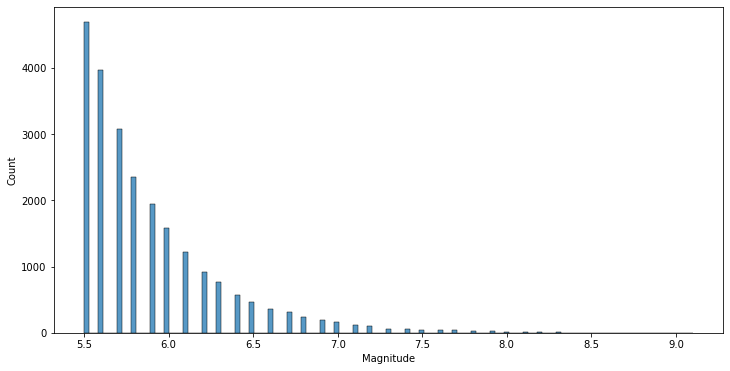

In [11]:
plt.figure(figsize=(12,6))
sns.histplot(df.Magnitude)

<AxesSubplot:xlabel='date', ylabel='Magnitude'>

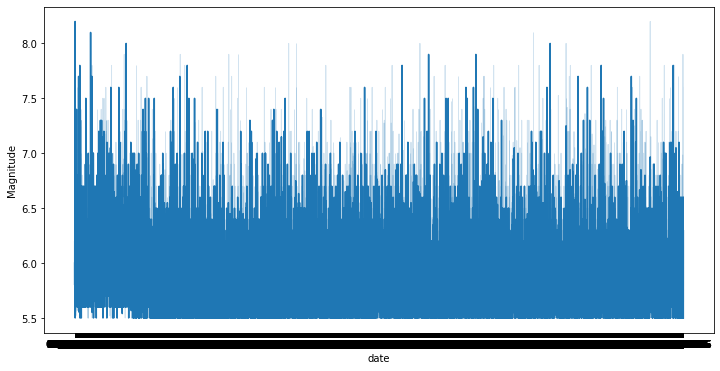

In [111]:
#new_data = df.sort_values(['year'] , ['month'])
plt.figure(figsize=(12,6))
sns.lineplot(data=or_df, x='date', y='Magnitude')

In [21]:
layout = go.Layout(
    title='3D Scatter Plot',
    scene=dict(
        xaxis=dict(title='Years'),
        yaxis=dict(title='Magnitude'),
        zaxis=dict(title='Months')
    )
)
trace = go.Scatter3d(
    x=df.year,
    y=df.Magnitude,
    z=df.month,
    mode='markers',
    marker=dict(
        size=5,
        color=df.Magnitude,
        colorscale='Viridis',
        opacity=0.6
    )
)

# Create the figure object
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
pyo.iplot(fig)

In [31]:
layout = go.Layout(
    title='3D Scatter Plot',
    scene=dict(
        xaxis=dict(title='Latitude'),
        yaxis=dict(title='Magnitude'),
        zaxis=dict(title='Longitude')
    )
)
trace = go.Scatter3d(
    x=or_df.Latitude,
    y=or_df.Magnitude,
    z=or_df.Longitude,
    mode='markers',
    marker=dict(
        size=5,
        color=df.year,
        colorscale='deep',
        opacity=0.6
    )
)

# Create the figure object
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
pyo.plot(fig)

'temp-plot.html'

In [30]:

data = [
    go.Scattergeo(
        lat=df.Latitude,
        lon=df.Longitude,
        text=df['Magnitude'].astype(str) + ',' + df['year'].astype(str), 
       # texttemplate= df.year,
        mode='markers',
        marker=dict(
            size=4,
            color='red',
            opacity=0.5
        )
    )
]

# Define the layout
layout = go.Layout(
    title='Earthquakes',
    geo=dict(
        showland=True,
        showcountries=True,
        showocean=True,
        projection=dict(
            type='mercator'
        )
    )
)

# Create the figure object
fig = go.Figure(data=data, layout=layout)

# Show the plot
pyo.plot(fig)


'temp-plot.html'

<AxesSubplot:xlabel='month', ylabel='Count'>

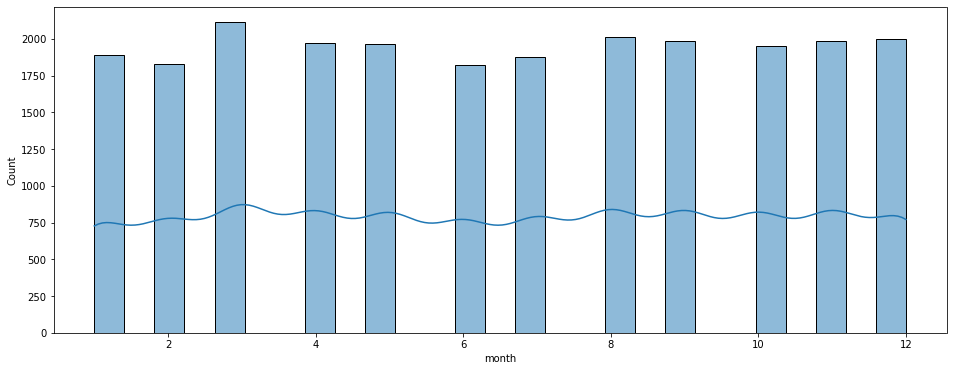

In [37]:
plt.figure(figsize=(16,6))
sns.histplot(data = df.month, kde = True)

<AxesSubplot:xlabel='year', ylabel='Count'>

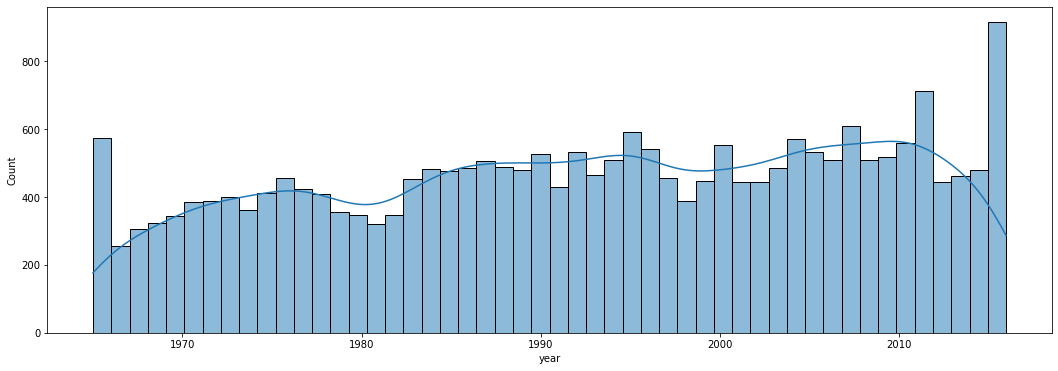

In [36]:
plt.figure(figsize=(18,6))
sns.histplot(data = df.year, bins = 50, kde = True)

<AxesSubplot:>

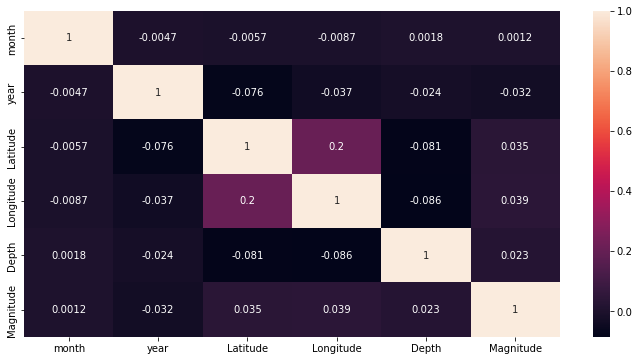

In [60]:
plt.figure(figsize=(12,6))
sns.heatmap(data = df.corr(), annot=True)

In [38]:
df.groupby('Impacted_Country')['Magnitude'].sum()

Impacted_Country
AF    948.7
AG     88.0
AI     16.5
AL     34.7
AM     12.7
      ...  
XK     17.2
YE    344.0
ZA    676.8
ZM     28.2
ZW     23.9
Name: Magnitude, Length: 156, dtype: float64

In [69]:
y = df['Magnitude']

In [70]:
X = df.loc[:, ~df.columns.isin(['Magnitude'])]

In [71]:
X.head()

,month,year,Latitude,Longitude,Depth
0,1,1965,19.246,145.616,131.6
1,1,1965,1.863,127.352,80.0
2,1,1965,-20.579,-173.972,20.0
3,1,1965,-59.076,-23.557,15.0
4,1,1965,11.938,126.427,15.0


In [84]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [47]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=5, input_dim=57, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))
 
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Compiling the model
model.compile(loss=root_mean_squared_error, optimizer='adam')
 
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 20, epochs = 50, verbose=1)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [73]:
params = {
    "n_estimators": 250,
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [74]:
from sklearn import datasets, ensemble
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))


In [77]:
rmse = sqrt(mse)
print("The Root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
print("Model Accuracy: %.3f" % reg.score(X_test, y_test))

The Root mean squared error (RMSE) on test set: 0.4125
Model Accuracy: 0.052


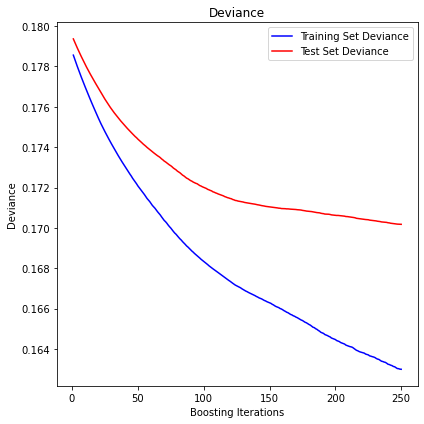

In [78]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

In [85]:
from keras.models import Sequential
from keras.layers import Dense

# 3 dense layers, 16, 16, 2 nodes each

def create_model(neurons, activation, optimizer, loss):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=(3,)))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [86]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)

# param_grid = {
#     "neurons": [16, 64], 
#     "batch_size": [10, 20], 
#     "epochs": [10],
#     "activation": ['sigmoid', 'relu'],
#     "optimizer": ['SGD', 'Adadelta'],
#     "loss": ['squared_hinge']
# }
param_grid = {
    "neurons": [16], 
    "batch_size": [10, 20], 
    "epochs": [10],
    "activation": ['sigmoid', 'relu'],
    "optimizer": ['SGD', 'Adadelta'],
    "loss": ['squared_hinge']
}

C:\Users\Ajinkya\AppData\Local\Temp\ipykernel_12812\3174595268.py:3: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



In [87]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [88]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

best_params = grid_result.best_params_
best_params

C:\Users\Ajinkya\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


40 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Ajinkya\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Ajinkya\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\Ajinkya\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit

ValueError: in user code:

    File "C:\Users\Ajinkya\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Ajinkya\anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Ajinkya\anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Ajinkya\anaconda3\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Ajinkya\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Ajinkya\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 3), found shape=(None, 5)
